# Key Project Strategy Simulator - Gaia

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate
import h5py
import copy

## Gaia Event Sky Locations

To start off with, let's start by simulating the set of Gaia events that we are likely to detect. 

The code skymap_events.py was previously used to map the events detected in Gaia Data Release 3 by Katarzyna, and convert this into a very rough map of event rate per year per HEALpixel (see code skymap_events.py).  This takes into account Gaia's time sampling, the distributions of stars, events and extinction, and Gaia's restricted limiting magnitude in crowded fields. 

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'gaia/gaia_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

gaia_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
gaia_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

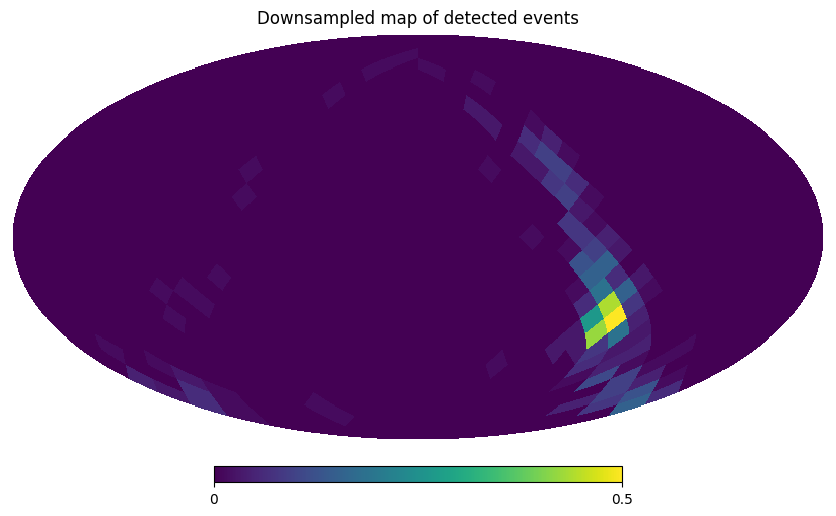

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(gaia_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

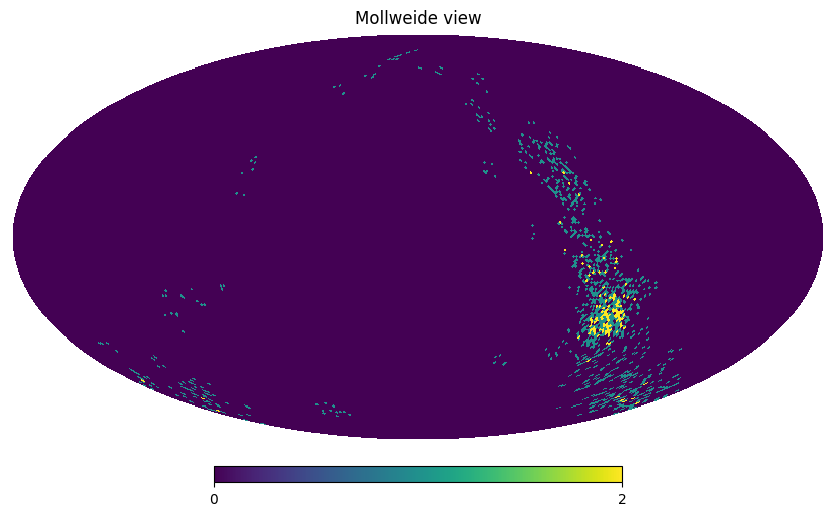

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = gaia_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (290.390625, 19.47121944)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (265.78125, -33.51005556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (291.796875, 23.31795556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (250.9322, -45.78396667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (294.609375, 24.62431667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 23.31795556)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (223.67646667, -64.94808333)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (283.359375, -3.58331944)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (268.59375, -33.51005556)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (264.375, -21.38194167)>"


## Gaia Event Baseline Magnitudes

Next we need to simulate the lightcurve data that Gaia would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  We derive this by looking at the distribution of historic data from the Gaia Alerts system.  

In [8]:
def str2float(str):
    if len(str) > 0:
        return float(str)
    else:
        return -99.999

In [9]:
file_path = 'gaia/gaia_alerts_data.csv'
file_lines = open(file_path, 'r').readlines()
event_ids = []
data = []
for i,line in enumerate(file_lines):
    if i > 0:
        row = line.replace('\n','').split(',')
        event_ids.append(row[0])
        data.append([str2float(row[2]), str2float(row[3]), str2float(row[5]), str2float(row[6])])
data = np.array(data)

gaia_alert_table = Table([
                            Column(name="Event", data=event_ids, dtype='str'),
                            Column(name="RA", data=data[:,0], dtype='str'),
                            Column(name="Dec", data=data[:,1], dtype='str'),
                            Column(name="mag", data=data[:,2], dtype='float'),
                            Column(name="mag_error", data=data[:,3], dtype='float'),
                            ])
gaia_alert_table

Event,RA,Dec,mag,mag_error
str9,str32,str32,float64,float64
Gaia22epg,19.96019,-53.955,19.83,0.4
Gaia22epf,274.77416,-28.17701,19.55,0.05
Gaia22epe,273.40098,-29.60688,19.3,0.04
Gaia22epd,271.10083,-24.27362,18.34,0.36
Gaia22epc,14.69411,-56.98653,16.86,0.18
Gaia22epb,272.94736,-27.39745,18.11,0.06
...,...,...,...,...
Gaia14aag,219.14335,44.65261,18.42,0.02
Gaia14aaf,244.25381,62.00685,18.06,0.19


Text(0.5, 1.0, 'Distribution of baseline magnitudes of Gaia Alerts')

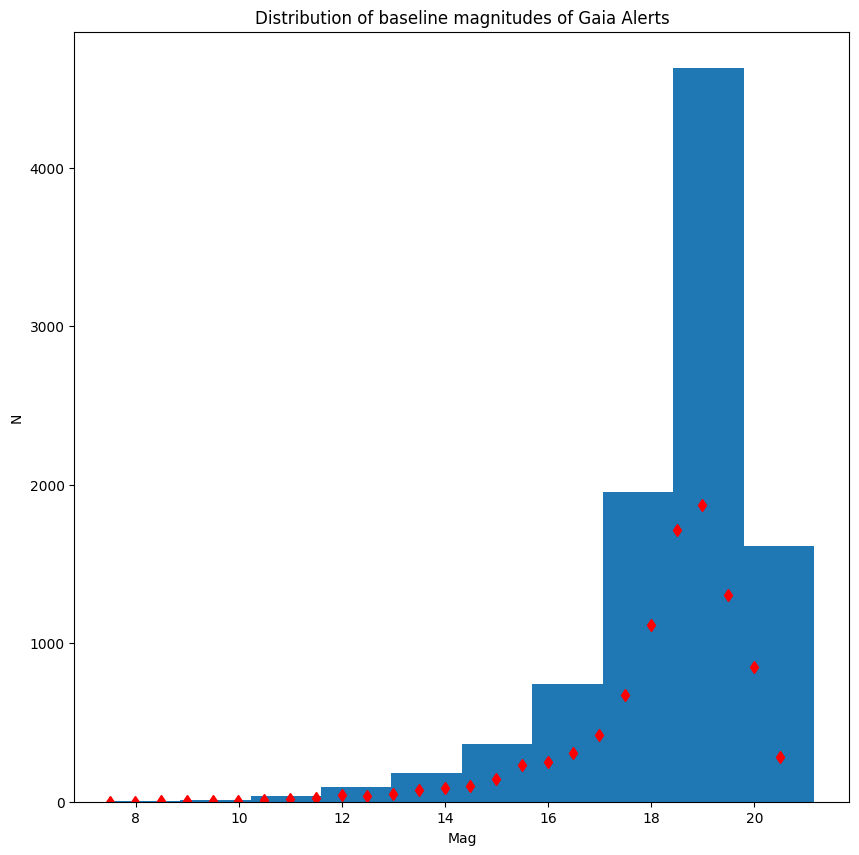

In [10]:
idx = np.where(gaia_alert_table['mag'] > 0.0)
mag_min = gaia_alert_table['mag'][idx].min()
mag_max = gaia_alert_table['mag'][idx].max()
(mag_dist, mag_bins) = np.histogram(gaia_alert_table['mag'][idx], bins=np.arange(mag_min, mag_max, 0.5))


fig = plt.figure(1,(10,10))
plt.hist(gaia_alert_table['mag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of baseline magnitudes of Gaia Alerts')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for Gaia detections

Text(0.5, 1.0, 'Distribution of simulated Gaia detections')

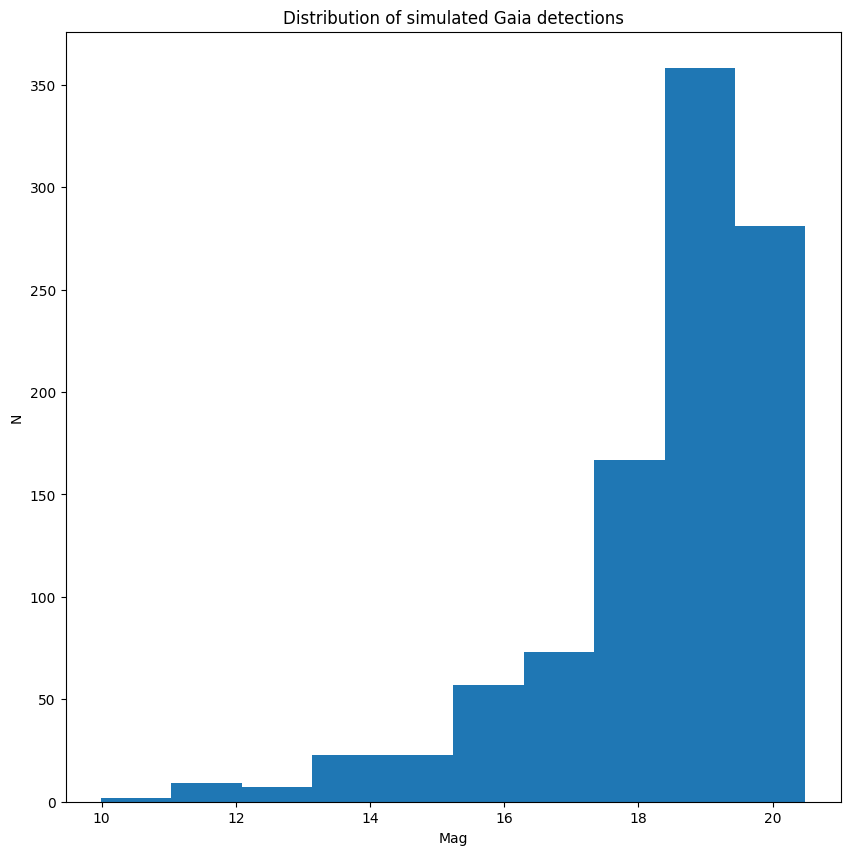

In [11]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated Gaia detections')

## Gaia Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the overlap between the Key Project (2023-2026) and Gaia's expected dates of operation (2023-2025):

In [12]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2460887.5000

In [13]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [14]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

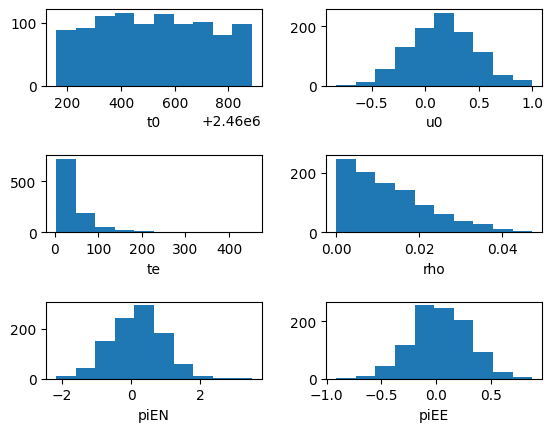

In [15]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

Based on experience from previous year's of survey data, approximately 10% of events are binary lenses, which show anomalies, caustic crossings and other lightcurve features that need higher cadence observations in order to characterize them.  

To simulate this, and estimate the total amount of time this would require, ideally we would simulate a set of binary events but modeling 100 such events would be extremely time consuming.  Instead, we randomly nominate 10% of events in the table to be binaries, and use this flag to trigger more intensive observations over the event peak.  This effectively simulates the real-world observations that would be made of a subtle (planetary-style) anomaly. 

While binary stellar events often take longer (the gap between caustic entry and exit can be a few days), they do not need to be monitored as intensively the whole time.  Instead, intensive observations would be required over the caustic crossings, returning to moderate cadence in the gap.  The difference in the time requirements will be taken into account at a later stage.  

In [17]:
binaries = np.random.random_integers(0, n_samples-1, int(0.1*n_samples))
binary_index = np.zeros(n_samples, dtype=int)
binary_index[binaries] = 1

For ease of handling, let's combine these data into a single events table

In [18]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('GaiaSim'+roundID(x))

In [19]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name="binary_lens", data=binary_index, dtype='int'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,int64
GaiaSim00001,16462,"<SkyCoord (ICRS): (ra, dec) in deg\n (290.390625, 19.47121944)>",19.490000000000002,2460580.2908062916,0.24013586972675044,48.94054670125578,0.03383931251164614,-0.17942727901780592,0.03151465986800139,0.0,0
GaiaSim00002,38205,"<SkyCoord (ICRS): (ra, dec) in deg\n (265.78125, -33.51005556)>",17.990000000000002,2460702.4797641393,0.3744687445908236,20.751565175323993,0.001647921608315464,-0.7691926935731206,0.013071970626769326,0.0,1
GaiaSim00003,14927,"<SkyCoord (ICRS): (ra, dec) in deg\n (291.796875, 23.31795556)>",18.490000000000002,2460876.8867736543,0.4170640374175024,42.575951025221215,0.001183381446027294,-0.29106974423888554,-0.1943792073963215,0.0,1
GaiaSim00004,42236,"<SkyCoord (ICRS): (ra, dec) in deg\n (250.9322, -45.78396667)>",17.490000000000002,2460278.064395372,0.48853614343401164,9.209158274948333,0.008074616105262883,0.410687695914732,-0.025654846616837916,0.0,0
GaiaSim00005,14417,"<SkyCoord (ICRS): (ra, dec) in deg\n (294.609375, 24.62431667)>",11.99,2460229.623265006,0.25978823033588216,11.585479292348424,0.0335624472190979,1.4216102506556507,0.0062961164983649995,0.0,0
GaiaSim00006,14925,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 23.31795556)>",17.990000000000002,2460394.156118005,-0.1859640047944737,5.129355229681086,0.006933162651926882,0.25544209727504885,-0.0167622946195376,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,34366,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -23.31795556)>",18.990000000000002,2460480.7858625883,-0.05427982290042205,21.355383653844115,0.016667208753648237,-0.17443228038558684,0.20593748218304386,0.0,0
GaiaSim00995,25411,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -1.79078333)>",19.490000000000002,2460297.5937624373,0.008039956367490164,5.6345699735583805,0.009821082505825598,-0.11065228672393607,0.21534553888181457,0.0,0


### Blending

Note that we implicitly assume zero blending from background stars in the photometry for Gaia events.  Analysis offline has shown that this is a reasonable approximation for events outside the galactic centre, which are the majority of Gaia events. 



## Gaia Event Lightcurve sampling

In order to generate realistic Gaia lightcurves, we take into account the non-uniform map of visits that results from Gaia's scanning law. We read in this data, which was resampled using the gaia/gaia_scanning_law notebook, and output to file gaia/gaia_dr3_nvisits_34months.fits.  Since Gaia is expected to continue operating for 24months during the Key  Project, we scale the expected number of visits per HEALpixel accordingly.  

In [20]:
gaia_duration = 34*30.0
gaia_kp_overlap = 365.24*2.0
scale_factor = gaia_kp_overlap / gaia_duration
scale_factor

0.716156862745098

In [21]:
map_file_path = 'gaia/gaia_dr3_nvisits_34months.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

gaia_nvisits = Table([
                        Column(name="HP", data=data_table['hp_index'], dtype='int'),
                        Column(name="nvisits", data=data_table['nvisits']*scale_factor, dtype='int'),
                        ])
gaia_nvisits

HP,nvisits
int64,int64
1,221
2,226
3,219
4,219
5,232
6,222
...,...
49146,224
49147,230


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [22]:
events_table['nvisits'] = gaia_nvisits['nvisits'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,int64,int64
GaiaSim00001,16462,"<SkyCoord (ICRS): (ra, dec) in deg\n (290.390625, 19.47121944)>",19.490000000000002,2460580.2908062916,0.24013586972675044,48.94054670125578,0.03383931251164614,-0.17942727901780592,0.03151465986800139,218,0
GaiaSim00002,38205,"<SkyCoord (ICRS): (ra, dec) in deg\n (265.78125, -33.51005556)>",17.990000000000002,2460702.4797641393,0.3744687445908236,20.751565175323993,0.001647921608315464,-0.7691926935731206,0.013071970626769326,119,1
GaiaSim00003,14927,"<SkyCoord (ICRS): (ra, dec) in deg\n (291.796875, 23.31795556)>",18.490000000000002,2460876.8867736543,0.4170640374175024,42.575951025221215,0.001183381446027294,-0.29106974423888554,-0.1943792073963215,417,1
GaiaSim00004,42236,"<SkyCoord (ICRS): (ra, dec) in deg\n (250.9322, -45.78396667)>",17.490000000000002,2460278.064395372,0.48853614343401164,9.209158274948333,0.008074616105262883,0.410687695914732,-0.025654846616837916,191,0
GaiaSim00005,14417,"<SkyCoord (ICRS): (ra, dec) in deg\n (294.609375, 24.62431667)>",11.99,2460229.623265006,0.25978823033588216,11.585479292348424,0.0335624472190979,1.4216102506556507,0.0062961164983649995,344,0
GaiaSim00006,14925,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 23.31795556)>",17.990000000000002,2460394.156118005,-0.1859640047944737,5.129355229681086,0.006933162651926882,0.25544209727504885,-0.0167622946195376,445,0
...,...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,34366,"<SkyCoord (ICRS): (ra, dec) in deg\n (267.890625, -23.31795556)>",18.990000000000002,2460480.7858625883,-0.05427982290042205,21.355383653844115,0.016667208753648237,-0.17443228038558684,0.20593748218304386,143,0
GaiaSim00995,25411,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -1.79078333)>",19.490000000000002,2460297.5937624373,0.008039956367490164,5.6345699735583805,0.009821082505825598,-0.11065228672393607,0.21534553888181457,115,0


Store the table of simulated event parameters

In [23]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))
column_list.append(fits.Column(name='binary_lens', array=events_table['binary_lens'], format='I1'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_events_table.fits', overwrite=True)


## Gaia Event Lightcurves

Now we can simulate the lightcurves that Gaia would produce for these simulated events.  Although the scanning law data does not tell us the distribution of visits over the 34 months included in Gaia DR3, it is a regularly repeating function with a non-varying scan from a space-based facility.  The sampling isn't uniform, but we approximate it here as uniform, since experiments with the Gaia scanninglaw package failed due to out of date documentation.  

In [24]:
def add_gaia_g_noise(mag):
    """Code by Markus Hundertmark
    """
    a1 = 0.2
    b1 = -5.3 #-5.2
    a2=0.2625
    b2= -6.3625 #-6.2625

    mag_obs_list = []
    magerr_list = []

    for value in mag:
        log_err1 = a1*value + b1
        log_err2 = a2*value + b2
        if (value < 13.5):
            magerr = 10**(a1*13.5+b1)
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if value>=13.5 and value<17:
            magerr = 10**log_err1
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if (value>=17):
            magerr = 10**log_err2
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        #this works until 21 mag.
    return np.array(mag_obs_list), np.array(magerr_list)

In [25]:
def simulate_event_gaia(event_params, start_date, end_date, horizons_table, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Simulate timestamps
    cadence = (end_date - start_date) / event_params['nvisits']
    timestamps = np.arange(start_date, end_date, cadence)
    
    # Create a PyLIMA event object
    sim_event = event.Event()
    sim_event.name = event_params['EventID']
    sim_event.ra = float(event_params['location'].ra.deg)
    sim_event.dec = float(event_params['location'].dec.deg)

    # Generate a constant lightcurve at the event's baseline magnitude, with fixed photometric uncertainties, 
    # since these will be replaced later
    lc = np.zeros((len(timestamps),3))
    lc[:,0] = timestamps
    lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
    lc[:,2] = [0.01] * len(timestamps)
    print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
    # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
    tel = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel.spacecraft_positions = spacecraft_positions
    
    sim_event.telescopes.append(tel)
    sim_event.find_survey('Gaia')
    
    # Add a PyLIMA model to the event, using the simulated parameters
    if parallax:
        sim_model = microlmodels.create_model('FSPL', sim_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    else:
        sim_model = microlmodels.create_model('FSPL', sim_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]
        
    sim_model.define_model_parameters()
    
    if parallax:
        sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
    tel = sim_model.event.telescopes[0]
    
    pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
    #print(event_params)
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    magnification = sim_model.model_magnification(tel, pylima_parameters)
    A = sim_model.model_magnification(tel,pylima_parameters)
    
    lightcurve = sim_event.telescopes[0].lightcurve_magnitude
    lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
    (lightcurve[:,1],lightcurve[:,2]) = add_gaia_g_noise(lightcurve[:,1])
    sim_event.telescopes[0].lightcurve_magnitude = lightcurve
    print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
    
    return sim_event, sim_model, lensing_parameters

In order to implement parallax for Gaia events, we use the projected vector locations of the spacecraft, as generated by JPL Horizons, and output to an ASCII table which can be read from file.  
The JPL Horizons configuration used to generate this table is:
* Ephemeris type: Vector table
* Target body: Gaia (spacecraft)
* Coordinate center: Solar System Barycenter SSB [500@0]
* Time: 2023-01-01 to 2026-08-30, increments of 1 day (duration of Key Project)
* Table settings: default

However, this appears not to be the format required to calculate the observed location of the spacecraft.  Instead it needs the RA, Dec position, meaning that the observer table format is required, with the following options:
* Astrometric RA & Dec
* Rates RA & Dec
* Airmass and extinction (required)
* Visual mag & surface brightness
* Heliocentric range and range rate
* Observer range and range rate
* Sun-Observer-Target ELONG angle
* Sun-Target-Observer PHASE angle
* Local apparent hour angle
* Sky motion
* Lunar sky brightness

In [26]:
gaia_vector_table_file = './gaia/jplhorizons_observer_table.txt'

horizons_table = jplhorizons_utils.parse_JPL_Horizons_table(horizons_file_path=gaia_vector_table_file, 
                                                                   table_type='OBSERVER')
horizons_table

Date,RA,Dec,Delta,JD
bytes16,float64,float64,float64,float64
2023-Jan-01T00:0,101.31470833333333,22.988694444444445,0.99424530711027,2459945.5
2023-Jan-02T00:0,102.41991666666667,22.90411111111111,0.99437003596059,2459946.5
2023-Jan-03T00:0,103.52370833333335,22.811972222222224,0.99450009481111,2459947.5
2023-Jan-04T00:0,104.625875,22.712305555555556,0.9946354327103,2459948.5
2023-Jan-05T00:0,105.72629166666665,22.605194444444447,0.99477599538272,2459949.5
2023-Jan-06T00:0,106.82491666666667,22.49063888888889,0.99492172842485,2459950.5
...,...,...,...,...
2026-Aug-22T00:0,330.5357916666667,-12.060194444444445,1.02354688405442,2461274.5
2026-Aug-23T00:0,331.45425,-11.725111111111111,1.02327762396697,2461275.5


In [27]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

gaia_lens, gaia_lens_model, lens_model_pars = simulate_event_gaia(events_table[event_number], start_date, end_date, horizons_table, parallax=True)

Picked bright event:  1  baseline_mag= 17.990000000000002 mag
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.97997373475047


Simulate all events

In [28]:
sim_gaia_lenses = []
sim_gaia_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (gaia_lens, gaia_lens_model, lens_model_pars) = simulate_event_gaia(events_table[ievent], start_date, end_date, horizons_table, parallax=True)
    sim_gaia_lenses.append(gaia_lens)
    sim_gaia_lens_models.append(gaia_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.45385037392259
0 [2460580.2908062916, 0.24013586972675044, 48.94054670125578, 0.03383931251164614, -0.17942727901780592, 0.03151465986800139]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.986026639240947
1 [2460702.4797641393, 0.3744687445908236, 20.751565175323993, 0.001647921608315464, -0.7691926935731206, 0.013071970626769326]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.482468948170578
2 [2460876.8867736543, 0.4170640374175024, 42.575951025221215, 0.001183381446027294, -0.29106974423888554, -0.1943792073963215]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.4863276163024
3 [2460278.064395372, 0.48853614343401164, 9.209158274948333, 0.008074616105262883, 0.41

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.988022601168577
35 [2460682.375957861, 0.4623388037484176, 22.43719192726226, 0.007689615694385187, 0.9151737629762082, 0.3483645861230424]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.487768518032093
36 [2460292.119050743, -0.2531912412347417, 16.053985836397572, 0.013400587216081238, -1.606042351120276, 0.20616001759538105]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.985152606648303
37 [2460806.233229766, 0.08056552617814029, 20.599561450512773, 0.0009230123697611991, 0.6649146165249058, 0.1620290074903069]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.93427543567134
38 [2460716.878363681, -0.07668111404520359, 95.97304978724178, 0.002716737976810193, 0.27072346160244126, 0.35914724320996805]
16.990000000000002 16.990000000000002
Pa

Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.47685973088197
71 [2460159.2468166566, 0.2599956256031304, 28.02520691678438, 0.015994205123859444, -0.25770533502307186, -0.01641786980312717]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47621790097982
72 [2460555.6380430437, 0.35532724000303256, 32.7142777387308, 0.007885578957116508, 1.4330417028084104, 0.4365324081944897]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.96276322481818
73 [2460794.9602755173, 1.0, 82.14081273779311, 0.020110224546739726, 0.6496565326595428, 0.22789468950398933]
12.99 12.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
12.99 12.989017489542983
74 [2460288.979365402, -0.21992616314582827, 13.727487807625758, 0.013846343989342974, -1.182279687751387, 0.16433670797117192]
11.49 11.49
Parallax(Full) estimated for the telescope 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.99 13.989469701445156
108 [2460726.622114162, 0.25113601379755796, 8.312343166636499, 0.004201042283133567, 0.649324630410794, -0.4051952906076304]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.396007505953111
109 [2460654.7226852854, 0.2404746871065788, 134.6015469041278, 0.011711061800216162, 0.3701166757517686, 0.1186219554041153]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.42818449697995
110 [2460653.125942493, 0.11361719092914603, 91.01510902959303, 0.00950528126007031, 0.4734582241430947, 0.07005441871721865]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.482439778293255
111 [2460181.150288953, 0.3447938370812175, 14.277042791261005, 0.008583859166373855, 0.05501593270611034, -0.1339082747530189]
18.490000000000002 18.490000000000002
Parallax(Full) 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.962379424745215
150 [2460234.7243369534, -0.18024568179282677, 61.42683008990703, 0.0068421041395550376, 0.31444772138319366, 0.16708569359005063]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.986009704179875
151 [2460349.780286556, 0.4694909781483909, 19.366110440613607, 0.020526519069749852, -0.6886656931825617, 0.017814710963415387]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.975701681324242
152 [2460539.9840674503, 0.0020820078254167595, 22.95169040973568, 0.0005962373662427431, 0.40007018218240875, -0.19644803454596518]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.482819771818768
153 [2460591.31299773, 0.695584644766392, 11.26154986644229, 0.024775806923748395, 1.5248727685534156, 0.25215783

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.99065526943883
188 [2460705.3115488025, 0.030804389157521136, 20.754243153196384, 0.006575898017064804, 1.2012774026853374, -0.0736096976096467]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.483335496136355
189 [2460724.4207494496, 1.0, 24.866655281836902, 0.0036865728395783764, 0.7276462472565379, -0.17304204016316893]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.463076980705644
190 [2460532.854291659, 0.23996811459360207, 52.97930707381703, 0.0016611900631503147, 0.4900646070404336, 0.3529936229381977]
14.49 14.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.49 14.48657694073843
191 [2460547.4670022824, -0.1723158000395343, 51.94549567931852, 0.0026046238788313657, 1.113623942320304, 0.26177628121758173]
16.990000000000002 16.990000000000002
Parallax(

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.474318842368923
229 [2460445.9683502605, 0.06720780328141257, 31.26527597825127, 0.007633953812532216, -0.0702715100615495, -0.22403362934436452]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.98523991618374
230 [2460245.7497202344, 0.639776424603406, 8.041596672498736, 0.004597700821926931, 0.6084148252082577, -0.19436874098814388]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.454102449526488
231 [2460779.495454285, 0.28927987081836776, 65.30241192069315, 0.0021491852333797475, -0.5088934932292135, -0.03188896499276516]
9.99 9.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
9.99 9.988048126625397
232 [2460753.1246211985, -0.22953004444813854, 20.035004549774865, 0.0010259630643811345, 1.085380956236815, 0.25837485772548074]
19.490000000000002 19.49000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.47388533703389
267 [2460720.2755061, -0.020882717339539753, 36.437536208544316, 0.00237097567625938, 0.6910621524747256, 0.03954259097878205]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.456195174264277
268 [2460705.20124018, 0.5733616862691078, 64.95591015161554, 0.0035496963073104763, -0.8585020895295283, 0.29323455498523976]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.980631888211587
269 [2460342.8993638405, -0.10926769511618054, 29.830194890494607, 0.0340098381571356, 1.442230134658723, 0.1543024147400166]
14.49 14.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.49 14.48946060803036
270 [2460501.5944214705, 0.2282686653342217, 9.257080185938454, 0.01052374477829373, 0.42524795365554735, 0.17891343855169767]
18.990000000000002 18.990000000000002
Pa

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48737710413625
307 [2460882.6605982915, 0.6648345113930489, 16.600676724516777, 0.028222199303808454, -0.7997371366164141, 0.1657278768565614]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.483326499118093
308 [2460517.874526545, 0.1695544800857433, 24.417179391134695, 0.007551404337307531, 0.11265762524991846, 0.26661271931725383]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.987598810103822
309 [2460371.1570999455, 0.43037440227198975, 16.785734206466227, 0.022503390581654847, -0.11165456485006992, 0.14407348633679232]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.961595418529342
310 [2460363.689214681, 0.013947725337266043, 58.687826513137814, 0.00712688285895755, 1.0075987856028568, -0.3756098031

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.978806629105176
346 [2460361.290105122, 0.28127948139824094, 161.7312141789191, 0.0032432455563249085, 1.1899209207546442, 0.11454102809539116]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48600244212433
347 [2460211.7867199746, 0.27624873737613875, 8.133493526915341, 0.009448807107114236, 0.5184753801649901, -0.1934075459617719]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.985130301471525
348 [2460600.3897625753, 0.1799609465481939, 10.608713857960904, 0.01487194741004079, 0.34464592282789197, 0.09386598380055655]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.39662365190133
349 [2460433.8235141123, -0.06820075887370919, 65.34425638500244, 0.002038237175785605, 0.8862701555659411, 0.2824556239359851]
19.490000

14.99 14.955854348594048
395 [2460502.235439043, 0.4014658999073767, 77.21092167970995, 0.0035118837828363673, -0.6960828403614421, -0.4955516878206759]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.960224163590325
396 [2460337.7541165785, 0.534760858472507, 141.4054901793653, 0.028772730308684075, -0.646670769291595, 0.3058867424029114]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.986833608135054
397 [2460704.125447763, 0.15519900249640226, 9.13952175549779, 0.008119423528776178, 1.2612124530588857, 0.15460863603871178]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.473322798556442
398 [2460855.7644520616, -0.34006969360799, 80.52003030765401, 0.010171624904239965, 0.6021295220708534, -0.0359465570485887]
13.49 13.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
13

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.971918362824542
434 [2460641.3291032575, 0.3790890241312212, 19.605879318871374, 0.01751066620563402, -0.2708007110539986, -0.02297303347514624]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.971422178022973
435 [2460867.070937145, 0.12117710025007619, 42.429079248058976, 0.023388663050898387, 0.546778294691314, -0.2930023444047377]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.48648524637016
436 [2460836.726553267, -0.0037309786585952853, 7.387113584089708, 0.002682405489653407, 0.2971110461829899, -0.07937618415510578]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47692034575161
437 [2460652.5998497466, 0.7285335515762894, 12.203949796098088, 0.03474290351222181, 0.12018877442693104, 0.177501796139

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.978131849961336
476 [2460331.217399533, -0.300529911627581, 28.43549821168144, 0.0007554412867156954, -0.2836831689402845, -0.38405354919821544]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.474871809171056
477 [2460194.047366982, 0.25193659903462007, 65.71140740269567, 0.009900729100227854, 0.34648558238788507, -0.1761037016614696]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.947213754728104
478 [2460498.2420195593, 0.45264580407879584, 69.92090689578822, 0.004100162813633505, 0.24562739851819815, -0.03624410889956136]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.987829950225375
479 [2460462.9835415385, -0.5519835685059384, 17.464664985912886, 0.04597130516684971, 0.17984031098934847, -0.06993280

Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.989074972076242
517 [2460493.7295251647, -0.1437977794035132, 10.686230919032173, 0.009193669551354481, 1.2345542272444687, 0.623907733034301]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.97584976073778
518 [2460361.7034964794, -0.2605483277706737, 13.723074881487786, 0.005362653080833514, 0.9554192465092501, 0.19122272348704553]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.978909816443156
519 [2460245.559156966, 0.619524029154297, 44.15976554637227, 0.03498710530668995, -0.22819700227648632, -0.040530140970884]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.969877843700814
520 [2460210.577775403, 0.2958484808498397, 77.0375946794475, 0.0014547582998371477, 0.3651163552603217, 0.4184908094526728]
19.49000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.978130184984405
556 [2460175.4740622896, 0.5537943692885887, 45.007344472277076, 0.0007699019385080073, 0.6334037041479506, -0.05183613203371721]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97214978751369
557 [2460679.4095456586, 0.8923866361458098, 20.303255833274836, 0.001776202836937163, 0.594318451990332, 0.3718447618528948]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47272709939535
558 [2460587.482220983, 0.4596504790255326, 38.38051543840058, 0.0010331328275693628, 0.03881196961558997, 0.3072346630913647]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.45197114715745
559 [2460565.179294276, 0.872991882179896, 77.88774530399233, 0.011211334954211304, 0.47718561782302954, -0.21986218958142814]

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.48173748151791
592 [2460645.0528751602, 0.4723573698252709, 40.264685891903866, 0.01156841707212413, -0.07180713452427695, -0.15824472400655676]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.493395428376868
593 [2460789.450840052, 0.5585602945445729, 13.773019618197624, 0.005840309521190424, 0.228388651961012, 0.17050940089414948]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.473763086158936
594 [2460158.351580771, 0.7522682616024544, 58.76599881256093, 0.015264663503860697, -0.7573130278361258, -0.20979092733659085]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.985899803280166
595 [2460734.605204, 0.6217987088699117, 12.125213296213714, 0.0011473398823986063, -0.9797281176122155, -0.22620990556199785]
18.490000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.470567535875798
627 [2460600.4788729227, -0.03791027027688293, 29.521246211859953, 0.018307056840431726, 0.11772180144570259, 0.315622846848746]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98232862519361
628 [2460163.867226976, 0.4115010800493175, 39.58324208948812, 0.004198942983864263, -0.08074162189517592, 0.2425443100062655]
12.49 12.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
12.49 12.488701469981107
629 [2460515.672490726, 0.13532406343742054, 15.576301732757067, 0.023515588704520723, 0.4269466546748699, 0.43743293618941664]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.970473248484844
630 [2460453.791418869, 0.5025294908738412, 46.2053870663015, 0.013729964805874805, 0.676487421806552, 0.04897847317410409]
18.990000000000002 18.990000000000002


Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.47083469639071
661 [2460774.009450326, -0.053221503332875425, 57.12834375331355, 0.014289522459117233, 0.7250613165180306, -0.04304913853419252]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.472452144310452
662 [2460199.9004738163, 0.419585329384927, 79.00999315481823, 0.0014861054174673278, 1.4514770586353758, -0.36987756729904436]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.983578518359383
663 [2460448.7177785304, -0.015568281180275284, 27.218607028635788, 0.016089440089338845, 0.7837928697314493, 0.14805575138789692]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.484274475567627
664 [2460260.5351796304, 0.3914577204878844, 18.70454747035975, 0.0005852681362851341, 1.739000781550936, 0.2157926541

Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.49 13.48869034929056
698 [2460282.1246190346, 0.27086040382681553, 23.377610117441918, 0.011830658995077825, -1.0385672289622714, 0.026092483258577437]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.949236738133017
699 [2460688.706000193, -0.05338794964681551, 57.354244269227145, 0.008828948661525747, 0.6982790074669016, 0.1812293056985002]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.482757561609564
700 [2460176.197152092, 0.5993596033515679, 20.44632399209328, 0.02333820384811587, -0.6034108825312743, 0.06594032251344295]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.46519302879028
701 [2460237.7710100473, 0.25095133674432707, 13.967260046882485, 0.038155996000502186, -1.2419994606183065, 0.10219790881302551]
18.990

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98466001657781
735 [2460678.7156928857, 0.21986962187490616, 32.82303288290723, 0.00502861300491733, 0.3319151042378353, -0.543300019332601]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.967083990689343
736 [2460246.6647471734, 0.3052644710985245, 35.66503764146603, 0.009258821455983742, 0.006992022226374794, -0.14762572838482185]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.971758771274043
737 [2460216.766386357, -0.37321215408535646, 40.93776382562895, 0.004283218119859596, 1.6429728520563347, -0.12097476905347068]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47986274978844
738 [2460329.1526720067, -0.048686769106163874, 14.023862890080148, 0.006475694065248927, 0.5108370901684658, 0.08444270074

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.48820060942613
774 [2460601.058252512, -0.2095480140645752, 7.879123860562948, 0.0015506889388594179, 1.1404845703062947, 0.09562433974454337]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.974457297275713
775 [2460815.514803593, 0.12240189024561879, 38.29631804329558, 0.01276409331512941, -0.9442719847664034, 0.01778303957558613]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.986156127946778
776 [2460188.337270394, 0.2876108675643172, 6.84242768328675, 0.0156701445564596, 0.8387402483934783, 0.0739708869636353]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.4740260667345
777 [2460803.48415627, 0.2337509402357934, 51.359302155634424, 0.0044196931879535144, -0.18690247829630957, -0.002187395447760171]
1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.99184107906477
813 [2460312.6990845716, -0.0021416807832528306, 9.397850588745687, 0.012841555983525071, 0.11621245917374515, -0.14580099604262617]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.484516241183712
814 [2460852.2489312035, 0.37393267939933256, 19.20033201314417, 0.00641118062278746, -0.8041809278065146, -0.2570736841442457]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47106459632062
815 [2460480.6551792845, -0.23432806154590055, 39.77795678483777, 0.0065456734882193834, 0.35742964785577874, -0.11607197013085133]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.484650484282376
816 [2460180.2727657915, 0.20927235424828225, 14.133285054267581, 0.02039735400932248, 0.11841758148753975, 0.06972

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47103326645101
848 [2460699.3809820763, 0.032222022269960585, 30.675961381684253, 0.0036625532794523795, 0.9236941688511242, -0.19913214726706155]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.986052710397935
849 [2460858.558811162, -0.4377170056995269, 8.010812098187113, 0.019672589546008194, 0.2665489354497013, 0.07749779085606343]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.467452644389706
850 [2460566.035680533, 0.4480617831738958, 13.337127958048418, 0.007119936986861007, 0.24057118394147622, 0.05572898245525026]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48550717552812
851 [2460609.5628208616, 0.14948800528496767, 18.06668162123554, 0.01355503122340806, 0.9199445149324694, -0.103198705392

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.961463932300287
885 [2460423.8678913997, -0.0416139176616038, 70.4565524144024, 0.03278760669957121, 1.1978763958558418, 0.4319390730434297]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.987949912401
886 [2460541.5982218725, 0.4553586785983289, 12.275654075130639, 0.019329716523937862, -1.172550317950955, -0.031393063982778545]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.46661454685825
887 [2460871.6106742783, -0.12588040610501147, 33.675508408637086, 0.030411565206954122, -0.20848696543643674, 0.039967677081095915]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.48223815094163
888 [2460522.377273905, 0.02783442978056952, 21.288778293237286, 0.001081784588938428, 0.9476705562444228, -0.014045919897681607]
18.490

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.483607433976896
920 [2460166.4958213144, 0.6231158484839849, 9.699546345211118, 0.012178678257298762, -0.7651733139949699, 0.060052004385127714]
13.99 13.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.99 13.988446467984533
921 [2460520.650745082, -0.16661736127743784, 20.014705251113405, 0.0032952925471816906, -0.2868811954843948, 0.1893752867360359]
15.99 15.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.988445490016
922 [2460860.3941689157, -0.00265810569452421, 17.471363972487985, 0.009949473651161098, -0.8828317422962559, 0.13016734355806683]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.987043111929648
923 [2460279.0794152506, 0.10555238383114367, 15.120167930557148, 0.029669839935876637, -0.9455549463198629, 0.2530535661129409]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for t

Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.99 13.988759936411135
958 [2460205.3718889183, 0.4615006246011636, 15.957418267574688, 0.0030036656443158897, -1.1697758902430608, -0.25127555978198896]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98448671914919
959 [2460504.452023998, -0.027279327595409214, 14.567524684088722, 0.022401648988133883, -0.03361716320516314, -0.26823157685105253]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.474092481146645
960 [2460592.187403322, 0.801382078009528, 40.785054861579646, 0.020754269275770173, 1.1707263493644213, -0.002994721920792101]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.973875073640812
961 [2460509.9617847935, 0.18585927308253394, 16.4634803891251, 0.016990522920898476, -1.0013837913403743, -0.120029677636868]
1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.980504218055284
993 [2460480.7858625883, -0.05427982290042205, 21.355383653844115, 0.016667208753648237, -0.17443228038558684, 0.20593748218304386]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.488236968469025
994 [2460297.5937624373, 0.008039956367490164, 5.6345699735583805, 0.009821082505825598, -0.11065228672393607, 0.21534553888181457]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98224501762452
995 [2460670.470205245, -0.006439403492312035, 15.373507161477525, 0.008313585813068779, 0.028804664555977882, -0.019048390609649905]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.476588956771202
996 [2460464.6757530356, 0.19839004742393374, 48.29094550459255, 0.011611616171251966, 0.9473300086749743, -0

Store the simulated Gaia lightcurves

In [29]:
file_path = 'simulated_gaia_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_gaia_lenses),1):
        lc = sim_gaia_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

Plot an example event

  EventID      HP                               location                                 baseline_mag            t0                 u0                 te                 rho                  piEN                piEE         nvisits binary_lens
------------ ----- ------------------------------------------------------------------ ------------------ ------------------ ------------------ ------------------ -------------------- ------------------- -------------------- ------- -----------
GaiaSim00002 38205 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -33.51005556)> 17.990000000000002 2460702.4797641393 0.3744687445908236 20.751565175323993 0.001647921608315464 -0.7691926935731206 0.013071970626769326     119           1


Text(0.5, 1.0, 'Simulated event GaiaSim00002')

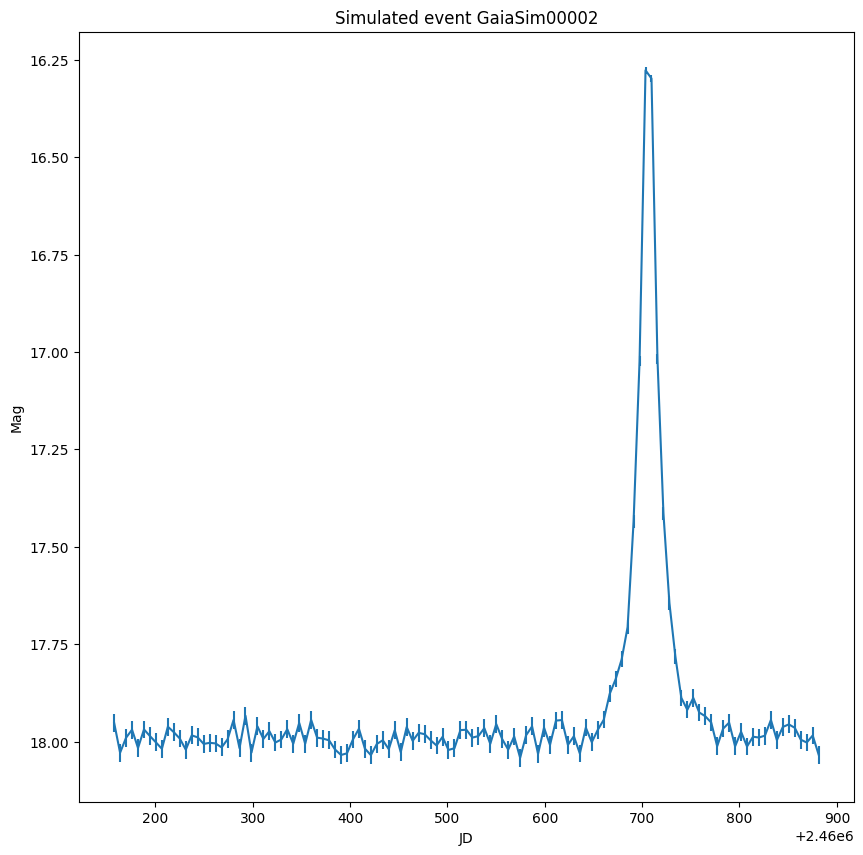

In [30]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = sim_gaia_lenses[event_number].telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
#xmin = float(events_table[event_number]['t0']) - 2*float(events_table[event_number]['te'])
#xmax = float(events_table[event_number]['t0']) + 2*float(events_table[event_number]['te'])
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [31]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

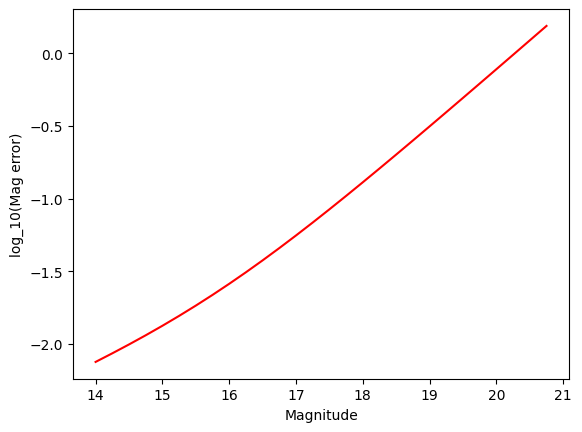

In [32]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [33]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [34]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [35]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated Gaia events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [43]:
def simulate_lco_observations(gaia_event, gaia_model, gaia_model_params, event_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # Take a back-up copy of the original event object, since if no LCO observations are possible, 
    # this will be returned unchanged:
    original_event = copy.deepcopy(gaia_event)
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    gaia_lc = gaia_lens.telescopes[0].lightcurve_magnitude
    if len(gaia_lc) == 0:
        return original_event
    
    mag_threshold = 17.5
    bright_data = np.where(gaia_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(gaia_lc[:,1].min())+' no LCO observations')
        return original_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = gaia_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = gaia_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(gaia_event.ra, gaia_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = gaia_lc[:,0].min()
    end_jd = gaia_lc[:,0].max()
    
    # Long timescale events - monitor at regular cadence throughout
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
        #print('Long timescale event, ts ', ts)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (gaia_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Monitor at moderate (few times per day) cadence between -tE to +tE:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = gaia_lc[idx,0].min()
            pre_peak_end = gaia_lc[idx,0].max()
            cadence = 6.0/24.0 # days - 4x per day
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = gaia_lc[:,0].min()
            pre_peak_end = gaia_lc[:,0].min()

        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = gaia_lc[idx,0].min()
            post_peak_end = gaia_lc[idx,0].max()
            cadence = 6.0/24.0 # days - 4x per day
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = gaia_lc[:,0].max()
            post_peak_end = gaia_lc[:,0].max()

        # Peak observations
        cadence = 1.0/24.0 # Monitor hourly
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)

            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()

            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)

        # Binary lens events only
        # Make additional high cadence observations of two simulated caustic crossing events, 
        # each of which lasts 6hrs
        if event_params['binary_lens'] == 1:
            cadence = 15.0/(60.0*24.0) # Observe every 15mins
            caustic1 = np.arange(pre_peak_end, (pre_peak_end+(6.0/24.0)), cadence)
            caustic2 = np.arange(post_peak_start, (post_peak_start+(6.0/24.0)), cadence)
            ts4 = np.concatenate((caustic1, caustic2))
        else:
            ts4 = np.array([])
        
        ts = np.concatenate((ts1,ts2,ts3,ts4))
        #print('Stellar event, ts ', ts1,ts2,ts3,ts4)

    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    #print('Post weathering ts ',ts)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return original_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for Gaia
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(gaia_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    #print('Here ',lc)
    tel = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    gaia_event.telescopes.append(tel)
    
    if parallax:
        gaia_model.event.compute_parallax_all_telescopes(gaia_model.parallax_model)
    
    #print('N telescopes: ',len())
    #tel = gaia_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = gaia_model.compute_pyLIMA_parameters(gaia_model_params)
    magnification = gaia_model.model_magnification(tel, pylima_parameters)
    A = gaia_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    #print('Added magnification: ',lc)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)[0]
    #print(idx)
    lc = np.delete(lc, idx, axis=0)
    #print('Removed '+str(len(idx))+' points because too faint')
    
    if len(lc) == 0:
        print('Event remains too faint for LCO observations even when magnified')
        return original_event
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    gaia_event.telescopes[1] = tel
    #print('Final lc ',gaia_event.telescopes[1].lightcurve_magnitude)
    
    return gaia_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [44]:
gaia_lens = sim_gaia_lenses[event_number]
gaia_lens_model = sim_gaia_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_gaia_event = simulate_lco_observations(gaia_lens, gaia_lens_model, lens_model_pars, events_table[event_number], visibility_data)

Event model parameters:  2460702.4797641393 0.3744687445908236 20.751565175323993 0.001647921608315464 -0.7691926935731206 0.013071970626769326
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID      HP                               location                                 baseline_mag            t0                 u0                 te                 rho                  piEN                piEE         nvisits binary_lens
------------ ----- ------------------------------------------------------------------ ------------------ ------------------ ------------------ ------------------ -------------------- ------------------- -------------------- ------- -----------
GaiaSim00002 38205 <SkyCoord (ICRS): (ra, dec) in deg\n    (265.78125, -33.51005556)> 17.990000000000002 2460702.4797641393 0.3744687445908236 20.751565175323993 0.001647921608315464 -0.7691926935731206 0.013071970626769326     119           1


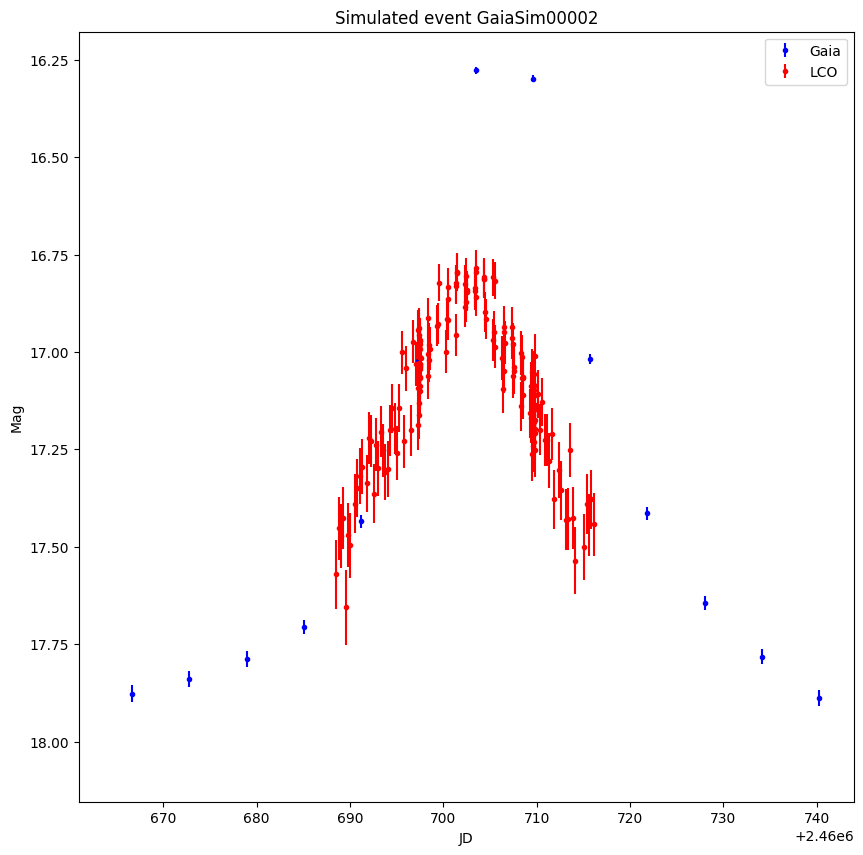

In [45]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_gaia_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='Gaia', fmt='b.')
lc2 = updated_gaia_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])
plt.savefig('GaiaSim00002_lc.png')

In [46]:
binary_number = binaries[2]
gaia_lens = sim_gaia_lenses[binary_number]
gaia_lens_model = sim_gaia_lens_models[binary_number]
lens_model_pars = sim_model_params[binary_number]

updated_gaia_event = simulate_lco_observations(gaia_lens, gaia_lens_model, lens_model_pars, events_table[binary_number], visibility_data)

Event model parameters:  2460307.7345204502 0.3058019855292142 20.962762081222984 0.01696583922628534 -0.05503232359695523 -0.12138283292323437
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID      HP                                 location                                  baseline_mag            t0                 u0                 te                 rho                 piEN                 piEE         nvisits binary_lens
------------ ----- --------------------------------------------------------------------- ------------------ ------------------ ------------------ ------------------ ------------------- -------------------- -------------------- ------- -----------
GaiaSim00383 41764 <SkyCoord (ICRS): (ra, dec) in deg\n    (260.40983333, -44.20152778)> 18.490000000000002 2460307.7345204502 0.3058019855292142 20.962762081222984 0.01696583922628534 -0.05503232359695523 -0.12138283292323437     157           1


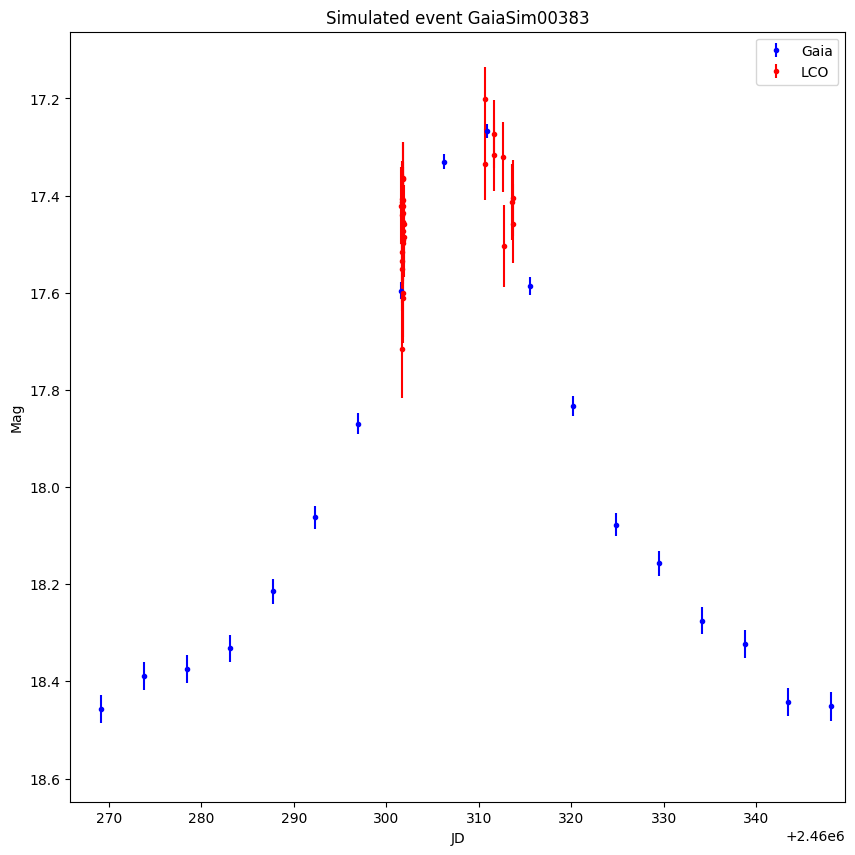

In [47]:
print(events_table[binary_number])
fig = plt.figure(1,(10,10))
lc1 = updated_gaia_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='Gaia', fmt='b.')
lc2 = updated_gaia_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin,xmax,ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[binary_number]['EventID'])
plt.savefig('GaiaSim00002_lc.png')

We can now simulate LCO observations for the full set of simulated Gaia events

In [48]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_gaia_event = simulate_lco_observations(sim_gaia_lenses[ievent], 
                                                   sim_gaia_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   events_table[ievent],
                                                   visibility_data)
    simulated_events_list.append(updated_gaia_event)

Event model parameters:  2460580.2908062916 0.24013586972675044 48.94054670125578 0.03383931251164614 -0.17942727901780592 0.03151465986800139
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460702.4797641393 0.3744687445908236 20.751565175323993 0.001647921608315464 -0.7691926935731206 0.013071970626769326
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460876.8867736543 0.4170640374175024 42.575951025221215 0.001183381446027294 -0.29106974423888554 -0.1943792073963215
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460278.064395372 0.48853614343401164 9.209158274948333 0.008074616105262883 0.410687695914732 -0.025654846616837916
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460229.623265006 0.25978823033588216 11.585479292348424 0.0335624472190979 1.4216102506556507 0.0062961164983649

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460204.9725007135 0.1503220684065938 19.950725104466777 0.033892303552699905 -0.746710895850671 -0.26890687092952587
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460712.803105089 -0.19780780426951963 72.88272735784469 0.012570567831298405 1.8187145492825327 -0.19353046448648892
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460578.7660954343 0.07450016974158018 101.70148212805088 0.004177193246114036 0.8784755955805059 0.11987231410464894
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460768.6594252726 -0.2019129566480353 16.185150815141473 0.012679230597544854 -0.5695053187002328 0.12023008838542346
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460567.300811222 0.43404293227779367 42.91777503462491 0.01910991328947108 -0.47323060769733666 -0.378284379065247
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460741.750876721 0.4207516993025744 29.176514281690125 0.024076622028294116 0.08188193945931943 0.2674589705411134
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460436.2007620446 0.22012928157099104 199.67348841122933 0.013193127040579677 -0.6941922810485788 0.2215786573574274
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460754.7703635255 -0.3397869259809059 48.429175461957655 0.020833887513812016 0.9301194276321532 0.17246490306033282
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460551.662454449 0.21152359936110848 66.94883456727554 0.0022271202302799036 2.0761915056753195 0.10294068994120105
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460799.196426099 0.1998341170745812 56.42443596551754 0.006314620443508999 -0.6876652890491601 -0.12213829788458536
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460605.7106791893 0.13404026890455567 26.44628415341833 0.02301627815052836 0.5023815666991901 -0.07425413585337137
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460182.5443360414 -0.13904288758543684 36.977885321670534 0.002910693103072813 1.0569561961268272 0.2485432918480566
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460846.441020874 0.4625906157311762 25.19519267461583 0.008845101062618295 -0.1300009851217685 -0.1072232972383868
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460540.802947631 -0.10377752126896506 46.26306084863312 0.012290942016802085 0.4894412428619216 0.0021226380968324757
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model paramete

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460621.2873323937 0.5977025113724689 35.02051521535991 0.03427300609624942 0.7443404194102294 0.09309218957856083
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460210.6670200955 0.05846596995751724 40.77380297438957 0.019873934287907243 0.5494826929245724 0.28463057966598143
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460658.5478147813 0.5890309542519943 42.873222210666256 0.007334225494676304 -0.7802074991320795 0.20219946043932024
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460433.7947644712 -0.29575362639149627 48.667702015700634 0.002385321646025732 -0.10338932434878362 0.15919059786938716
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model paramet

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460749.80205908 0.29727505922729813 18.38984453340076 0.003544704085885992 0.1959059711266374 -0.1888018290732336
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460551.7962179505 0.6214570330486092 29.07790070064838 0.02215612573100059 0.3345869531417678 0.25401942431355407
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460339.4881944545 0.27759306708804954 33.744480607970054 0.011926529607134482 -0.3930381959636888 -0.1513184373211387
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460290.3771818513 0.6231991932178607 48.966406173346286 0.0195651229474528 -0.27848143376382567 -0.13921267850120428
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460456.8362103207 0.3456848252711438 182.41038464983086 0.014197121715780027 -0.5295320514974036 -0.22707221544106967
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460322.353062504 0.17109806608815814 74.40345404333236 0.02694235934183853 -1.1732087887136422 -0.1324168492662864
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460324.399604336 0.04605419317817967 22.004133338743834 0.022611114578530135 0.20827279750054417 0.011666789908782109
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460304.926114728 -0.24643401294586023 16.589710411327395 0.007563121846619664 0.1251785909183323 0.533820828592724
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460450.7686691927 -0.2516700040879708 10.674309473564707 0.009249362630505673 1.0976642511900847 0.18205407752575947
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460280.5805202476 0.10890221232294181 6.4150317364272516 0.010687655768854498 -0.5210676412746758 0.15147639102068697
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460784.8113738783 0.13993733313128875 3.0731824739920373 0.03670435767587014 0.17940270388652535 -0.20469282110175752
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460572.8249545638 0.32502365521727317 105.75680448472559 0.007046790092230514 -0.3709734392529785 0.25614829921353244
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460760.377499558 -0.6955263397677087 7.999659252697115 0.006514154426292291 -0.1714724592509862 0.32300728406992674
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460707.126895203 0.058139692737898194 78.6238585762027 

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460339.49993972 0.04910456040941316 44.281702811028765 0.007832606920375329 1.33962983143319 -0.033033947245290636
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460322.0418280847 -0.04788835180701165 15.995060513376952 0.006684169822949619 0.7765451499358107 0.2401507118073143
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460444.004000226 -0.3508454808939486 18.508517953574433 0.014704827761058704 0.3682186624092281 0.12712443121695
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460710.6813954767 0.4541816257209702 20.06066339283327 0.018074765315772637 -0.11819034428509745 -0.011064674909853939
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460440.842730451 -0.20962275905633246 7.561896996432147 0.017

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460349.2659295513 -0.25176464576492685 34.21465798365234 0.005312803380697 0.013089668927488612 0.7521300717588403
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460578.7745105973 -0.16862233821999142 35.26135746587128 0.008359466766565704 -0.17956833527072114 -0.07793523260794655
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460877.1910786373 0.5984422324000306 31.141357889627443 0.02155568008007236 0.22150326433979553 -0.00038660601092951885
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460690.386155907 0.0016944086697140148 7.2834768432465244 0.0020138922573860116 0.3254754744692522 -0.01975782217150008
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460751.7286939775 -0.12167610399808917 35.46759506

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460158.5720610567 -0.16894046019738249 32.29206113717819 0.006018998433253695 1.0429266357322315 -0.397425233814797
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460320.5728568137 0.5323546562341287 11.814989551004265 0.013773919442325422 -0.5080012584852382 -0.2976458011426644
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460418.9076713175 0.0706650921823664 4.908052172213479 0.021291386916129782 0.3460539502854885 0.3306833234321
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460641.401212693 -0.10602014181381827 15.177066192904782 0.005789389144186722 1.2146297537940975 0.19359190170322899
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460631.9533396363 -0.014259465331352528 11.7512869124302 0.00570

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460371.511137952 0.710412522089864 20.317321992415053 0.008990200625488503 -0.12470822377090318 -0.4127055317509051
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460361.2864177185 0.0370634244359391 74.6291599067943 0.02662690945878289 -0.5665172341721583 -0.12183156727797434
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460398.5389194097 0.268377831181711 19.58199776951854 0.021464318306903832 0.7134764483536797 0.11087787138278349
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460465.129254893 0.8846033865424463 106.78331555316618 0.017112557234391194 -0.495557326892666 0.004147323290000039
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460462.9835415385 -0.5519835685059384 17.464664985912886 0.04597130516684971 0.17984031098934847 -0.06993280343252409
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460499.076729923 0.5072012339313471 23.685886509359875 0.014719505034438762 2.43725369756119 0.21205649228552811
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460878.672018182 0.24539177654101527 9.614231311305513 0.00549295844244206 0.7316056922786951 0.023375377146686017
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460625.167661694 0.10421898704458116 17.944734869378486 0.035680826690103605 -1.216243772033361 -0.013753069453106129
Parallax(Full

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460361.7034964794 -0.2605483277706737 13.723074881487786 0.005362653080833514 0.9554192465092501 0.19122272348704553
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460245.559156966 0.619524029154297 44.15976554637227 0.03498710530668995 -0.22819700227648632 -0.040530140970884
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460210.577775403 0.2958484808498397 77.0375946794475 0.0014547582998371477 0.3651163552603217 0.4184908094526728
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460781.0830136645 0.15944974568011427 230.2716053248148 0.006368973908860548 -0.27208352056690865 0.0698888813453186
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460537.744442876 0.4776214561307003 171.57597058548856 0.00849658

Event remains too faint for LCO observations even when magnified
Event model parameters:  2460587.482220983 0.4596504790255326 38.38051543840058 0.0010331328275693628 0.03881196961558997 0.3072346630913647
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460565.179294276 0.872991882179896 77.88774530399233 0.011211334954211304 0.47718561782302954 -0.21986218958142814
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460626.644329871 0.11940076198341606 63.758717061889335 0.014181387222886936 0.20434670894688653 0.07919546245320752
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460579.434353749 0.19401823368321483 24.454216024707392 0.007300982744867148 -0.6689638019549995 -0.27075760902833673
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model 

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460173.582349414 0.513980223335952 16.789264992405563 0.023925709334582698 0.37744214638199725 -0.07123794801363295
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460343.4285283247 0.32650856896492925 53.595496262619086 0.01530118041413128 0.43988205985209033 -0.1068114019361848
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460712.9615303325 0.66305479274702 12.186648937192956 0.026187335645993376 0.050091329484604125 -0.14902010939536564
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460589.9100776017 0.5647640041997091 37.83458629400642 0.018199064819176464 0.32993747490364533 0.30388782866138137
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too fa

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460840.2257054346 0.2121684234242287 11.527994093673904 0.007050673591251952 0.29273248925454526 0.1987499778648718
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460253.355698366 0.11636755527638545 18.274031719335245 0.005163917028433157 0.20602367387162657 0.19201660965687986
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460560.0266451226 -0.02811752238302609 72.42851733590767 0.029178585350844964 0.8953869477671497 0.22954823749576503
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460573.993684697 0.6483180359572807 172.74717335695433 0.009405706714770456 0.4644751976878483 0.40078753091033026
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameter

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460423.9445227976 0.8270306102076513 37.986707116579666 0.01280757336923362 -0.2750199149171124 -0.025576456143718694
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460173.2642716523 0.16758147166060405 174.8995479764394 0.015192820617627554 -0.7618824665161394 0.2904919934045314
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460356.08577701 0.30392499407967577 16.581201663009985 0.023702938438936158 -0.5835171673788442 0.09087464634979266
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460360.174586094 -0.48049799845704977 122.69656093762323 0.0034763660009211788 0.2841131749631919 0.0013917712731723944
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model para

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460508.667821264 0.48947985866918076 8.295508531197836 0.021571382172253496 -0.7626097646212138 0.3593154704643469
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460328.976142968 -0.2281660219604554 17.396887831192004 0.010607488014145353 -0.13828191947003493 0.07425434951163384
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460722.8553354656 0.670352261213268 94.7952833346806 0.018835039062806667 1.2946703065930962 -0.08206937050703858
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460247.48500463 0.5489774337443775 111.07223304323556 0.024471447535247055 -1.0939110228796676 0.31709416946984365
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters: 

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460438.4152474143 -0.6576426416061031 12.935438610435606 0.011887216768351049 -0.5198617538627888 0.4380513682125384
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460698.5926693925 0.28150885781470303 27.859909724110526 0.026711402488980636 1.2426210367075488 0.2656255910800789
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460369.313279088 0.3674404231999151 12.054737973919435 0.0121372251208225 -0.530335516311629 0.025169354624090298
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460371.491522476 0.39490655679024134 32.4395023897064 0.007655106950538306 0.14933568658857058 -0.21869005749400813
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460185.6796239577 0.4969883846799157 9.819707597404074 0.00881

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460193.4492941885 0.3192564090106611 6.52367259698032 0.011860421473322787 0.2902668109905453 -0.2921012995064062
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460535.1945381835 0.6070436143718944 12.96694725316026 0.020962357231999684 -0.8258795216864607 0.36981104257329633
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460569.465273952 -0.22130758646076462 18.555147587079546 0.017348570087262795 -0.28070658480427757 -0.23640561920255457
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460726.2333872537 -0.08634485310574957 24.777127670292003 0.003508924741596881 0.03099313494959613 0.2402589058665256
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460838.4977427903 -0.17268189036040152 10.347201282885226

Event model parameters:  2460474.650173184 -0.8304206434424747 25.249653391713746 0.0003060585669427563 -1.6258780360199332 0.3474277196004831
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460513.9841272505 0.19663265165202437 72.45951203260505 0.0034247877214387476 0.8640304830874541 -0.2057335312418477
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460691.694273193 0.04555812134717062 37.2834571774438 0.0002986982070324797 -0.048936099845882264 0.22180257223340977
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460416.8387919143 -0.2879979922859077 35.81760011982694 0.00024306407198392693 -0.799953094425689 0.16008103390264178
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460448.106445518 0.4515831251797793 27.87506779126319 0.00044428026645474024 -0.3628746638710649 -0.36319219950

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460303.920393942 0.10415337394001445 14.901289245590219 0.012588160738286653 1.606869866172653 -0.35669454535471096
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460338.2751492932 0.296143266946979 34.99087694012583 0.0076006426453341085 -0.3227910230631622 -0.0055480583307508866
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460423.8678913997 -0.0416139176616038 70.4565524144024 0.03278760669957121 1.1978763958558418 0.4319390730434297
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460541.5982218725 0.4553586785983289 12.275654075130639 0.019329716523937862 -1.172550317950955 -0.031393063982778545
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model paramete

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460610.420622901 0.6876725735100493 12.134734543648785 0.01131586578870089 0.39068945920059955 0.3539051407907421
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460234.415311974 0.17723261370106758 6.797467037040362 0.005521826812648732 -0.33552570803415643 -0.06711522835982167
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460480.4199193697 -0.056176689577785294 44.26890237186296 0.0009024414181445792 0.4116848147158566 0.04111394928349728
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460714.288375757 -0.2321668064088254 24.582484168481407 0.029053349702454004 -0.6353274604417765 -0.1113273149162591
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parame

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460711.791010587 -0.21018542158006795 20.263741083230464 0.007308731729700162 0.11804751813591313 0.10219012235304084
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460552.4970415095 0.5181042981608271 12.73120264745051 0.026456153061001277 -0.2515645744714472 0.22400436808071053
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event remains too faint for LCO observations even when magnified
Event model parameters:  2460276.978512519 -0.12727300340015182 83.66240646042674 0.02494154356094288 -0.09444715333958331 -0.050708134059605996
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460351.3561312035 0.061560554057721456 26.02709620231625 0.02908215534571284 -0.7034590714122604 0.2433088737435119
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460652.952418721 0.3303336702436097 5.782525464843714 0.

In [49]:
file_path = 'simulated_lco_lightcurves_gaia_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [50]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [51]:
def fit_event_model(event_params, model_type, horizons_table, gaia_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=gaia_lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel1.spacecraft_positions = spacecraft_positions
    
    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('Gaia')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['Gaia', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [52]:
e = simulated_events_list[binary_number]
gaia_lc = e.telescopes[0].lightcurve_magnitude
lco_lc = e.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[binary_number])
(fit_params, e) = fit_event_model(events_table[binary_number], model_type, horizons_table, gaia_lc, lco_lc)

  EventID      HP                                 location                                  baseline_mag            t0                 u0                 te                 rho                 piEN                 piEE         nvisits binary_lens
------------ ----- --------------------------------------------------------------------- ------------------ ------------------ ------------------ ------------------ ------------------- -------------------- -------------------- ------- -----------
GaiaSim00383 41764 <SkyCoord (ICRS): (ra, dec) in deg\n    (260.40983333, -44.20152778)> 18.490000000000002 2460307.7345204502 0.3058019855292142 20.962762081222984 0.01696583922628534 -0.05503232359695523 -0.12138283292323437     157           1
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00383, with model FSPL and method DE
check_event  : Everything

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [53]:
e = simulated_events_list[0]
gaia_lc = e.telescopes[0].lightcurve_magnitude
lco_lc = e.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[0])
(fit_params, e) = fit_event_model(events_table[0], model_type, horizons_table, gaia_lc, lco_lc)

  EventID      HP                               location                                 baseline_mag            t0                  u0                 te                rho                 piEN                 piEE        nvisits binary_lens
------------ ----- ------------------------------------------------------------------ ------------------ ------------------ ------------------- ----------------- ------------------- -------------------- ------------------- ------- -----------
GaiaSim00001 16462 <SkyCoord (ICRS): (ra, dec) in deg\n    (290.390625, 19.47121944)> 19.490000000000002 2460580.2908062916 0.24013586972675044 48.94054670125578 0.03383931251164614 -0.17942727901780592 0.03151465986800139     218           0
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00001, with model FSPL and method DE
check_event  : Everything looks fine,

In [54]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        gaia_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        (fit_params, e) = fit_event_model(events_table[ievent], model_type, horizons_table, gaia_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 826.19
DE converge to objective function : f(x) =  826.1659464889465
DE converge to parameters : =  ['2460580.2911062916' '0.23983586972675044' '48.940846701255786'
 '0.03413931251164614' '-0.1797272790178059' '0.031814659868001395']
trust_region_reflective  : TRF fit SUCCESS
[2460580.2911062855, 0.23983586972675272, 48.940846701255744, 0.03413931251164353, -0.17972727901780408, 0.031814659867999404, 1457.4218466304687, -7.332005209340927, 3665.386652740079, 129.92551068929424, 826.165946757029]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460580.29110

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00007, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 571.966
differential_evolution step 2: f(x)= 571.949
DE converge to objective function : f(x) =  571.7197995854332
DE converge to parameters : =  ['2460391.1027123854' '0.06042617147654963' '16.499275012394197'
 '0.010226024310589107' '0.4089066663378032' '0.30421447487903913']
trust_region_reflective  : TRF fit SUCCESS
[2460391.102712386, 0.060426171476549634, 16.4992750123942, 0.010226024310589105, 0.40890666633780326, 0.3042144748790392, 584.9887188219903, -8.946005972835925, 3668.1750125187405, 124.13181993336647, 571.7197997891388]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460391.102712386, 0.060426171476549634, 16.4992750123942, 0.010226024310589105, 0.40890666633780326, 0.3042144748790392, 584.9887188

differential_evolution step 1: f(x)= 263.54
DE converge to objective function : f(x) =  263.51180234601054
DE converge to parameters : =  ['2460182.5724565177' '0.25834539667080403' '11.688194092551532'
 '0.0222499344000323' '0.30366433772151685' '-0.34710954015527484']
trust_region_reflective  : TRF fit SUCCESS
[2460182.5724565173, 0.25834539667081563, 11.68819409255164, 0.02224993439987229, 0.3036643377215233, -0.3471095401552803, 36304.87035864606, 343.5136948505098, 3781.6658387256866, -205.70571514870258, 263.5118023984728]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460182.5724565173, 0.25834539667081563, 11.68819409255164, 0.02224993439987229, 0.3036643377215233, -0.3471095401552803, 36304.87035864606, 343.5136948505098, 3781.6658387256866, -205.70571514870258, 263.5118023984728]
t0: Fitted value=2460182.5724565173+/-0.03899485062212777 expected value=2460182.5721565178
t0: delta=0.00029999949038028717 prop_delta

differential_evolution step 1: f(x)= 541.45
DE converge to objective function : f(x) =  541.3665852426236
DE converge to parameters : =  ['2460577.1669695764' '0.23732565819013227' '37.80285862800631'
 '0.01448924327622443' '1.1075061475859136' '0.3813354185341617']
trust_region_reflective  : TRF fit SUCCESS
[2460577.166969577, 0.23732565819013243, 37.80285862800632, 0.014489243276224292, 1.1075061475859138, 0.38133541853416175, 5800.911151526462, -8.021895977670615, 3696.4120357685256, -26.52234391732574, 541.3665852585422]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460577.166969577, 0.23732565819013243, 37.80285862800632, 0.014489243276224292, 1.1075061475859138, 0.38133541853416175, 5800.911151526462, -8.021895977670615, 3696.4120357685256, -26.52234391732574, 541.3665852585422]
t0: Fitted value=2460577.166969577+/-0.07088281830399065 expected value=2460577.1672695763
t0: delta=0.00029999949038028717 prop_delta=1.21

differential_evolution step 1: f(x)= 555.441
DE converge to objective function : f(x) =  555.4375197726561
DE converge to parameters : =  ['2460714.9129556874' '-0.19802818392260074' '58.86875939876044'
 '0.0016648205457803213' '-0.5715020708624055' '0.15786164020770704']
trust_region_reflective  : TRF fit SUCCESS
[2460714.9127106457, -0.1980281839225879, 58.868759392882446, 0.0016648205457803213, -0.5715020707632883, 0.1578616403042608, 932.3793442958478, -15.765297674824875, 3707.4410928069256, 46.263807474104404, 555.4377662597226]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460714.9127106457, -0.1980281839225879, 58.868759392882446, 0.0016648205457803213, -0.5715020707632883, 0.1578616403042608, 932.3793442958478, -15.765297674824875, 3707.4410928069256, 46.263807474104404, 555.4377662597226]
t0: Fitted value=2460714.9127106457+/-0.08302811584951153 expected value=2460714.9126556874
t0: delta=5.4958276450634e-05 pro

differential_evolution step 1: f(x)= 192.086
DE converge to objective function : f(x) =  192.0669757861691
DE converge to parameters : =  ['2460633.5394315775' '-0.11712572480015038' '26.381399603867404'
 '0.015898254235771663' '-0.7947312981211947' '-0.1913006655815435']
trust_region_reflective  : TRF fit SUCCESS
[2460633.539431577, -0.11712572480015039, 26.381399603867408, 0.015898254235771667, -0.7947312981211946, -0.19130066558154346, 14653.742094018828, -71.92337676460215, 3661.2817905451307, 229.79860900380524, 192.06697579363595]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460633.539431577, -0.11712572480015039, 26.381399603867408, 0.015898254235771667, -0.7947312981211946, -0.19130066558154346, 14653.742094018828, -71.92337676460215, 3661.2817905451307, 229.79860900380524, 192.06697579363595]
t0: Fitted value=2460633.539431577+/-0.047476391816876816 expected value=2460633.5391315776
t0: delta=0.00029999949038028

differential_evolution step 1: f(x)= 436.948
differential_evolution step 2: f(x)= 436.948
differential_evolution step 3: f(x)= 436.948
differential_evolution step 4: f(x)= 436.685
differential_evolution step 5: f(x)= 436.685
differential_evolution step 6: f(x)= 436.685
differential_evolution step 7: f(x)= 436.685
differential_evolution step 8: f(x)= 436.685
differential_evolution step 9: f(x)= 436.685
differential_evolution step 10: f(x)= 436.685
differential_evolution step 11: f(x)= 436.685
differential_evolution step 12: f(x)= 436.685
differential_evolution step 13: f(x)= 436.685
differential_evolution step 14: f(x)= 436.666
differential_evolution step 15: f(x)= 436.666
DE converge to objective function : f(x) =  436.53114658836506
DE converge to parameters : =  ['2460240.536721963' '-0.016079515925063837' '52.204445907101416'
 '0.023984074674044332' '1.1401267622491824' '0.1503795022077739']
trust_region_reflective  : TRF fit SUCCESS
[2460240.5367219625, -0.0160795143241155, 52.2044

differential_evolution step 1: f(x)= 595.096
DE converge to objective function : f(x) =  594.9474527041159
DE converge to parameters : =  ['2460736.1503849067' '-0.08791601577098174' '17.061465055924447'
 '0.02401045865829149' '1.8289617397559137' '0.3856683891405479']
trust_region_reflective  : TRF fit SUCCESS
[2460736.150384906, -0.08791593858822193, 17.06146505604082, 0.024010458658291486, 1.8289618377299695, 0.38566838914054796, 36530.02784304374, 106.43857496171806, 3737.021363713203, -215.00016022478223, 594.9474527202523]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460736.150384906, -0.08791593858822193, 17.06146505604082, 0.024010458658291486, 1.8289618377299695, 0.38566838914054796, 36530.02784304374, 106.43857496171806, 3737.021363713203, -215.00016022478223, 594.9474527202523]
t0: Fitted value=2460736.150384906+/-0.007716158709565099 expected value=2460736.1500849067
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 1: f(x)= 396.853
DE converge to objective function : f(x) =  396.8404723934452
DE converge to parameters : =  ['2460768.6591252727' '-0.2016129566480353' '16.184850815141473'
 '0.012979230597544853' '-0.5692053187002328' '0.11993008838542346']
trust_region_reflective  : TRF fit SUCCESS
[2460768.659125273, -0.2016129566480361, 16.184850815141477, 0.012979230597543816, -0.5692053187002333, 0.11993008838542348, 3665.5481537657383, 2.9243991086295336, 3672.849610339582, 84.88466039784092, 396.8404724449853]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460768.659125273, -0.2016129566480361, 16.184850815141477, 0.012979230597543816, -0.5692053187002333, 0.11993008838542348, 3665.5481537657383, 2.9243991086295336, 3672.849610339582, 84.88466039784092, 396.8404724449853]
t0: Fitted value=2460768.659125273+/-0.028979693390675156 expected value=2460768.6594252726
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00053, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 382.767
DE converge to objective function : f(x) =  382.7351460671383
DE converge to parameters : =  ['2460414.5364858746' '0.10569889075774255' '15.493908112291889'
 '0.012094903806956965' '1.6511066794572922' '-0.24977574026451344']
trust_region_reflective  : TRF fit SUCCESS
[2460414.5364905936, 0.10569893846621113, 15.493908113736333, 0.01209490390665271, 1.6511066795271545, -0.24977574017396362, 9187.497183420955, 11.971464586473974, 3690.157583127114, 25.05609342147097, 382.73626327696945]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460414.5364905936, 0.10569893846621113, 15.493908113736333, 0.01209490390665271, 1.6511066795271545, -0.24977574017396362, 9187.497183420955, 11.971464586473974, 3690.15758312

differential_evolution step 1: f(x)= 231.107
DE converge to objective function : f(x) =  231.07323776706258
DE converge to parameters : =  ['2460859.303444717' '0.3888887183247968' '183.2668535186762'
 '0.03561131210061797' '0.6681534112581047' '0.05412023031929445']
trust_region_reflective  : TRF fit SUCCESS
[2460859.3034447166, 0.38888871832479677, 183.26685351867619, 0.03561131210061798, 0.6681534112581048, 0.05412023031929446, 3705.5528091997226, -48.79730590344122, 7.548078238828193e-05, 9658.007334200265, 231.55300084535583]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460859.3034447166, 0.38888871832479677, 183.26685351867619, 0.03561131210061798, 0.6681534112581048, 0.05412023031929446, 3705.5528091997226, -48.79730590344122, 7.548078238828193e-05, 9658.007334200265, 231.55300084535583]
t0: Fitted value=2460859.3034447166+/-8.341984310573835 expected value=2460859.303144717
t0: delta=0.00029999949038028717 prop_d

trust_region_reflective  : TRF fit SUCCESS
[2460697.155205533, 0.026839217031068237, 41.66227719619878, 0.012213421290942652, 0.5401322451442843, -0.17718862495316803, 926.1962230857533, -19.663590202759988, 3703.672391837051, 4.8048236852819874, 208.96767385252707]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460697.155205533, 0.026839217031068237, 41.66227719619878, 0.012213421290942652, 0.5401322451442843, -0.17718862495316803, 926.1962230857533, -19.663590202759988, 3703.672391837051, 4.8048236852819874, 208.96767385252707]
t0: Fitted value=2460697.155205533+/-0.007847349353751674 expected value=2460697.1555055324
t0: delta=0.00029999949038028717 prop_delta=1.219164616454618e-08% within_range? True
te: Fitted value=41.66227719619878+/-3.552667936145311 expected value=41.662577196198775
te: delta=0.0002999999999957481 prop_delta=0.0007200706729758418% within_range? True
u0: Fitted value=0.026839217031068237+/-0.017705

differential_evolution step 1: f(x)= 197.279
DE converge to objective function : f(x) =  197.26250701009167
DE converge to parameters : =  ['2460194.2629861766' '0.23789557177859114' '5.455451591416191'
 '0.007412823372985237' '-0.6221565286375454' '-0.2752095978850825']
trust_region_reflective  : TRF fit SUCCESS
[2460194.262986418, 0.23789557177858933, 5.455451591416189, 0.007412823372987202, -0.6221565286375477, -0.2752095978850806, 1427.5123107375832, 22.78166279859468, 3712.951628293172, -99.30041205970532, 197.2625094618377]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460194.262986418, 0.23789557177858933, 5.455451591416189, 0.007412823372987202, -0.6221565286375477, -0.2752095978850806, 1427.5123107375832, 22.78166279859468, 3712.951628293172, -99.30041205970532, 197.2625094618377]
t0: Fitted value=2460194.262986418+/-0.022073803081111856 expected value=2460194.2632861766
t0: delta=0.00029975874349474907 prop_delt

differential_evolution step 1: f(x)= 322.656
DE converge to objective function : f(x) =  322.619253171822
DE converge to parameters : =  ['2460288.979665402' '-0.22022616314582827' '13.727787807625758'
 '0.013546343989342974' '-1.182579687751387' '0.16463670797117191']
trust_region_reflective  : TRF fit SUCCESS
[2460288.9796653404, -0.22022616314581284, 13.72778780762554, 0.013546343989358474, -1.1825796877513681, 0.16463670797117183, 579076.9761650497, 1714.404650023342, 3759.0205327479166, -405.6629984653671, 322.61925439152037]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460288.9796653404, -0.22022616314581284, 13.72778780762554, 0.013546343989358474, -1.1825796877513681, 0.16463670797117183, 579076.9761650497, 1714.404650023342, 3759.0205327479166, -405.6629984653671, 322.61925439152037]
t0: Fitted value=2460288.9796653404+/-0.04998918827249273 expected value=2460288.979365402
t0: delta=0.00029993848875164986 prop_d

differential_evolution step 1: f(x)= 199.688
DE converge to objective function : f(x) =  199.68345963319425
DE converge to parameters : =  ['2460436.200665493' '0.22029566478930995' '199.6736895054553'
 '0.013051567120900049' '-0.6938922810485788' '0.22175217385557583']
trust_region_reflective  : TRF fit SUCCESS
[2460436.2007080885, 0.22029566478930995, 199.6736895054553, 0.013051567120900049, -0.6938922811485788, 0.22175217385557583, 14577.432436004952, -8.28783092367752, 3375.5590063793306, 1078.9137305389027, 199.68351766351208]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460436.2007080885, 0.22029566478930995, 199.6736895054553, 0.013051567120900049, -0.6938922811485788, 0.22175217385557583, 14577.432436004952, -8.28783092367752, 3375.5590063793306, 1078.9137305389027, 199.68351766351208]
t0: Fitted value=2460436.2007080885+/-1.3548091751650246 expected value=2460436.2007620446
t0: delta=5.395617336034775e-05 prop_d

differential_evolution step 1: f(x)= 454.546
DE converge to objective function : f(x) =  454.48408604583176
DE converge to parameters : =  ['2460194.0195587855' '0.04956882840963751' '31.10838206728915'
 '0.014495182911592037' '0.6301731594841316' '0.3732220566459558']
trust_region_reflective  : TRF fit SUCCESS
[2460194.019558787, 0.04956883496092871, 31.108382067289153, 0.014495182911592039, 0.6301731594841317, 0.37322205664595587, 2299.4149152174045, 8.871215122978278, 3699.276051514607, -41.58260775139431, 454.4840863886946]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460194.019558787, 0.04956883496092871, 31.108382067289153, 0.014495182911592039, 0.6301731594841317, 0.37322205664595587, 2299.4149152174045, 8.871215122978278, 3699.276051514607, -41.58260775139431, 454.4840863886946]
t0: Fitted value=2460194.019558787+/-0.006325036800406134 expected value=2460194.0198587854
t0: delta=0.00029999855905771255 prop_delta=

differential_evolution step 2: f(x)= 630.528
DE converge to objective function : f(x) =  630.1104438928216
DE converge to parameters : =  ['2460340.2151356447' '0.03108416173507834' '33.257213344368445'
 '0.014139684124310877' '-0.4269250966403749' '0.2637403913037822']
trust_region_reflective  : TRF fit SUCCESS
[2460340.215135644, 0.031084169011837005, 33.25721334436845, 0.014139684124310829, -0.426925096640375, 0.26374039130378213, 3670.6413530732225, -0.1975378101637712, 3694.3810513489652, -5.245674371871186, 630.110444218885]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460340.215135644, 0.031084169011837005, 33.25721334436845, 0.014139684124310829, -0.426925096640375, 0.26374039130378213, 3670.6413530732225, -0.1975378101637712, 3694.3810513489652, -5.245674371871186, 630.110444218885]
t0: Fitted value=2460340.215135644+/-0.0028764455225169885 expected value=2460340.2148356447
t0: delta=0.00029999949038028717 prop_

differential_evolution step 1: f(x)= 1146
DE converge to objective function : f(x) =  1145.9417144201254
DE converge to parameters : =  ['2460752.8645892506' '0.22630924719744075' '74.54444263181242'
 '0.013915937488931902' '0.5574790214217601' '-0.05140288835745088']
trust_region_reflective  : TRF fit SUCCESS
[2460752.864589256, 0.22630924549101408, 74.54444263181239, 0.013915937488931288, 0.5574790214217599, -0.05140288835745312, 1454501.931910423, 4398.6083651115105, 3653.9339309125216, 138.9942362460779, 1145.9417144615047]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460752.864589256, 0.22630924549101408, 74.54444263181239, 0.013915937488931288, 0.5574790214217599, -0.05140288835745312, 1454501.931910423, 4398.6083651115105, 3653.9339309125216, 138.9942362460779, 1145.9417144615047]
t0: Fitted value=2460752.864589256+/-0.07138793898979748 expected value=2460752.8648892506
t0: delta=0.0002999948337674141 prop_delta=1

differential_evolution step 3: f(x)= 444.932
differential_evolution step 4: f(x)= 444.927
DE converge to objective function : f(x) =  444.8808575653713
DE converge to parameters : =  ['2460411.8025320917' '-0.023993134734707454' '20.246585094865836'
 '0.005572683362732532' '0.2543904724200213' '0.011412257738790338']
trust_region_reflective  : TRF fit SUCCESS
[2460411.8022882375, -0.023994332094688233, 20.246585094580993, 0.005572619214365865, 0.2543904725195674, 0.01141225783874025, 580.9090389436583, -11.918712107844879, 3703.19287239951, -71.77831440249747, 444.93309241836636]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460411.8022882375, -0.023994332094688233, 20.246585094580993, 0.005572619214365865, 0.2543904725195674, 0.01141225783874025, 580.9090389436583, -11.918712107844879, 3703.19287239951, -71.77831440249747, 444.93309241836636]
t0: Fitted value=2460411.8022882375+/-0.0018423012633418828 expected value=2460

differential_evolution step 1: f(x)= 213.798
DE converge to objective function : f(x) =  213.65870516322616
DE converge to parameters : =  ['2460726.622414162' '0.25083601379755793' '8.3120431666365'
 '0.0039010422831335673' '0.6490246304107941' '-0.4054952906076304']
trust_region_reflective  : TRF fit SUCCESS
[2460726.6224141615, 0.250836013797558, 8.312043166636501, 0.00390104228313357, 0.6490246304107942, -0.40549529060763034, 230150.359650275, 1028.0922751329692, 3462.918863789618, 812.3649872645033, 213.65870524555194]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460726.6224141615, 0.250836013797558, 8.312043166636501, 0.00390104228313357, 0.6490246304107942, -0.40549529060763034, 230150.359650275, 1028.0922751329692, 3462.918863789618, 812.3649872645033, 213.65870524555194]
t0: Fitted value=2460726.6224141615+/-0.04861781604733031 expected value=2460726.622114162
t0: delta=0.00029999949038028717 prop_delta=1.219150

differential_evolution step 1: f(x)= 178.394
DE converge to objective function : f(x) =  178.38873914127268
DE converge to parameters : =  ['2460567.9099845733' '0.20776189680694604' '5.968873890131204'
 '0.015636546962950772' '0.0803355168955518' '-0.03296856963182779']
trust_region_reflective  : TRF fit SUCCESS
[2460567.9099847055, 0.207761896806946, 5.968657596842905, 0.015636546962951088, 0.08033551689556594, -0.03296856963186894, 956.8610792771487, -44.73446402004231, 3535.4948194386466, 897.4393344700189, 178.3887461674819]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460567.9099847055, 0.207761896806946, 5.968657596842905, 0.015636546962951088, 0.08033551689556594, -0.03296856963186894, 956.8610792771487, -44.73446402004231, 3535.4948194386466, 897.4393344700189, 178.3887461674819]
t0: Fitted value=2460567.9099847055+/-0.022837285896700327 expected value=2460567.910284573
t0: delta=0.0002998677082359791 prop_delta

differential_evolution step 1: f(x)= 347.707
DE converge to objective function : f(x) =  347.5967596543617
DE converge to parameters : =  ['2460636.9176676264' '-0.051844638866143704' '36.88375138411149'
 '0.004378856188916523' '-1.0891043308557025' '-0.10526481033215912']
trust_region_reflective  : TRF fit SUCCESS
[2460636.9176675603, -0.05184463886615032, 36.883751384112, 0.004378856188914023, -1.0891043308557247, -0.10526481033211921, 145366.81766159963, 543.9918384509022, 3641.9950810879986, 311.07644743017494, 347.5967655896055]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460636.9176675603, -0.05184463886615032, 36.883751384112, 0.004378856188914023, -1.0891043308557247, -0.10526481033211921, 145366.81766159963, 543.9918384509022, 3641.9950810879986, 311.07644743017494, 347.5967655896055]
t0: Fitted value=2460636.9176675603+/-0.02686072459811844 expected value=2460636.9173676264
t0: delta=0.0002999338321387768 prop

differential_evolution step 2: f(x)= 258.353
differential_evolution step 3: f(x)= 258.353
differential_evolution step 4: f(x)= 258.353
differential_evolution step 5: f(x)= 258.353
differential_evolution step 6: f(x)= 258.353
differential_evolution step 7: f(x)= 258.353
differential_evolution step 8: f(x)= 258.353
DE converge to objective function : f(x) =  258.17300358505906
DE converge to parameters : =  ['2460508.610627994' '0.012175053081645733' '11.123922147671255'
 '0.0072848118526478885' '0.270764756486328' '-0.06525498356197695']
trust_region_reflective  : TRF fit SUCCESS
[2460508.6106279935, 0.012175057862394395, 11.123922147671253, 0.007284811790017523, 0.2707647564863279, -0.06525498356197693, 2382.913874257564, -83.14676758764872, 3723.6748274369556, -292.2827011514998, 258.1730057332502]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460508.6106279935, 0.012175057862394395, 11.123922147671253, 0.007284811790017

differential_evolution step 1: f(x)= 398.355
DE converge to objective function : f(x) =  398.24280558723717
DE converge to parameters : =  ['2460805.806475589' '0.10201737652151703' '18.06268354792555'
 '0.025167904219061864' '0.621968037944481' '0.17076775009710263']
trust_region_reflective  : TRF fit SUCCESS
[2460805.8064755895, 0.10201737652151702, 18.062683547925545, 0.025167904219061867, 0.6219680379444809, 0.1707677500971026, 2346.41216026718, -33.45382791784995, 3705.06190502454, 77.01278666613601, 398.24280563722897]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460805.8064755895, 0.10201737652151702, 18.062683547925545, 0.025167904219061867, 0.6219680379444809, 0.1707677500971026, 2346.41216026718, -33.45382791784995, 3705.06190502454, 77.01278666613601, 398.24280563722897]
t0: Fitted value=2460805.8064755895+/-0.016149499133565157 expected value=2460805.806775589
t0: delta=0.00029999949038028717 prop_delta=1.219

DE converge to objective function : f(x) =  587.7001459559978
DE converge to parameters : =  ['2460362.5939805103' '-0.2958841724749033' '52.462788443850755'
 '0.015515625734620028' '1.075725341892868' '-0.023541813047508575']
trust_region_reflective  : TRF fit SUCCESS
[2460362.5939796595, -0.29588414620127496, 52.46278844463838, 0.015515625730806417, 1.0757253418938821, -0.023541813045037243, 2314.972873367137, -5.076871159653253, 3425.4504315976615, 819.167558869473, 587.7001500181572]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460362.5939796595, -0.29588414620127496, 52.46278844463838, 0.015515625730806417, 1.0757253418938821, -0.023541813045037243, 2314.972873367137, -5.076871159653253, 3425.4504315976615, 819.167558869473, 587.7001500181572]
t0: Fitted value=2460362.5939796595+/-0.2290653398355218 expected value=2460362.5936805103
t0: delta=0.00029914919286966324 prop_delta=1.2158744147632297e-08% within_range? Tr

differential_evolution step 1: f(x)= 513.314
DE converge to objective function : f(x) =  513.0636002457315
DE converge to parameters : =  ['2460205.8937425762' '0.14734960323974583' '37.400933024720246'
 '0.025367331416027913' '0.516340100437779' '-0.23750826014624582']
trust_region_reflective  : TRF fit SUCCESS
[2460205.893742576, 0.1473496032397458, 37.40093302472025, 0.025367331416027934, 0.5163401004377791, -0.2375082601462458, 36727.07448120064, -50.97397208373355, 3695.252962319073, 8.885549415401464, 513.0636002758212]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460205.893742576, 0.1473496032397458, 37.40093302472025, 0.025367331416027934, 0.5163401004377791, -0.2375082601462458, 36727.07448120064, -50.97397208373355, 3695.252962319073, 8.885549415401464, 513.0636002758212]
t0: Fitted value=2460205.893742576+/-0.03280626515952723 expected value=2460205.8934425763
t0: delta=0.00029999949038028717 prop_delta=1.2194

differential_evolution step 1: f(x)= 320.149
DE converge to objective function : f(x) =  320.14125534433083
DE converge to parameters : =  ['2460381.142746003' '0.26079371688431924' '20.11835824205797'
 '0.003310913971693999' '0.6904455409761432' '-0.3191232275626494']
trust_region_reflective  : TRF fit SUCCESS
[2460381.142745987, 0.26079371688431935, 20.118358242057973, 0.003310913971693984, 0.6904455409761431, -0.31912322756264944, 2365.8179458505106, -61.52165433707472, 3757.0963986939532, -196.47623677550095, 320.1412554011345]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460381.142745987, 0.26079371688431935, 20.118358242057973, 0.003310913971693984, 0.6904455409761431, -0.31912322756264944, 2365.8179458505106, -61.52165433707472, 3757.0963986939532, -196.47623677550095, 320.1412554011345]
t0: Fitted value=2460381.142745987+/-0.06880966378090289 expected value=2460381.142446003
t0: delta=0.000299984123557806 prop_de

differential_evolution step 1: f(x)= 472.747
DE converge to objective function : f(x) =  472.7430323830887
DE converge to parameters : =  ['2460495.36802734' '0.28699303363608464' '4.040582085591552'
 '0.0016087365060582772' '0.9711122917275494' '-0.19621884584854202']
trust_region_reflective  : TRF fit SUCCESS
[2460495.367993961, 0.28699303363608347, 4.0405820852634395, 0.0016087365060582772, 0.9711122916356809, -0.19621884576978454, 1231.9374033734023, 218.29147461588443, 3625.2952163177483, 252.38549485201796, 472.74408568283525]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460495.367993961, 0.28699303363608347, 4.0405820852634395, 0.0016087365060582772, 0.9711122916356809, -0.19621884576978454, 1231.9374033734023, 218.29147461588443, 3625.2952163177483, 252.38549485201796, 472.74408568283525]
t0: Fitted value=2460495.367993961+/-0.028212728124345415 expected val

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00162, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1173.59
DE converge to objective function : f(x) =  1173.4892299471624
DE converge to parameters : =  ['2460565.6052061804' '0.07681829588751199' '78.18976678083666'
 '0.004172780576106334' '-0.3066077071704597' '-0.042912913235373246']
trust_region_reflective  : TRF fit SUCCESS
[2460565.6052059485, 0.07682447424442386, 78.18959736607233, 0.004709225303983369, -0.30660770717049696, -0.04291291323538525, 3651.245325576067, 4.398338322419487, 3688.011060970566, 29.486189859249713, 1173.485556231595]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460565.6052059485, 0.07682447424442386, 78.18959736607233, 0.004709225303983369, -0.30660770717049696, -0.042912913

trust_region_reflective  : TRF fit SUCCESS
[2460658.2246872983, 0.22968609127040301, 31.971026024393353, 0.0057152458233987865, -0.6188876767686633, -0.16041463645953222, 9175.598082126922, 33.08621235619471, 3370.1526199737095, 784.0379220165394, 201.26465128990745]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460658.2246872983, 0.22968609127040301, 31.971026024393353, 0.0057152458233987865, -0.6188876767686633, -0.16041463645953222, 9175.598082126922, 33.08621235619471, 3370.1526199737095, 784.0379220165394, 201.26465128990745]
t0: Fitted value=2460658.2246872983+/-0.36353130530086314 expected value=2460658.224987298
t0: delta=0.00029999949038028717 prop_delta=1.2191839050782268e-08% within_range? True
te: Fitted value=31.971026024393353+/-1.679608590942695 expected value=31.97132602439335
te: delta=0.0002999999999957481 prop_delta=0.0009383408112846348% within_range? True
u0: Fitted value=0.22968609127040301+/-0.15153

differential_evolution step 1: f(x)= 312.558
DE converge to objective function : f(x) =  312.5335750576779
DE converge to parameters : =  ['2460670.8708543126' '-0.052389742492136786' '9.747726078762073'
 '0.0021908466840314805' '-0.2574349901313558' '0.3452885517356946']
trust_region_reflective  : TRF fit SUCCESS
[2460670.870854313, -0.05238974249213761, 9.747726078762074, 0.002190846684030851, -0.25743499013135573, 0.34528855173569467, 2365.695349528304, -59.22326915526029, 3669.9437425608908, 188.68541912879337, 312.5335755560578]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460670.870854313, -0.05238974249213761, 9.747726078762074, 0.002190846684030851, -0.25743499013135573, 0.34528855173569467, 2365.695349528304, -59.22326915526029, 3669.9437425608908, 188.68541912879337, 312.5335755560578]
t0: Fitted value=2460670.870854313+/-0.0053824336936556996 expected value=2460670.8711543125
t0: delta=0.00029999949038028717 p

DE converge to objective function : f(x) =  973.9847615062926
DE converge to parameters : =  ['2460569.990188102' '0.29237104908287387' '88.94233093259483'
 '0.0071059451740415995' '-0.2541859306553601' '0.04234578049768552']
trust_region_reflective  : TRF fit SUCCESS
[2460569.990188604, 0.2923710490830528, 88.94233093260937, 0.0071059451739740155, -0.254185928797521, 0.04234578049748896, 5789.773553874508, 17.58387184046793, 3803.401799732721, -331.24744801821635, 973.9847713054958]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460569.990188604, 0.2923710490830528, 88.94233093260937, 0.0071059451739740155, -0.254185928797521, 0.04234578049748896, 5789.773553874508, 17.58387184046793, 3803.401799732721, -331.24744801821635, 973.9847713054958]
t0: Fitted value=2460569.990188604+/-0.15918159293138728 expected value=2460569.9904881017
t0: delta=0.00029949750751256943 prop_delta=1.2171875161866795e-08% within_range? True
te: 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00182, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 213.333
DE converge to objective function : f(x) =  213.1962017689836
DE converge to parameters : =  ['2460271.704951514' '0.12246641991997065' '37.2032847791625'
 '0.009019721057826668' '0.27550473755930693' '0.2897236256429675']
trust_region_reflective  : TRF fit SUCCESS
[2460271.70495152, 0.12246639535084883, 37.203284779162395, 0.009019721057826963, 0.27550473755930394, 0.28972362564296633, 2315.2052884859095, 0.7956164394816714, 3738.0709675826856, -189.89199732937405, 213.1962023521464]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460271.70495152, 0.12246639535084883, 37.203284779162395, 0.009019721057826963, 0.27550473755930394, 0.28972362564296633

differential_evolution step 1: f(x)= 302.203
DE converge to objective function : f(x) =  302.17050233418934
DE converge to parameters : =  ['2460705.3112488026' '0.030972563658479703' '20.754399026949038'
 '0.006324476605600153' '1.2009774026853375' '-0.07390969760964669']
trust_region_reflective  : TRF fit SUCCESS
[2460705.311248804, 0.030999972274568074, 20.753943154147063, 0.0068207020686543015, 1.2009774026853377, -0.07390969760964662, 2279.154885095566, 15.275849658813843, 3723.433086064609, -169.51281903265004, 302.17159432626676]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460705.311248804, 0.030999972274568074, 20.753943154147063, 0.0068207020686543015, 1.2009774026853377, -0.07390969760964662, 2279.154885095566, 15.275849658813843, 3723.433086064609, -169.51281903265004, 302.17159432626676]
t0: Fitted value=2460705.311248804+/-0.004731129840162101 expected value=2460705.3115488025
t0: delta=0.000299998559057712

differential_evolution step 1: f(x)= 156.443
DE converge to objective function : f(x) =  156.4252369007723
DE converge to parameters : =  ['2460388.9998487425' '0.14929912837836873' '4.203200026733825'
 '0.01476475866496499' '0.3534245524398962' '0.21515796728394462']
trust_region_reflective  : TRF fit SUCCESS
[2460388.999848742, 0.1492991283783687, 4.203200026733824, 0.014764758664964992, 0.35342455243989623, 0.2151579672839446, 14195.488227392087, 389.3701208764525, 3774.9753511759127, -280.36841210407505, 156.42523693040906]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460388.999848742, 0.1492991283783687, 4.203200026733824, 0.014764758664964992, 0.35342455243989623, 0.2151579672839446, 14195.488227392087, 389.3701208764525, 3774.9753511759127, -280.36841210407505, 156.42523693040906]
t0: Fitted value=2460388.999848742+/-0.012177480889804299 expected value=2460388.9995487425
t0: delta=0.00029999949038028717 prop_delta

differential_evolution step 1: f(x)= 152.329
DE converge to objective function : f(x) =  152.29296302249577
DE converge to parameters : =  ['2460339.4884944544' '0.2772930670880495' '33.74418060797005'
 '0.012226529607134481' '-0.39273819596368875' '-0.1516184373211387']
trust_region_reflective  : TRF fit SUCCESS
[2460339.488494453, 0.27729306708804957, 33.74418060797006, 0.01222652960713448, -0.3927381959637053, -0.15161843732113867, 5762.674968701945, 51.960913164861495, 3732.963750226275, -63.64777739438454, 152.29296302798085]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460339.488494453, 0.27729306708804957, 33.74418060797006, 0.01222652960713448, -0.3927381959637053, -0.15161843732113867, 5762.674968701945, 51.960913164861495, 3732.963750226275, -63.64777739438454, 152.29296302798085]
t0: Fitted value=2460339.488494453+/-0.20420956723499148 expected value=2460339.4881944545
t0: delta=0.00029999855905771255 prop_del

differential_evolution step 1: f(x)= 223.775
DE converge to objective function : f(x) =  223.75823217954166
DE converge to parameters : =  ['2460847.331764488' '0.11097666618047028' '104.07419771424492'
 '0.016480353974089795' '0.3896699154524537' '-0.10166812848127735']
trust_region_reflective  : TRF fit SUCCESS
[2460847.3317644624, 0.1109767343362618, 104.0741977142449, 0.016480353974079664, 0.38966991545246354, -0.10166812848126783, 918.7338735574448, -0.9546214893223431, 3656.208394481773, 182.87608266106025, 223.75823237473816]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460847.3317644624, 0.1109767343362618, 104.0741977142449, 0.016480353974079664, 0.38966991545246354, -0.10166812848126783, 918.7338735574448, -0.9546214893223431, 3656.208394481773, 182.87608266106025, 223.75823237473816]
t0: Fitted value=2460847.3317644624+/-0.22752383595627537 expected value=2460847.331464488
t0: delta=0.00029997434467077255 prop

differential_evolution step 1: f(x)= 514.747
DE converge to objective function : f(x) =  514.7336987633629
DE converge to parameters : =  ['2460501.092236145' '-0.13734440595162595' '25.672627013948897'
 '0.0030916197667925135' '1.4254455576505383' '0.009711848461053692']
trust_region_reflective  : TRF fit SUCCESS
[2460501.092236163, -0.13734440595255334, 25.67262701394918, 0.003091619764824399, 1.4254455576514875, 0.009711848461557196, 3732.6087733986974, -76.16069730203654, 3727.9604064452024, -139.41509199522525, 514.7337005283302]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460501.092236163, -0.13734440595255334, 25.67262701394918, 0.003091619764824399, 1.4254455576514875, 0.009711848461557196, 3732.6087733986974, -76.16069730203654, 3727.9604064452024, -139.41509199522525, 514.7337005283302]
t0: Fitted value=2460501.092236163+/-0.027655823373651547 expected value=2460501.092536145
t0: delta=0.0002999817952513695 pr

differential_evolution step 1: f(x)= 380.597
DE converge to objective function : f(x) =  380.5233548221677
DE converge to parameters : =  ['2460488.7344998727' '-0.10415064007955296' '16.414969046329528'
 '0.012429031795582688' '-0.10119438436123859' '0.3877256354666921']
trust_region_reflective  : TRF fit SUCCESS
[2460488.7345002475, -0.10415064007955337, 16.41496904632953, 0.012429031795582293, -0.10119438436123916, 0.3877256354666917, 3683.715048517173, -39.49862735988716, 3659.6739808692023, 225.23651696591003, 380.5233678929173]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460488.7345002475, -0.10415064007955337, 16.41496904632953, 0.012429031795582293, -0.10119438436123916, 0.3877256354666917, 3683.715048517173, -39.49862735988716, 3659.6739808692023, 225.23651696591003, 380.5233678929173]
t0: Fitted value=2460488.7345002475+/-0.01119044253081332 expected value=2460488.7347998726
t0: delta=0.00029962509870529175 pr

differential_evolution step 1: f(x)= 414.478
differential_evolution step 2: f(x)= 414.444
differential_evolution step 3: f(x)= 414.444
differential_evolution step 4: f(x)= 414.444
DE converge to objective function : f(x) =  414.29032995742267
DE converge to parameters : =  ['2460714.0703457585' '-0.02538694585787184' '36.29210348294948'
 '0.022186134456724897' '0.35786061186205803' '-0.1064218097867353']
trust_region_reflective  : TRF fit SUCCESS
[2460714.070345759, -0.025387014967732387, 36.29195316200952, 0.022186134456724894, 0.3578606118620581, -0.10642180978673528, 906.0169584653423, 20.800641932048652, 3702.086386799977, -29.07829984201199, 414.2901722132364]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460714.070345759, -0.025387014967732387, 36.29195316200952, 0.022186134456724894, 0.3578606118620581, -0.10642180978673528, 906.0169584653423, 20.800641932048652, 3702.086386799977, -29.07829984201199, 414.290172213

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00232, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 904.357
DE converge to objective function : f(x) =  904.3187771659964
DE converge to parameters : =  ['2460779.495154285' '0.28897987081836773' '65.30211192069315'
 '0.002363599123054223' '-0.5085934932292135' '-0.03158896499276516']
trust_region_reflective  : TRF fit SUCCESS
[2460779.4953940324, 0.2889798708188677, 65.30211192718724, 0.002363599123054223, -0.5085934933255136, -0.031588965042256896, 1468.34152777634, -16.83301608317809, 3716.439016915338, -55.60851344471524, 904.3216573728747]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460779.4953940324, 0.2889798708188677, 65.30211192718724, 0.002363599123054223, -0.5085934933255136, -0.0315889650422568

differential_evolution step 1: f(x)= 350.255
DE converge to objective function : f(x) =  350.186674741714
DE converge to parameters : =  ['2460322.353362504' '0.17139806608815814' '74.40315404333236'
 '0.026642359341838527' '-1.1729087887136422' '-0.1326404404832788']
trust_region_reflective  : TRF fit SUCCESS
[2460322.353362503, 0.1713980660881581, 74.40315404333249, 0.02664235934183873, -1.1729087887136433, -0.13264045437708172, 58176.80427411737, -100.31928638742701, 3696.8173629053763, 22.490919591537196, 350.18667478045637]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460322.353362503, 0.1713980660881581, 74.40315404333249, 0.02664235934183873, -1.1729087887136433, -0.13264045437708172, 58176.80427411737, -100.31928638742701, 3696.8173629053763, 22.490919591537196, 350.18667478045637]
t0: Fitted value=2460322.353362503+/-0.13305416134524198 expected value=2460322.353062504
t0: delta=0.00029999902471899986 prop_delta

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00243, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 962.048
DE converge to objective function : f(x) =  962.0357055807247
DE converge to parameters : =  ['2460798.0231574015' '-0.2697445816699731' '66.19125691733788'
 '0.01890693089486899' '-0.3855561049334417' '-0.21664901166585332']
trust_region_reflective  : TRF fit SUCCESS
[2460798.0231604357, -0.2697445816694876, 66.19125691729437, 0.01890693089496382, -0.3855561049328311, -0.216649011666526, 1442.6876231358265, 21.627546713526716, 3562.52725715074, 499.2129953023056, 962.0357209196446]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460798.0231604357, -0.2697445816694876, 66.19125691729437, 0.01890693089496382, -0.3855561049328311, -0.216649011666526, 1442.6876231358265, 21.627546713526716, 3562.52725715074, 

differential_evolution step 1: f(x)= 667.909
DE converge to objective function : f(x) =  667.8889198226996
DE converge to parameters : =  ['2460348.703626988' '0.30013101570290457' '31.157727764979807'
 '0.013045288639451801' '0.647206979530658' '-0.04249485275578148']
trust_region_reflective  : TRF fit SUCCESS
[2460348.7036269885, 0.300131015702905, 31.15772776497981, 0.013045288639451359, 0.6472069795306581, -0.0424948527557815, 2408.8179181672526, -106.47315155028731, 3709.925186873351, -86.61082309065735, 667.888919843659]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460348.7036269885, 0.300131015702905, 31.15772776497981, 0.013045288639451359, 0.6472069795306581, -0.0424948527557815, 2408.8179181672526, -106.47315155028731, 3709.925186873351, -86.61082309065735, 667.888919843659]
t0: Fitted value=2460348.7036269885+/-0.08841848152254701 expected value=2460348.703926988
t0: delta=0.00029999949038028717 prop_delta=1.2

differential_evolution step 1: f(x)= 565.94
DE converge to objective function : f(x) =  565.9188615098172
DE converge to parameters : =  ['2460851.488824971' '0.2610103259486373' '35.53332424865287'
 '0.02775520222977268' '-0.1259059226292978' '-0.3186543752520679']
trust_region_reflective  : TRF fit SUCCESS
[2460851.4888385106, 0.26101032594861556, 35.53332424863867, 0.02775520222903478, -0.12590592262903688, -0.3186543752517537, 3625.422372951903, 43.72203013909214, 3835.4966023884162, -533.2580124984477, 565.9188841784048]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460851.4888385106, 0.26101032594861556, 35.53332424863867, 0.02775520222903478, -0.12590592262903688, -0.3186543752517537, 3625.422372951903, 43.72203013909214, 3835.4966023884162, -533.2580124984477, 565.9188841784048]
t0: Fitted value=2460851.4888385106+/-0.07624246846300187 expected value=2460851.489124971
t0: delta=0.00028646038845181465 prop_delta=1.

differential_evolution step 1: f(x)= 474.273
DE converge to objective function : f(x) =  474.1047389802889
DE converge to parameters : =  ['2460541.7515156507' '0.0808160100558366' '15.522123534949602'
 '0.02894516810807707' '1.209872524823823' '-0.04680766738481991']
trust_region_reflective  : TRF fit SUCCESS
[2460541.75151565, 0.08081601005583659, 15.5221235349496, 0.028945168108077072, 1.2098725248238227, -0.046807667384819916, 3695.826419709995, -39.79381790105651, 3681.829090471762, 40.79359755773139, 474.1047391299555]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460541.75151565, 0.08081601005583659, 15.5221235349496, 0.028945168108077072, 1.2098725248238227, -0.046807667384819916, 3695.826419709995, -39.79381790105651, 3681.829090471762, 40.79359755773139, 474.1047391299555]
t0: Fitted value=2460541.75151565+/-0.006867342424949556 expected value=2460541.7512156507
t0: delta=0.00029999949038028717 prop_delta=1.2192

DE converge to objective function : f(x) =  300.5552022703383
DE converge to parameters : =  ['2460720.2758061' '-0.02096578262063463' '36.43723620854431'
 '0.002568154678573297' '0.6907621524747256' '0.03984259097878205']
trust_region_reflective  : TRF fit SUCCESS
[2460720.2758060982, -0.02096912308944527, 36.437236208544334, 0.002670969489172175, 0.6907621524747257, 0.039842590978782046, 571.4302757076592, -3.6463479095468174, 3716.5025208316365, -149.41178968382735, 300.5577044588636]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460720.2758060982, -0.02096912308944527, 36.437236208544334, 0.002670969489172175, 0.6907621524747257, 0.039842590978782046, 571.4302757076592, -3.6463479095468174, 3716.5025208316365, -149.41178968382735, 300.5577044588636]
t0: Fitted value=2460720.2758060982+/-0.004030906868242007 expected value=2460720.2755061
t0: delta=0.00029999809339642525 prop_delta=1.2191474845092834e-08% within_range?

differential_evolution step 1: f(x)= 308.635
differential_evolution step 2: f(x)= 308.635
differential_evolution step 3: f(x)= 308.635
differential_evolution step 4: f(x)= 308.635
differential_evolution step 5: f(x)= 308.53
DE converge to objective function : f(x) =  308.3947460428523
DE converge to parameters : =  ['2460436.305791102' '-0.0494597469889512' '157.75951539855268'
 '0.016282125416247323' '-1.02509884748876' '0.21955048629243334']
trust_region_reflective  : TRF fit SUCCESS
[2460436.3057911023, -0.04945974197686698, 157.75951539855265, 0.01628212541624732, -1.0250988474887597, 0.21955048629243332, 901.4581549047904, 6.3946904799139155, 3696.882330112745, -224.7035297215688, 308.3947460649091]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460436.3057911023, -0.04945974197686698, 157.75951539855265, 0.01628212541624732, -1.0250988474887597, 0.21955048629243332, 901.4581549047904, 6.3946904799139155, 3696.8823301

differential_evolution step 1: f(x)= 296.955
DE converge to objective function : f(x) =  296.9102159465446
DE converge to parameters : =  ['2460784.8110738783' '0.14023733313128875' '3.072882473992037'
 '0.036404357675870136' '0.17970270388652534' '-0.20439282110175752']
trust_region_reflective  : TRF fit SUCCESS
[2460784.8110738886, 0.14023733313115716, 3.0728824739924345, 0.03640435767603968, 0.1797027038863447, -0.2043928211019324, 3668.174399837729, -5.25136613376524, 3778.832752187795, -280.6480343513261, 296.91022148833724]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460784.8110738886, 0.14023733313115716, 3.0728824739924345, 0.03640435767603968, 0.1797027038863447, -0.2043928211019324, 3668.174399837729, -5.25136613376524, 3778.832752187795, -280.6480343513261, 296.91022148833724]
t0: Fitted value=2460784.8110738886+/-0.006750470518235577 expected value=2460784.8113738783
t0: delta=0.0002999897114932537 prop_delt

differential_evolution step 1: f(x)= 327.939
DE converge to objective function : f(x) =  327.9346540179017
DE converge to parameters : =  ['2460415.720127492' '-0.3964234828976611' '35.09400527366527'
 '0.00882314885389777' '0.8398967925387242' '0.3408981839952822']
trust_region_reflective  : TRF fit SUCCESS
[2460415.7201291113, -0.3964234828976858, 35.09400527372886, 0.008728216260262527, 0.8398967925385629, 0.3408981839940946, 1429.690916610571, 24.032872089697356, 5470.925637468465, -4532.845938601397, 327.93467244595115]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460415.7201291113, -0.3964234828976858, 35.09400527372886, 0.008728216260262527, 0.8398967925385629, 0.3408981839940946, 1429.690916610571, 24.032872089697356, 5470.925637468465, -4532.845938601397, 327.93467244595115]
t0: Fitted value=2460415.7201291113+/-0.2354065044848489 expected value=2460415.720427492
t0: delta=0.00029838085174560547 prop_delta=1.212

differential_evolution step 1: f(x)= 444.022
differential_evolution step 2: f(x)= 444.022
differential_evolution step 3: f(x)= 443.69
differential_evolution step 4: f(x)= 443.69
differential_evolution step 5: f(x)= 443.69
differential_evolution step 6: f(x)= 443.69
DE converge to objective function : f(x) =  443.3613218738574
DE converge to parameters : =  ['2460349.2420403613' '0.02437493605810688' '71.64593991276642'
 '0.0138452018655212' '-0.24927021123147816' '0.13511297855490367']
trust_region_reflective  : TRF fit SUCCESS
[2460349.242040361, 0.02437494121270396, 71.64593991276644, 0.013845201865521198, -0.24927021123147813, 0.1351129785549037, 1452.1307582670922, -7.050009141793502, 3683.912079990477, 112.49328425824304, 443.36132190261]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460349.242040361, 0.02437494121270396, 71.64593991276644, 0.013845201865521198, -0.24927021123147813, 0.1351129785549037, 1452.13075826

trust_region_reflective  : TRF fit SUCCESS
[2460779.7574657835, 0.3094965190435227, 41.07411997271719, 0.01686458004207038, 1.1140910578432512, 0.004962175400973289, 9190.440688611643, 9.099722039696214, 3561.7216648701433, 462.80983362038836, 718.2622960413337]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460779.7574657835, 0.3094965190435227, 41.07411997271719, 0.01686458004207038, 1.1140910578432512, 0.004962175400973289, 9190.440688611643, 9.099722039696214, 3561.7216648701433, 462.80983362038836, 718.2622960413337]
t0: Fitted value=2460779.7574657835+/-0.13294394457526496 expected value=2460779.7577657816
t0: delta=0.00029999809339642525 prop_delta=1.2191180151319305e-08% within_range? True
te: Fitted value=41.07411997271719+/-4.425767828503452 expected value=41.07381997271723
te: delta=0.000299999999960221 prop_delta=0.0007303922551140659% within_range? True
u0: Fitted value=0.3094965190435227+/-0.08976216141620913

differential_evolution step 1: f(x)= 122.003
DE converge to objective function : f(x) =  121.92898444864556
DE converge to parameters : =  ['2460290.0479852185' '0.1519353631299921' '97.14614485546245'
 '0.012027380535885422' '0.6038609925614498' '0.005984195019259208']
trust_region_reflective  : TRF fit SUCCESS
[2460290.047985218, 0.15193536312999212, 97.14614485546244, 0.012027380535885424, 0.6038609925614496, 0.005984195019259207, 58001.07847378212, 87.22359007615424, 3724.819233395733, 50.301955018073244, 121.92898445115797]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460290.047985218, 0.15193536312999212, 97.14614485546244, 0.012027380535885424, 0.6038609925614496, 0.005984195019259207, 58001.07847378212, 87.22359007615424, 3724.819233395733, 50.301955018073244, 121.92898445115797]
t0: Fitted value=2460290.047985218+/-0.13910722594025665 expected value=2460290.0476852185
t0: delta=0.00029999949038028717 prop_delta=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00305, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 800.154
DE converge to objective function : f(x) =  800.1112044627362
DE converge to parameters : =  ['2460768.6716416175' '0.19192676882501622' '46.851861104248286'
 '0.001248927086699627' '-0.4159833503777671' '0.2281444004344736']
trust_region_reflective  : TRF fit SUCCESS
[2460768.671641618, 0.19192663202810903, 46.85186265096596, 0.0012489270866996504, -0.41598241568109934, 0.22814440043463022, 2289.616734441151, 21.91093324553945, 3732.4616051552234, -161.82362937000457, 800.1112176463707]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460768.671641618, 0.19192663202810903, 46.85186265096596, 0.0012489270866996504, -0.41598241568109934, 0.22814440043463022, 2289.616734441151, 21.91093324553945, 3732.4616051

differential_evolution step 3: f(x)= 417.867
differential_evolution step 4: f(x)= 417.867
differential_evolution step 5: f(x)= 417.801
differential_evolution step 6: f(x)= 417.801
differential_evolution step 7: f(x)= 417.776
DE converge to objective function : f(x) =  417.66432411433095
DE converge to parameters : =  ['2460363.6895146808' '0.013989245205898206' '58.68808762461579'
 '0.00742688285895755' '1.0078987856028567' '-0.3759098031817757']
trust_region_reflective  : TRF fit SUCCESS
[2460363.6895146803, 0.013989249890622958, 58.68812651312931, 0.007426882858957549, 1.0078987856028565, -0.37590980318177564, 2328.4254996102754, -16.62089050076789, 3688.594935974624, 133.06206165512035, 417.66420306939585]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460363.6895146803, 0.013989249890622958, 58.68812651312931, 0.007426882858957549, 1.0078987856028565, -0.37590980318177564, 2328.4254996102754, -16.62089050076789, 3688.5

differential_evolution step 1: f(x)= 197.819
DE converge to objective function : f(x) =  197.75929472118224
DE converge to parameters : =  ['2460339.50023972' '0.04940456040941316' '44.28200281102877'
 '0.007532606920375329' '1.33992983143319' '-0.032733947245290634']
trust_region_reflective  : TRF fit SUCCESS
[2460339.5002397196, 0.049404560409413156, 44.28200281102876, 0.0075326069203754936, 1.3399298314331898, -0.03273394724529064, 1435.0428655308083, 30.99158011677918, 3691.392982709066, -52.46986667694601, 197.7592947264847]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460339.5002397196, 0.049404560409413156, 44.28200281102876, 0.0075326069203754936, 1.3399298314331898, -0.03273394724529064, 1435.0428655308083, 30.99158011677918, 3691.392982709066, -52.46986667694601, 197.7592947264847]
t0: Fitted value=2460339.5002397196+/-0.0219520399285369 expected value=2460339.49993972
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 1: f(x)= 635.487
differential_evolution step 2: f(x)= 635.487
differential_evolution step 3: f(x)= 635.487
DE converge to objective function : f(x) =  635.4049617344515
DE converge to parameters : =  ['2460834.2575587183' '-0.03079049267694819' '39.53113756191814'
 '0.000500677247510757' '0.5167464333847218' '0.03462281941354043']
trust_region_reflective  : TRF fit SUCCESS
[2460834.2575417017, -0.03079376613591866, 39.531137561727505, 0.0009558110879548004, 0.5167464333822752, 0.034622819413631746, 9203.432368946744, -10.20093945100253, 3702.2491358854422, 25.193088170976072, 635.4156298559742]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460834.2575417017, -0.03079376613591866, 39.531137561727505, 0.0009558110879548004, 0.5167464333822752, 0.034622819413631746, 9203.432368946744, -10.20093945100253, 3702.2491358854422, 25.193088170976072, 635.4156298559742]
t0: Fitted value=2460834.2575417017

DE converge to objective function : f(x) =  544.7121444828373
DE converge to parameters : =  ['2460684.9905111543' '0.18941358134476147' '30.177755535434397'
 '0.009348949954649854' '0.7873421557958845' '-0.031206367682678607']
trust_region_reflective  : TRF fit SUCCESS
[2460684.9905108376, 0.18941358134476144, 30.177755535170117, 0.009348949955429633, 0.7873418751291623, -0.03120493461120644, 58065.97640006425, 27.637763806796766, 3723.405461549617, -65.87663189331715, 544.7121728058889]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460684.9905108376, 0.18941358134476144, 30.177755535170117, 0.009348949955429633, 0.7873418751291623, -0.03120493461120644, 58065.97640006425, 27.637763806796766, 3723.405461549617, -65.87663189331715, 544.7121728058889]
t0: Fitted value=2460684.9905108376+/-0.04001765437106441 expected value=2460684.9902111543
t0: delta=0.0002996833063662052 prop_delta=1.217885700763709e-08% within_range? Tr

differential_evolution step 1: f(x)= 329.496
differential_evolution step 2: f(x)= 329.496
differential_evolution step 3: f(x)= 329.433
DE converge to objective function : f(x) =  329.30172005240394
DE converge to parameters : =  ['2460577.2142806156' '-0.04246861424669751' '94.6112826666043'
 '0.0063736589446199594' '0.39948622596953026' '0.07916127947589302']
trust_region_reflective  : TRF fit SUCCESS
[2460577.214280614, -0.042468555488012934, 94.61105657997223, 0.006373658944626575, 0.3994872386923593, 0.07916127947589771, 1466.4101062875322, -19.636890552631932, 3661.5799430252964, 275.6476437440511, 329.30161622225484]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460577.214280614, -0.042468555488012934, 94.61105657997223, 0.006373658944626575, 0.3994872386923593, 0.07916127947589771, 1466.4101062875322, -19.636890552631932, 3661.5799430252964, 275.6476437440511, 329.30161622225484]
t0: Fitted value=2460577.214280614+

differential_evolution step 1: f(x)= 327.884
DE converge to objective function : f(x) =  327.85161578245845
DE converge to parameters : =  ['2460755.4190540966' '-0.19572979945350577' '8.58694345568711'
 '0.010054500462418785' '0.6009673699839329' '0.22751572145124263']
trust_region_reflective  : TRF fit SUCCESS
[2460755.4190540933, -0.19572979945350563, 8.58694345568718, 0.010054500462419165, 0.6009673699839341, 0.22751572145124116, 883.8945110919385, 26.37009709772984, 3623.850865321601, 470.29747668319953, 327.85161612656816]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460755.4190540933, -0.19572979945350563, 8.58694345568718, 0.010054500462419165, 0.6009673699839341, 0.22751572145124116, 883.8945110919385, 26.37009709772984, 3623.850865321601, 470.29747668319953, 327.85161612656816]
t0: Fitted value=2460755.4190540933+/-0.022331462257507078 expected value=2460755.4187540966
t0: delta=0.0002999966964125633 prop_delta

differential_evolution step 1: f(x)= 435.077
DE converge to objective function : f(x) =  435.0557820668263
DE converge to parameters : =  ['2460779.2962864507' '-0.4001647185399522' '40.82781167303419'
 '0.004893281854970106' '-0.1929339262570248' '-0.45173693292945627']
trust_region_reflective  : TRF fit SUCCESS
[2460779.2962864502, -0.40016471853995217, 40.827811673034184, 0.0048932818549701235, -0.19293392625702477, -0.4517369329294563, 1484.48718118065, -15.917087018269015, 3878.48744980579, -455.07124038041485, 435.0557820678336]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460779.2962864502, -0.40016471853995217, 40.827811673034184, 0.0048932818549701235, -0.19293392625702477, -0.4517369329294563, 1484.48718118065, -15.917087018269015, 3878.48744980579, -455.07124038041485, 435.0557820678336]
t0: Fitted value=2460779.2962864502+/-0.33929203782439143 expected value=2460779.2959864507
t0: delta=0.00029999949038028717

DE converge to objective function : f(x) =  1084.0751856658596
DE converge to parameters : =  ['2460433.8232141123' '-0.0679869931283949' '65.34455638500243'
 '0.001738237175785605' '0.8865701555659411' '0.2826313540017916']
trust_region_reflective  : TRF fit SUCCESS
[2460433.823214174, -0.06798698884070527, 65.34455638500242, 0.0017382371757857333, 0.886570155565941, 0.2826313542451688, 1452.574104579975, -0.9529433989472659, 3672.4317371759357, 91.93043742368874, 1084.0751882129862]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460433.823214174, -0.06798698884070527, 65.34455638500242, 0.0017382371757857333, 0.886570155565941, 0.2826313542451688, 1452.574104579975, -0.9529433989472659, 3672.4317371759357, 91.93043742368874, 1084.0751882129862]
t0: Fitted value=2460433.823214174+/-0.014328039652402182 expected value=2460433.8235141123
t0: delta=0.00029993848875164986 prop_delta=1.2190471691828028e-08% within_range? True


differential_evolution step 1: f(x)= 279.715
DE converge to objective function : f(x) =  279.71121721398276
DE converge to parameters : =  ['2460375.402109959' '-0.2961870453904479' '9.395674173119026'
 '0.006627123984419847' '0.3000065421258912' '-0.20566021692050854']
trust_region_reflective  : TRF fit SUCCESS
[2460375.4021099387, -0.29618704539050267, 9.395674173119025, 0.006627123984419848, 0.30000651826101704, -0.20566022583350269, 366326.1495215058, 93.09767996633792, 4040.4742897309548, -1119.2803514559262, 279.7112176905508]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460375.4021099387, -0.29618704539050267, 9.395674173119025, 0.006627123984419848, 0.30000651826101704, -0.20566022583350269, 366326.1495215058, 93.09767996633792, 4040.4742897309548, -1119.2803514559262, 279.7112176905508]
t0: Fitted value=2460375.4021099387+/-0.050991536536384205 expected value=2460375.401809959
t0: delta=0.00029997946694493294 pr

differential_evolution step 3: f(x)= 354.738
differential_evolution step 4: f(x)= 354.738
differential_evolution step 5: f(x)= 354.738
differential_evolution step 6: f(x)= 354.738
differential_evolution step 7: f(x)= 354.738
differential_evolution step 8: f(x)= 354.738
differential_evolution step 9: f(x)= 354.738
DE converge to objective function : f(x) =  354.7056892414836
DE converge to parameters : =  ['2460690.3860358708' '0.0015868145539247977' '7.283718293648052'
 '0.0017138922573860117' '0.32545303952274907' '-0.019457822171500078']
trust_region_reflective  : TRF fit SUCCESS
[2460690.386053084, 0.001579712660750959, 7.283730781607579, 0.0017212351056780045, 0.32545053139247837, -0.019457822171864658, 2301.5791745227375, 6.72004481126672, 3695.6823991573024, -153.94559152032005, 354.72462627885903]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460690.386053084, 0.001579712660750959, 7.283730781607579, 0.001721235105

differential_evolution step 4: f(x)= 150.823
differential_evolution step 5: f(x)= 150.823
differential_evolution step 6: f(x)= 150.817
DE converge to objective function : f(x) =  150.4694878357649
DE converge to parameters : =  ['2460500.5185835543' '0.020034397592914283' '100.45667293533178'
 '0.0037531486595264885' '0.12775465730105814' '0.11736002564435496']
trust_region_reflective  : TRF fit SUCCESS
[2460500.518583554, 0.020034394523928214, 100.45667293533177, 0.00375314865952649, 0.12775463507446042, 0.11736002564435495, 5827.507408013549, -33.91258147940396, 3696.6782353870167, -37.88828594314567, 150.4694878547677]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460500.518583554, 0.020034394523928214, 100.45667293533177, 0.00375314865952649, 0.12775463507446042, 0.11736002564435495, 5827.507408013549, -33.91258147940396, 3696.6782353870167, -37.88828594314567, 150.4694878547677]
t0: Fitted value=2460500.518583554+/-0

differential_evolution step 1: f(x)= 355.257
DE converge to objective function : f(x) =  355.24869864280714
DE converge to parameters : =  ['2460874.2424663845' '0.2652440754987734' '5.9050329747648'
 '0.006159270928772681' '-0.1655763257467817' '0.41397548092195796']
trust_region_reflective  : TRF fit SUCCESS
[2460874.242466244, 0.26524407551793366, 5.905030438286785, 0.006158107628020113, -0.16560501629032745, 0.41397548091390207, 3690.806068778816, -25.837750866826227, 3671.191088616446, 103.97691899844423, 355.24894028526296]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460874.242466244, 0.26524407551793366, 5.905030438286785, 0.006158107628020113, -0.16560501629032745, 0.41397548091390207, 3690.806068778816, -25.837750866826227, 3671.191088616446, 103.97691899844423, 355.24894028526296]
t0: Fitted value=2460874.242466244+/-0.028538991790226932 expected value=2460874.2421663846
t0: delta=0.00029985932633280754 prop_d

differential_evolution step 1: f(x)= 522.503
DE converge to objective function : f(x) =  522.3225761691006
DE converge to parameters : =  ['2460506.247667271' '0.3214404865276062' '38.94678864629071'
 '0.008086617832612634' '0.4158070787853501' '0.28544797449355674']
trust_region_reflective  : TRF fit SUCCESS
[2460506.247667272, 0.32144048652760615, 38.946788646290706, 0.008086617832612695, 0.41580707878534984, 0.2854479744935568, 9243.341349734783, -50.99990522731328, 3710.414045228012, -39.0865868975463, 522.322576190631]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460506.247667272, 0.32144048652760615, 38.946788646290706, 0.008086617832612695, 0.41580707878534984, 0.2854479744935568, 9243.341349734783, -50.99990522731328, 3710.414045228012, -39.0865868975463, 522.322576190631]
t0: Fitted value=2460506.247667272+/-0.132673158459469 expected value=2460506.247967271
t0: delta=0.00029999902471899986 prop_delta=1.21925731

differential_evolution step 1: f(x)= 443.08
DE converge to objective function : f(x) =  443.0385343145408
DE converge to parameters : =  ['2460409.790352124' '0.24023165417710476' '202.97381899710473'
 '0.03531006480613838' '0.1604982790894039' '0.3884792482419953']
trust_region_reflective  : TRF fit SUCCESS
[2460409.790352078, 0.24023165417711387, 202.9738189971076, 0.03531006480613588, 0.16049827908944253, 0.3884792538490458, 9216.442058183462, -32.81711198207158, 3572.400659054828, 342.44557719995083, 443.0385344724281]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460409.790352078, 0.24023165417711387, 202.9738189971076, 0.03531006480613588, 0.16049827908944253, 0.3884792538490458, 9216.442058183462, -32.81711198207158, 3572.400659054828, 342.44557719995083, 443.0385344724281]
t0: Fitted value=2460409.790352078+/-0.6168934279613557 expected value=2460409.790052124
t0: delta=0.0002999543212354183 prop_delta=1.219123425

trust_region_reflective  : TRF fit SUCCESS
[2460745.493963565, 0.09665846749288351, 22.482565468597087, 0.0005363932305719928, 0.26025603532090347, 0.3345979773795763, 901.1124536364205, 23.3544539748008, 3722.0017517279307, -236.2417797002519, 331.8632707584698]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460745.493963565, 0.09665846749288351, 22.482565468597087, 0.0005363932305719928, 0.26025603532090347, 0.3345979773795763, 901.1124536364205, 23.3544539748008, 3722.0017517279307, -236.2417797002519, 331.8632707584698]
t0: Fitted value=2460745.493963565+/-0.018332427178226512 expected value=2460745.4942635647
t0: delta=0.00029999949038028717 prop_delta=1.2191406672475448e-08% within_range? True
te: Fitted value=22.482565468597087+/-2.574069043960233 expected value=22.482265468597102
te: delta=0.00029999999998508997 prop_delta=0.0013343850974632675% within_range? True
u0: Fitted value=0.09665846749288351+/-0.0115283597

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00396, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 857.901
DE converge to objective function : f(x) =  857.4818856243453
DE converge to parameters : =  ['2460502.235739043' '0.4017658999073767' '77.21062167970996'
 '0.003282589979866111' '-0.696382840361442' '-0.49525168782067586']
trust_region_reflective  : TRF fit SUCCESS
[2460502.2354943743, 0.40176589980798144, 77.2106216874081, 0.003282589979866111, -0.6963828403037708, -0.49525168782117585, 92135.72872099813, -164.28310777169298, 3174.408517376812, 1384.9959982792332, 857.4884677338947]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460502.2354943743, 0.40176589980798144, 77.2106216874081, 0.003282589979866111, -0.6963828403037708, -0.49525168782117585, 92135.72872099813, -164.28310777169298, 3174.408517376

differential_evolution step 1: f(x)= 538.098
DE converge to objective function : f(x) =  538.0900485320811
DE converge to parameters : =  ['2460641.401512693' '-0.10632014181381827' '15.176766192904783'
 '0.005489389144186722' '1.2143297537940976' '0.193291901703229']
trust_region_reflective  : TRF fit SUCCESS
[2460641.401512333, -0.10632014181381821, 15.176766192904797, 0.005489389144186739, 1.214329753794099, 0.19329190170325358, 9062.37753435772, 131.5191406141284, 3696.155808342999, -13.215472835647818, 538.0900518689665]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460641.401512333, -0.10632014181381821, 15.176766192904797, 0.005489389144186739, 1.214329753794099, 0.19329190170325358, 9062.37753435772, 131.5191406141284, 3696.155808342999, -13.215472835647818, 538.0900518689665]
t0: Fitted value=2460641.401512333+/-0.02158968121133958 expected value=2460641.401212693
t0: delta=0.0002996399998664856 prop_delta=1.2177

differential_evolution step 1: f(x)= 399.582
DE converge to objective function : f(x) =  399.47760089595664
DE converge to parameters : =  ['2460781.6356521407' '0.3112780678807273' '21.477830750447097'
 '0.01062444881330818' '0.20815836417954997' '0.1147814884800119']
trust_region_reflective  : TRF fit SUCCESS
[2460781.635652141, 0.31127806788072726, 21.477830750447094, 0.010624448813308183, 0.20815836417954992, 0.11478148848001192, 5805.932606227488, -14.12694738508137, 3688.6358432400284, 58.12494996841381, 399.4776009114666]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460781.635652141, 0.31127806788072726, 21.477830750447094, 0.010624448813308183, 0.20815836417954992, 0.11478148848001192, 5805.932606227488, -14.12694738508137, 3688.6358432400284, 58.12494996841381, 399.4776009114666]
t0: Fitted value=2460781.635652141+/-0.0860687624783962 expected value=2460781.6359521407
t0: delta=0.00029999949038028717 prop_delta=

DE converge to objective function : f(x) =  503.3482920597931
DE converge to parameters : =  ['2460702.1852286174' '0.2519411260118106' '36.42496520221526'
 '0.0019755853632351834' '0.24312271718136755' '0.06459126054303303']
trust_region_reflective  : TRF fit SUCCESS
[2460702.1852284605, 0.2519411260118163, 36.42481921460306, 0.0019755853632278096, 0.243122717181365, 0.064591375965269, 1474.6903889985929, -20.098655751931464, 3673.766352714177, 52.45761329153497, 503.34827319328804]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460702.1852284605, 0.2519411260118163, 36.42481921460306, 0.0019755853632278096, 0.243122717181365, 0.064591375965269, 1474.6903889985929, -20.098655751931464, 3673.766352714177, 52.45761329153497, 503.34827319328804]
t0: Fitted value=2460702.1852284605+/-0.09202567185334437 expected value=2460702.1849286174
t0: delta=0.00029984302818775177 prop_delta=1.2185262809300505e-08% within_range? True
te:

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00421, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1189.72
DE converge to objective function : f(x) =  1189.7075675275232
DE converge to parameters : =  ['2460775.0211234824' '0.22692333805783013' '42.829379498099755'
 '0.01827420126572675' '0.5902254071531119' '-0.3620632462224514']
trust_region_reflective  : TRF fit SUCCESS
[2460775.021123484, 0.2269233380578301, 42.82937949809975, 0.018274201265726753, 0.5902254071531116, -0.36206324622245134, 600.4603471297266, -32.15982651600804, 3665.3262822345337, 115.9452605757827, 1189.707567539718]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460775.021123484, 0.2269233380578301, 42.82937949809975, 0.018274201265726753, 0.5902254071531116, -0.36206324622245134, 

differential_evolution step 1: f(x)= 322.003
DE converge to objective function : f(x) =  321.98312187793533
DE converge to parameters : =  ['2460783.4931121347' '0.13944865058666037' '7.8854820916637225'
 '0.004311876004343363' '-0.9846710737647622' '-0.2872695010204696']
trust_region_reflective  : TRF fit SUCCESS
[2460783.493112117, 0.13944865058666106, 7.885482091663725, 0.0043118760043426045, -0.9846710737647623, -0.28726950102046955, 2291.6521437958995, 12.714103724140951, 3615.7738136960384, 313.2634729675018, 321.9831236454633]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460783.493112117, 0.13944865058666106, 7.885482091663725, 0.0043118760043426045, -0.9846710737647623, -0.28726950102046955, 2291.6521437958995, 12.714103724140951, 3615.7738136960384, 313.2634729675018, 321.9831236454633]
t0: Fitted value=2460783.493112117+/-0.011013797854700162 expected value=2460783.492812135
t0: delta=0.0002999822609126568 prop

differential_evolution step 1: f(x)= 753.773
DE converge to objective function : f(x) =  753.7554733629912
DE converge to parameters : =  ['2460831.2763893865' '0.1269128194861893' '58.53638168107302'
 '0.00039148207230365847' '0.30191599216685316' '0.031872170535111044']
trust_region_reflective  : TRF fit SUCCESS
[2460831.276451638, 0.12691281945644367, 58.536381675219644, 0.00039148207230365847, 0.30191599216685466, 0.03187217049811085, 905.0055352773295, 23.799405359674633, 3691.858708058324, 90.16071664053702, 753.758495452938]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460831.276451638, 0.12691281945644367, 58.536381675219644, 0.00039148207230365847, 0.30191599216685466, 0.03187217049811085, 905.0055352773295, 23.799405359674633, 3691.858708058324, 90.16071664053702, 753.758495452938]
t0: Fitted value=2460831.276451638+/-0.0265872956606587 expected value=2460831.2766893865
t0: delta=0.00023774849250912666 prop_del

differential_evolution step 1: f(x)= 124.35
DE converge to objective function : f(x) =  124.34105947510633
DE converge to parameters : =  ['2460641.3288032576' '0.3787890241312212' '19.605579318871374'
 '0.017810666205634023' '-0.27110071105399863' '-0.022673033475146237']
trust_region_reflective  : TRF fit SUCCESS
[2460641.3288044473, 0.3787890241316292, 19.605579318879588, 0.017810666205227525, -0.27110071105373934, -0.022673033475600117, 915.7265497996646, 7.6702085149199695, 1404.5944245915723, 6148.843009468156, 124.34106789513838]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460641.3288044473, 0.3787890241316292, 19.605579318879588, 0.017810666205227525, -0.27110071105373934, -0.022673033475600117, 915.7265497996646, 7.6702085149199695, 1404.5944245915723, 6148.843009468156, 124.34106789513838]
t0: Fitted value=2460641.3288044473+/-11.780802837175644 expected value=2460641.3291032575
t0: delta=0.0002988101914525032

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00442, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1218.43
differential_evolution step 2: f(x)= 1218.43
differential_evolution step 3: f(x)= 1218.43
differential_evolution step 4: f(x)= 1218.41
DE converge to objective function : f(x) =  1218.1467547395696
DE converge to parameters : =  ['2460361.2867177185' '0.037170278961371615' '74.62918273462232'
 '0.026926909458782892' '-0.5662172341721583' '-0.12153156727797434']
trust_region_reflective  : TRF fit SUCCESS
[2460361.286717718, 0.037170440247615455, 74.62885990679511, 0.026926909458782795, -0.5662172341721584, -0.12153156727797436, 58056.66167923795, 58.23186889990802, 3701.8835849824522, -50.768361589912, 1218.1452538808733]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460361.286717718, 0.037170440247615455

trust_region_reflective  : TRF fit SUCCESS
[2460655.01369728, 0.4165572783568948, 76.6143062490492, 0.0006174160357457728, 1.5173714660059106, 0.15852500291469687, 1466.679050764358, -8.759330350813755, 3741.105744824666, -0.33337268423308297, 90.60086521235012]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460655.01369728, 0.4165572783568948, 76.6143062490492, 0.0006174160357457728, 1.5173714660059106, 0.15852500291469687, 1466.679050764358, -8.759330350813755, 3741.105744824666, -0.33337268423308297, 90.60086521235012]
t0: Fitted value=2460655.01369728+/-3.392466439747483 expected value=2460655.013397303
t0: delta=0.0002999771386384964 prop_delta=1.2190946597765162e-08% within_range? True
te: Fitted value=76.6143062490492+/-67.37893597139093 expected value=76.61401804654611
te: delta=0.00028820250309991025 prop_delta=0.00037617463546268465% within_range? True
u0: F

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00455, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 230.637
DE converge to objective function : f(x) =  230.473358702297
DE converge to parameters : =  ['2460667.4428186296' '-0.035962439566213956' '40.81992216659691'
 '0.01939235912259523' '0.9016132874591576' '0.4019766317805049']
trust_region_reflective  : TRF fit SUCCESS
[2460667.442818638, -0.03596243956621335, 40.81992216659689, 0.019392359122595817, 0.9016132874591568, 0.4019766317805041, 1405.0374999469454, 60.87000416945646, 3704.7215513393116, -16.945456014355344, 230.47336007358888]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460667.442818638, -0.03596243956621335, 40.81992216659689, 0.019392359122595817, 0.9016132874591568, 0.4019766317805041,

differential_evolution step 1: f(x)= 446.555
DE converge to objective function : f(x) =  446.48531877483964
DE converge to parameters : =  ['2460845.4271316966' '0.028437466173024065' '5.807436492374715'
 '0.039957910899532906' '0.5296173510083172' '0.09101469704754397']
trust_region_reflective  : TRF fit SUCCESS
[2460845.427131287, 0.028436718135504347, 5.807436492374256, 0.03995800635417917, 0.529617351008316, 0.09101469704760201, 5799.492664770426, 23.438508236950753, 3705.1969536304464, 35.53464110405013, 446.48532667913776]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460845.427131287, 0.028436718135504347, 5.807436492374256, 0.03995800635417917, 0.529617351008316, 0.09101469704760201, 5799.492664770426, 23.438508236950753, 3705.1969536304464, 35.53464110405013, 446.48532667913776]
t0: Fitted value=2460845.427131287+/-0.0008818573326544255 expected value=2460845.426995785
t0: delta=0.00013550184667110443 prop_delta=

differential_evolution step 1: f(x)= 232.414
DE converge to objective function : f(x) =  232.37164661955606
DE converge to parameters : =  ['2460329.4196434827' '-0.222556182438731' '20.836558758160443'
 '0.0036058066553234774' '1.0210619073437968' '-0.4406953425149979']
trust_region_reflective  : TRF fit SUCCESS
[2460329.419643597, -0.22255618243873007, 20.83655875816074, 0.003605806655322891, 1.021061907343844, -0.4406953425150198, 1468.748300872043, -20.039295153990885, 3854.2588358601824, -432.6687208415037, 232.37164874779253]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460329.419643597, -0.22255618243873007, 20.83655875816074, 0.003605806655322891, 1.021061907343844, -0.4406953425150198, 1468.748300872043, -20.039295153990885, 3854.2588358601824, -432.6687208415037, 232.37164874779253]
t0: Fitted value=2460329.419643597+/-0.0819057567660642 expected value=2460329.4199434826
t0: delta=0.0002998854033648968 prop_del

differential_evolution step 1: f(x)= 180.929
DE converge to objective function : f(x) =  180.9008457969675
DE converge to parameters : =  ['2460251.8621743373' '0.34542250605026753' '161.7039848802989'
 '0.006161099086038486' '0.4711996303684115' '-0.07522739359790603']
trust_region_reflective  : TRF fit SUCCESS
[2460251.8621737114, 0.345422506050194, 161.70398488028, 0.006161099086130607, 0.4711996303684079, -0.07522739359797465, 5775.099028292974, 49.86081091770984, 2632.804152594178, 2885.976979780305, 180.9008459797744]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460251.8621737114, 0.345422506050194, 161.70398488028, 0.006161099086130607, 0.4711996303684079, -0.07522739359797465, 5775.099028292974, 49.86081091770984, 2632.804152594178, 2885.976979780305, 180.9008459797744]
t0: Fitted value=2460251.8621737114+/-5.096165664576474 expected value=2460251.8618743373
t0: delta=0.0002993741072714329 prop_delta=1.2168433318

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00477, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 492.145
DE converge to objective function : f(x) =  492.1252479333265
DE converge to parameters : =  ['2460331.217099533' '-0.30082991162758105' '28.43579821168144'
 '0.0009238115528669714' '-0.2833831689402845' '-0.38435354919821546']
trust_region_reflective  : TRF fit SUCCESS
[2460331.217322411, -0.30082991159917977, 28.4357982088409, 0.0009238115528669714, -0.28338316894078447, -0.38435354910161174, 2302.7065301798043, 5.126369931941599, 3767.139884097168, -192.89918105990577, 492.1279546324633]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460331.217322411, -0.30082991159917977, 28.4357982088409, 0.0009238115528669714, -0.28338316894078447, -0.38435354910161174, 2302.7065301798043, 5.126369931941599, 3767.13

differential_evolution step 1: f(x)= 711.808
DE converge to objective function : f(x) =  711.7874803352368
DE converge to parameters : =  ['2460514.1610286175' '0.30400541655658286' '44.893550379804964'
 '0.004615092086482396' '0.28050602591203166' '-0.07970821940687003']
trust_region_reflective  : TRF fit SUCCESS
[2460514.161028661, 0.3040054165565916, 44.89355037977032, 0.004481527759015136, 0.2805060259120127, -0.07970821940692334, 23225.276425772314, -143.98846244592792, 3645.023743669275, 136.96476042821627, 711.7874989394446]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460514.161028661, 0.3040054165565916, 44.89355037977032, 0.004481527759015136, 0.2805060259120127, -0.07970821940692334, 23225.276425772314, -143.98846244592792, 3645.023743669275, 136.96476042821627, 711.7874989394446]
t0: Fitted value=2460514.161028661+/-0.12466538931804273 expected value=2460514.1613286175
t0: delta=0.00029995664954185486 prop_de

DE converge to objective function : f(x) =  502.19523892468135
DE converge to parameters : =  ['2460822.8952007806' '-0.07223896044503589' '33.282778663198066'
 '0.027135970796298862' '1.4718537992190097' '0.11977021318143402']
trust_region_reflective  : TRF fit SUCCESS
[2460822.8952156063, -0.07229836416144264, 33.282778663064306, 0.027702689250728302, 1.4718537992152327, 0.11977021317744638, 2334.625747531348, -20.39617983018869, 3710.2603950509993, -25.314341359616485, 502.1959928361622]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460822.8952156063, -0.07229836416144264, 33.282778663064306, 0.027702689250728302, 1.4718537992152327, 0.11977021317744638, 2334.625747531348, -20.39617983018869, 3710.2603950509993, -25.314341359616485, 502.1959928361622]
t0: Fitted value=2460822.8952156063+/-0.00867518610942977 expected value=2460822.8955007805
t0: delta=0.0002851742319762707 prop_delta=1.1588571956871256e-08% within_rang

DE converge to objective function : f(x) =  388.52245622380997
DE converge to parameters : =  ['2460421.5384719265' '-0.0827291994724306' '24.875867322098685'
 '0.024101387727610925' '-1.6702789992764293' '0.30561931386405583']
trust_region_reflective  : TRF fit SUCCESS
[2460421.5384718375, -0.08272919947235112, 24.875867322097985, 0.024101387727611872, -1.6702789992764084, 0.30561931592550423, 23104.67873859614, 22.20024326792434, 3707.9233725964177, -27.57332289284662, 388.5224761522691]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460421.5384718375, -0.08272919947235112, 24.875867322097985, 0.024101387727611872, -1.6702789992764084, 0.30561931592550423, 23104.67873859614, 22.20024326792434, 3707.9233725964177, -27.57332289284662, 388.5224761522691]
t0: Fitted value=2460421.5384718375+/-0.008780584898338994 expected value=2460421.5381719265
t0: delta=0.0002999110147356987 prop_delta=1.218941592254676e-08% within_range?

differential_evolution step 4: f(x)= 136.184
differential_evolution step 5: f(x)= 136.181
differential_evolution step 6: f(x)= 136.181
DE converge to objective function : f(x) =  136.16614054366326
DE converge to parameters : =  ['2460211.6601410825' '-0.06604578821649726' '111.20691945652042'
 '0.00017939111189251933' '0.46768277906499645' '0.1413828695148008']
trust_region_reflective  : TRF fit SUCCESS
[2460211.660383633, -0.06604578829524176, 111.2069194676377, 0.00017939111189251933, 0.467684982395554, 0.14138523805496886, 2316.9250167572027, -10.623615169339914, 3719.355467044013, -202.25335903510452, 136.1693844721094]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460211.660383633, -0.06604578829524176, 111.2069194676377, 0.00017939111189251933, 0.467684982395554, 0.14138523805496886, 2316.9250167572027, -10.623615169339914, 3719.355467044013, -202.25335903510452, 136.1693844721094]
t0: Fitted value=2460211.66038363

differential_evolution step 1: f(x)= 525.003
DE converge to objective function : f(x) =  524.9002536634289
DE converge to parameters : =  ['2460772.8532601725' '0.16670807776328828' '36.8476396410197'
 '0.015683113815962064' '-1.041381241773488' '0.2575736513851332']
trust_region_reflective  : TRF fit SUCCESS
[2460772.8532601786, 0.16670808212108876, 36.84763964101971, 0.01568311381594354, -1.0413812417734885, 0.25757365138513316, 3642.988777326443, 42.849734027049784, 3757.2961256672743, -280.8358005373294, 524.9002538946949]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460772.8532601786, 0.16670808212108876, 36.84763964101971, 0.01568311381594354, -1.0413812417734885, 0.25757365138513316, 3642.988777326443, 42.849734027049784, 3757.2961256672743, -280.8358005373294, 524.9002538946949]
t0: Fitted value=2460772.8532601786+/-0.035190435913570094 expected value=2460772.8535601725
t0: delta=0.0002999939024448395 prop_delta=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00506, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 694.478
DE converge to objective function : f(x) =  694.1644794207597
DE converge to parameters : =  ['2460465.497426017' '-0.1567341453856867' '41.15147323205016'
 '0.018177256909213124' '-0.448595014808878' '-0.1244750491552378']
trust_region_reflective  : TRF fit SUCCESS
[2460465.497426018, -0.1567341453856866, 41.151473232050165, 0.018177256909213253, -0.4485950148088782, -0.12447504915523792, 2326.775157404917, -34.54364529775837, 3696.730705911118, -19.934293966363384, 694.164479488711]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460465.497426018, -0.1567341453856866, 41.151473232050165, 0.018177256909213253, -0.4485950148088782, -0.12447504915523792, 2326.775157404917, -34.54364529775837, 3696.730705911

trust_region_reflective  : TRF fit SUCCESS
[2460265.8010409265, 0.41752605190088327, 10.978118884749241, 0.006947249346766322, -0.45554567202611773, 0.24095077608373103, 583764.5918705554, -3045.304861182219, 8448.952219868126, -11931.071908113685, 125.33235912379246]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460265.8010409265, 0.41752605190088327, 10.978118884749241, 0.006947249346766322, -0.45554567202611773, 0.24095077608373103, 583764.5918705554, -3045.304861182219, 8448.952219868126, -11931.071908113685, 125.33235912379246]
t0: Fitted value=2460265.8010409265+/-0.2246840301669941 expected value=2460265.8013409204
t0: delta=0.0002999939024448395 prop_delta=1.219355657755896e-08% within_range? True
te: Fitted value=10.978118884749241+/-0.06778689503590625 expected value=10.97781888474925
te: delta=0.00029999999999041904 prop_delta=0.0027327832891029837% within_range? True
u0: Fitted value=0.41752605190088327+/-0.09

trust_region_reflective  : TRF fit SUCCESS
[2460493.729225165, -0.14349777940351705, 10.686530919031958, 0.00948490190786648, 1.2342542382674984, 0.6236077330343012, 92450.4839575291, -413.3680873279889, 3674.3422025131244, 96.30401083835503, 293.9267919954106]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460493.729225165, -0.14349777940351705, 10.686530919031958, 0.00948490190786648, 1.2342542382674984, 0.6236077330343012, 92450.4839575291, -413.3680873279889, 3674.3422025131244, 96.30401083835503, 293.9267919954106]
t0: Fitted value=2460493.729225165+/-0.013746309667668086 expected value=2460493.7295251647
t0: delta=0.00029999949038028717 prop_delta=1.2192654131989282e-08% within_range? True
te: Fitted value=10.686530919031958+/-0.07588159562641202 expected value=10.686230919032173
te: delta=0.00029999999978436165 prop_delta=0.0028073508990907334% within_range? True
u0: Fitted value=-0.14349777940351705+/-0.05320074979

differential_evolution step 1: f(x)= 411.286
DE converge to objective function : f(x) =  411.2593638020327
DE converge to parameters : =  ['2460865.0055534155' '0.13303388532976176' '12.447524657847108'
 '0.011076651811001677' '1.6713306381255777' '0.0846512686580483']
trust_region_reflective  : TRF fit SUCCESS
[2460865.005553433, 0.13303388532976088, 12.447524657847085, 0.011076651811002534, 1.6713306381255821, 0.08465126865804899, 756.5295310394324, 154.99720982651175, 3652.370472916288, 215.88710484222207, 411.2593664267565]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460865.005553433, 0.13303388532976088, 12.447524657847085, 0.011076651811002534, 1.6713306381255821, 0.08465126865804899, 756.5295310394324, 154.99720982651175, 3652.370472916288, 215.88710484222207, 411.2593664267565]
t0: Fitted value=2460865.005553433+/-0.013864806744167802 expected value=2460865.0058534155
t0: delta=0.0002999822609126568 prop_delta=1

differential_evolution step 1: f(x)= 311.154
DE converge to objective function : f(x) =  311.14120496915353
DE converge to parameters : =  ['2460832.540432843' '0.2417260759388644' '13.217093683409923'
 '0.0022679975767495334' '0.17784821559783331' '-0.3403194203287799']
trust_region_reflective  : TRF fit SUCCESS
[2460832.540461452, 0.24172607602286178, 13.217093684716373, 0.0022679976767495335, 0.17784821559783454, -0.34031942027203493, 2450.5590254574736, -156.21022566267223, 3829.9432826772418, -506.5735675423126, 311.14287955742117]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460832.540461452, 0.24172607602286178, 13.217093684716373, 0.0022679976767495335, 0.17784821559783454, -0.34031942027203493, 2450.5590254574736, -156.21022566267223, 3829.9432826772418, -506.5735675423126, 311.14287955742117]
t0: Fitted value=2460832.540461452+/-0.0354097515817605 expected value=2460832.540732843
t0: delta=0.0002713906578719616

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00533, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 422.552
DE converge to objective function : f(x) =  422.44726770781375
DE converge to parameters : =  ['2460553.450789899' '-0.32496069786765996' '24.13095248143087'
 '0.021007654914901225' '0.9402423207612074' '0.11379543340858672']
trust_region_reflective  : TRF fit SUCCESS
[2460553.4507898996, -0.32496069786766, 24.130952481430874, 0.02100765491490117, 0.9402423207612061, 0.11379543340858674, 22912.97506995894, 218.80435658812, 3651.1991426524905, 171.22104352309418, 422.44726772767524]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460553.4507898996, -0.32496069786766, 24.130952481430874, 0.02100765491490117, 0.9402423207612061, 0.11379543340858674, 22912.97506995894, 218.80435658812, 3651.1991426524905, 171.

trust_region_reflective  : TRF fit SUCCESS
[2460308.913266321, 0.09552288342569343, 191.8009580044375, 0.011135624146756583, -0.9018568011934662, -0.0717007424149021, 14605.894827602764, -14.989035636428545, 3721.7962491633243, -309.5865863411366, 195.73374048231605]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460308.913266321, 0.09552288342569343, 191.8009580044375, 0.011135624146756583, -0.9018568011934662, -0.0717007424149021, 14605.894827602764, -14.989035636428545, 3721.7962491633243, -309.5865863411366, 195.73374048231605]
t0: Fitted value=2460308.913266321+/-0.2624770863143949 expected value=2460308.912966408
t0: delta=0.00029991334304213524 prop_delta=1.2190068550397114e-08% within_range? True
te: Fitted value=191.8009580044375+/-1.8632301495772967 expected value=191.8012426886171
te: delta=0.0002846841796042554 prop_delta=0.00014842666064809114% within_range? True
u0: Fitted value=0.09552288342569343+/-0.002585

differential_evolution step 2: f(x)= 607.182
differential_evolution step 3: f(x)= 607.182
differential_evolution step 4: f(x)= 602.636
differential_evolution step 5: f(x)= 602.636
differential_evolution step 6: f(x)= 602.636
differential_evolution step 7: f(x)= 602.313
differential_evolution step 8: f(x)= 602.304
differential_evolution step 9: f(x)= 602.304
differential_evolution step 10: f(x)= 602.304
differential_evolution step 11: f(x)= 602.304
differential_evolution step 12: f(x)= 601.451
differential_evolution step 13: f(x)= 601.451
differential_evolution step 14: f(x)= 601.451
differential_evolution step 15: f(x)= 601.412
differential_evolution step 16: f(x)= 601.412
differential_evolution step 17: f(x)= 601.412
differential_evolution step 18: f(x)= 601.412
differential_evolution step 19: f(x)= 601.412
differential_evolution step 20: f(x)= 601.412
differential_evolution step 21: f(x)= 601.3
differential_evolution step 22: f(x)= 601.3
DE converge to objective function : f(x) =  60

differential_evolution step 1: f(x)= 285.027
DE converge to objective function : f(x) =  285.02332630064853
DE converge to parameters : =  ['2460172.6337452624' '0.3663465124821401' '15.548916119634416'
 '0.024988398985698143' '0.7509136930121303' '-0.29306510393949525']
trust_region_reflective  : TRF fit SUCCESS
[2460172.6337397695, 0.36634651248164213, 15.54891611961793, 0.024988398985730825, 0.7509136930113206, -0.2930651039384908, 679.3887914171078, -118.6182125221759, 3543.4877399433863, 461.825994955531, 285.0233407141189]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460172.6337397695, 0.36634651248164213, 15.54891611961793, 0.024988398985730825, 0.7509136930113206, -0.2930651039384908, 679.3887914171078, -118.6182125221759, 3543.4877399433863, 461.825994955531, 285.0233407141189]
t0: Fitted value=2460172.6337397695+/-0.13153821429276838 expected value=2460172.6334452624
t0: delta=0.0002945070154964924 prop_delta=1

trust_region_reflective  : TRF fit SUCCESS
[2460558.265617605, -0.16862069409487568, 9.273888450461728, 0.009753732098888135, -0.2889618285535769, -0.04973333570695837, 5791.763425997325, 13.51633702108504, 3726.449291972287, -54.99038658796281, 256.20751390418053]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460558.265617605, -0.16862069409487568, 9.273888450461728, 0.009753732098888135, -0.2889618285535769, -0.04973333570695837, 5791.763425997325, 13.51633702108504, 3726.449291972287, -54.99038658796281, 256.20751390418053]
t0: Fitted value=2460558.265617605+/-0.01650646910002303 expected value=2460558.265917457
t0: delta=0.0002998523414134979 prop_delta=1.2186354030583924e-08% within_range? True
te: Fitted value=9.273888450461728+/-4.096117645982174 expected value=9.273588450477785
te: delta=0.00029999998394281135 prop_delta=0.0032349935038076334% within_range? True
u0: Fitted value=-0.16862069409487568+/-0.2929092278

DE converge to objective function : f(x) =  286.94344800365775
DE converge to parameters : =  ['2460244.2386611765' '-0.41226330866276173' '42.38676726904715'
 '0.004252130265139523' '0.3924199022852247' '-0.10449645996187733']
trust_region_reflective  : TRF fit SUCCESS
[2460244.238555138, -0.4121566420253677, 42.3864286796925, 0.0041844713773454, 0.3925761737308261, -0.1044536078620438, 5803.1443657274285, -4.529136359459199, 5966.731243827932, -5743.195039652648, 286.8596264726729]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460244.238555138, -0.4121566420253677, 42.3864286796925, 0.0041844713773454, 0.3925761737308261, -0.1044536078620438, 5803.1443657274285, -4.529136359459199, 5966.731243827932, -5743.195039652648, 286.8596264726729]
t0: Fitted value=2460244.238555138+/-0.44383885897226877 expected value=2460244.2388550607
t0: delta=0.0002999226562678814 prop_delta=1.2190767547837375e-08% within_range? True
te: Fit

differential_evolution step 2: f(x)= 869.28
differential_evolution step 3: f(x)= 869.28
DE converge to objective function : f(x) =  868.947991043321
DE converge to parameters : =  ['2460776.3957546526' '-0.07156463922147688' '59.313000963184244'
 '0.013575393956113384' '-0.18415560400668998' '-0.26121030059488604']
trust_region_reflective  : TRF fit SUCCESS
[2460776.3957546614, -0.07156463922147711, 59.31300096318437, 0.013575393956113301, -0.1841556040066911, -0.2612103005948811, 1444.5442495808338, 11.366342087209658, 3665.82363755076, 87.34552500199112, 868.947993296388]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460776.3957546614, -0.07156463922147711, 59.31300096318437, 0.013575393956113301, -0.1841556040066911, -0.2612103005948811, 1444.5442495808338, 11.366342087209658, 3665.82363755076, 87.34552500199112, 868.947993296388]
t0: Fitted value=2460776.3957546614+/-0.011700560300681333 expected value=2460776.3960546

DE converge to objective function : f(x) =  508.2705647546342
DE converge to parameters : =  ['2460204.3804820105' '0.03217336723349901' '39.26674791482163'
 '0.010667258071029808' '-0.8149641531025451' '0.11278250274831264']
trust_region_reflective  : TRF fit SUCCESS
[2460204.38048201, 0.03216529631972514, 39.26674791482162, 0.010581484354772241, -0.814964153102545, 0.11278250274831265, 3632.9563275347396, 14.63025789358017, 3685.296204681992, 196.3921455506749, 508.27084184595685]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460204.38048201, 0.03216529631972514, 39.26674791482162, 0.010581484354772241, -0.814964153102545, 0.11278250274831265, 3632.9563275347396, 14.63025789358017, 3685.296204681992, 196.3921455506749, 508.27084184595685]
t0: Fitted value=2460204.38048201+/-0.003985103975459895 expected value=2460204.3801820106
t0: delta=0.00029999949038028717 prop_delta=1.2194088133364457e-08% within_range? True
te: Fi

differential_evolution step 1: f(x)= 193.445
DE converge to objective function : f(x) =  192.96248477432397
DE converge to parameters : =  ['2460186.3662936985' '0.31791544417510204' '104.52506990802155'
 '0.005141844823003323' '-0.39390558582068325' '0.1929281798090324']
trust_region_reflective  : TRF fit SUCCESS
[2460186.366293699, 0.317915444175102, 104.52506990802158, 0.00514184482300338, -0.3939055858206834, 0.1929281798090317, 2315.6380149084644, -0.46808390502739655, 3441.891190405038, 834.5204777404647, 192.96248478757164]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460186.366293699, 0.317915444175102, 104.52506990802158, 0.00514184482300338, -0.3939055858206834, 0.1929281798090317, 2315.6380149084644, -0.46808390502739655, 3441.891190405038, 834.5204777404647, 192.96248478757164]
t0: Fitted value=2460186.366293699+/-1.3203783503189148 expected value=2460186.3665936985
t0: delta=0.00029999949038028717 prop_delta

differential_evolution step 1: f(x)= 443.706
DE converge to objective function : f(x) =  443.69429181678737
DE converge to parameters : =  ['2460575.2714790856' '0.29853927297933613' '18.61634854592032'
 '0.013018245399442947' '0.3473470859914802' '0.30203012269027624']
trust_region_reflective  : TRF fit SUCCESS
[2460575.2714790953, 0.2985392729793399, 18.616348545920374, 0.01301824539944295, 0.3473470859914837, 0.30203012269027274, 3737.2303873176616, -85.079550222023, 3755.466616248052, -62.04466306375622, 443.69429189357635]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460575.2714790953, 0.2985392729793399, 18.616348545920374, 0.01301824539944295, 0.3473470859914837, 0.30203012269027274, 3737.2303873176616, -85.079550222023, 3755.466616248052, -62.04466306375622, 443.69429189357635]
t0: Fitted value=2460575.2714790953+/-0.17518451407446264 expected value=2460575.2717790855
t0: delta=0.000299990177154541 prop_delta=1.2

differential_evolution step 1: f(x)= 221.123
DE converge to objective function : f(x) =  221.01662650182408
DE converge to parameters : =  ['2460794.103934915' '0.04635627143511014' '106.03443411939234'
 '0.012717437524115884' '-0.4041358741144435' '0.2556860852080206']
trust_region_reflective  : TRF fit SUCCESS
[2460794.1039349264, 0.046356271435115164, 106.03443411939257, 0.012717437524112892, -0.40413587411444546, 0.25568608520802144, 1453.7311088178305, 7.405648597559343, 3669.2248393192513, 10.429358038009111, 221.0166266630707]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460794.1039349264, 0.046356271435115164, 106.03443411939257, 0.012717437524112892, -0.40413587411444546, 0.25568608520802144, 1453.7311088178305, 7.405648597559343, 3669.2248393192513, 10.429358038009111, 221.0166266630707]
t0: Fitted value=2460794.1039349264+/-0.059793015212223154 expected value=2460794.1042349148
t0: delta=0.0002999883145093918 

differential_evolution step 1: f(x)= 434.914
DE converge to objective function : f(x) =  434.8801091826866
DE converge to parameters : =  ['2460261.163746226' '-0.19159963601874203' '32.27200286491362'
 '0.02428191914226814' '0.5843876634372821' '-0.13415964953515605']
trust_region_reflective  : TRF fit SUCCESS
[2460261.1637462243, -0.19159963601874214, 32.27200286491361, 0.024281919142268172, 0.5843876634372819, -0.1341596422573047, 2318.9316186072238, -8.471688979796228, 3687.8533242868375, -60.19868397771097, 434.8801092296784]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460261.1637462243, -0.19159963601874214, 32.27200286491361, 0.024281919142268172, 0.5843876634372819, -0.1341596422573047, 2318.9316186072238, -8.471688979796228, 3687.8533242868375, -60.19868397771097, 434.8801092296784]
t0: Fitted value=2460261.1637462243+/-0.058893647203034284 expected value=2460261.163446226
t0: delta=0.00029999809339642525 prop_

differential_evolution step 1: f(x)= 364.025
differential_evolution step 2: f(x)= 364.025
differential_evolution step 3: f(x)= 363.911
DE converge to objective function : f(x) =  363.6230242444624
DE converge to parameters : =  ['2460371.5466627246' '-0.38406451418398363' '76.2626524493618'
 '0.028121128031087093' '-0.34537879112816106' '-0.10515674559092636']
trust_region_reflective  : TRF fit SUCCESS
[2460371.546662737, -0.3840645141839835, 76.2626524493617, 0.028121128031087243, -0.34537879112800496, -0.10515674559092301, 58150.004462724995, -66.5741365200825, 3555.2906309804375, 417.88841323273726, 363.6230245931085]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460371.546662737, -0.3840645141839835, 76.2626524493617, 0.028121128031087243, -0.34537879112800496, -0.10515674559092301, 58150.004462724995, -66.5741365200825, 3555.2906309804375, 417.88841323273726, 363.6230245931085]
t0: Fitted value=2460371.546662737+/-0.

differential_evolution step 1: f(x)= 606.892
DE converge to objective function : f(x) =  606.85572410464
DE converge to parameters : =  ['2460518.9155944684' '0.40548245799782284' '45.210919785363714'
 '0.0031796859273489626' '1.7253523204266892' '-0.1151090651307258']
trust_region_reflective  : TRF fit SUCCESS
[2460518.9158366267, 0.405482457932669, 45.21091978968623, 0.0031796859273489626, 1.7253523204275518, -0.11510906521978012, 14627.41959825387, -33.666359576455605, 2955.4612490974855, 1933.8415238462567, 606.8567284208723]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460518.9158366267, 0.405482457932669, 45.21091978968623, 0.0031796859273489626, 1.7253523204275518, -0.11510906521978012, 14627.41959825387, -33.666359576455605, 2955.4612490974855, 1933.8415238462567, 606.8567284208723]
t0: Fitted value=2460518.9158366267+/-0.30591735369452794 expected value=2460518.9158944683
t0: delta=5.7841651141643524e-05 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00614, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 502.832
DE converge to objective function : f(x) =  502.67203588258286
DE converge to parameters : =  ['2460854.6242327015' '0.09343944916168917' '35.76460797413778'
 '0.015933921082494182' '-0.17948125898431663' '-0.0705973948344994']
trust_region_reflective  : TRF fit SUCCESS
[2460854.6242327, 0.09343944916168943, 35.76460797413779, 0.0159339210824939, -0.1794812589843166, -0.07059739483449944, 2274.030898487671, 31.137449439229503, 3686.3597944050193, 65.35745496722731, 502.67203617221134]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460854.6242327, 0.09343944916168943, 35.76460797413779, 0.0159339210824939, -0.1794812589843166, -0.07059739483449944, 2274.030898487671, 31.137449439229503, 3686.3597944050193,

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00620, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 281.401
DE converge to objective function : f(x) =  281.38016683331847
DE converge to parameters : =  ['2460522.8769686962' '0.08738998730820417' '11.398798836815983'
 '0.015686861626328645' '-0.18275803594654058' '-0.157373598006429']
trust_region_reflective  : TRF fit SUCCESS
[2460522.8769686967, 0.08738998730820419, 11.398798836815985, 0.01568686162632864, -0.18275803594654055, -0.15737359800642897, 910.2426192312454, 6.982646653050132, 3691.9335694192077, 119.03614654402897, 281.38016689859006]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460522.8769686967, 0.08738998730820419, 11.398798836815985, 0.01568686162632864, -0.18275803594654055, -0.15737359800642897, 910.2426192312454, 6.982646653050132, 3691.933

differential_evolution step 3: f(x)= 778.199
differential_evolution step 4: f(x)= 778.199
differential_evolution step 5: f(x)= 778.199
differential_evolution step 6: f(x)= 778.199
differential_evolution step 7: f(x)= 778.199
DE converge to objective function : f(x) =  778.1400015687784
DE converge to parameters : =  ['2460230.1688769218' '-0.197139792963299' '66.51542743843322'
 '0.003139216892640992' '0.2673991010300878' '0.4581658506924623']
trust_region_reflective  : TRF fit SUCCESS
[2460230.168860164, -0.19713776937032834, 66.5151335664835, 0.003214824310020326, 0.2674017980785693, 0.45816585067432425, 58154.03559800669, -85.91441827973706, 3606.972639435308, 365.4187387962337, 778.138494128597]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460230.168860164, -0.19713776937032834, 66.5151335664835, 0.003214824310020326, 0.2674017980785693, 0.45816585067432425, 58154.03559800669, -85.91441827973706, 3606.972639435308, 3

differential_evolution step 1: f(x)= 374.864
DE converge to objective function : f(x) =  374.8229796561945
DE converge to parameters : =  ['2460163.867526976' '0.41180108004931754' '39.58354208948812'
 '0.0038989429838642634' '-0.08104162189517591' '0.2422443100062655']
trust_region_reflective  : TRF fit SUCCESS
[2460163.867526119, 0.41180108004917537, 39.5835420894787, 0.003898942984013039, -0.08104162189450698, 0.24224431000646762, 2283.2569563253433, 20.00074369161557, 3900.9611233447863, -503.44331362815507, 374.822987953963]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460163.867526119, 0.41180108004917537, 39.5835420894787, 0.003898942984013039, -0.08104162189450698, 0.24224431000646762, 2283.2569563253433, 20.00074369161557, 3900.9611233447863, -503.44331362815507, 374.822987953963]
t0: Fitted value=2460163.867526119+/-0.5104505253806575 expected value=2460163.867226976
t0: delta=0.00029914313927292824 prop_delta=

differential_evolution step 1: f(x)= 364.028
differential_evolution step 2: f(x)= 364.028
differential_evolution step 3: f(x)= 363.897
DE converge to objective function : f(x) =  363.670549556458
DE converge to parameters : =  ['2460378.409138486' '-0.26929220789353797' '13.607811438391309'
 '0.03391054665627058' '-0.015958043349412455' '0.24230645094389308']
trust_region_reflective  : TRF fit SUCCESS
[2460378.4091385375, -0.26929220789354347, 13.60781143839133, 0.03391054665626307, -0.015958043349407307, 0.2423064509438953, 36625.402167401204, 40.562846352255214, 3903.7842112702265, -641.4805103025462, 363.67055252684804]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460378.4091385375, -0.26929220789354347, 13.60781143839133, 0.03391054665626307, -0.015958043349407307, 0.2423064509438953, 36625.402167401204, 40.562846352255214, 3903.7842112702265, -641.4805103025462, 363.67055252684804]
t0: Fitted value=2460378.409138537

DE converge to objective function : f(x) =  373.3899549105124
DE converge to parameters : =  ['2460853.541410205' '0.02829130515838544' '13.921721699710227'
 '0.005842706641271711' '-0.0036373783821502473' '0.4826091983658457']
trust_region_reflective  : TRF fit SUCCESS
[2460853.5414102054, 0.0282913097301535, 13.921721699710226, 0.005842706641271661, -0.003637378382150248, 0.4826091983658456, 231895.46768270046, -773.1272308729789, 3690.2183832708356, 21.659057510888342, 373.3899552856191]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460853.5414102054, 0.0282913097301535, 13.921721699710226, 0.005842706641271661, -0.003637378382150248, 0.4826091983658456, 231895.46768270046, -773.1272308729789, 3690.2183832708356, 21.659057510888342, 373.3899552856191]
t0: Fitted value=2460853.5414102054+/-0.002408566493909226 expected value=2460853.541710205
t0: delta=0.00029999949038028717 prop_delta=1.219087139057444e-08% within_rang

differential_evolution step 1: f(x)= 298.306
DE converge to objective function : f(x) =  298.2347735651189
DE converge to parameters : =  ['2460253.355398366' '0.11606755527638546' '18.273731719335245'
 '0.005463917028433157' '0.20617336170746373' '0.19228270243280488']
trust_region_reflective  : TRF fit SUCCESS
[2460253.3553983667, 0.11606755527638861, 18.273731719335256, 0.005463916991722155, 0.20617336997641034, 0.19228260798428087, 58057.06914354068, 74.64292318540599, 3676.7395616704734, 7.230558152566269, 298.2347735836199]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460253.3553983667, 0.11606755527638861, 18.273731719335256, 0.005463916991722155, 0.20617336997641034, 0.19228260798428087, 58057.06914354068, 74.64292318540599, 3676.7395616704734, 7.230558152566269, 298.2347735836199]
t0: Fitted value=2460253.3553983667+/-0.02227326692326145 expected value=2460253.355698366
t0: delta=0.00029999949038028717 prop_delt

differential_evolution step 1: f(x)= 392.654
DE converge to objective function : f(x) =  392.6474400909649
DE converge to parameters : =  ['2460190.800107778' '-0.2532585679559602' '22.67715557977682'
 '0.01140285307447334' '-0.45593360933821336' '0.09912354780993167']
trust_region_reflective  : TRF fit SUCCESS
[2460190.80010616, -0.253258567910084, 22.67715558202701, 0.011402853173031394, -0.45593360936273847, 0.09912354773408205, 980.9194005756095, -78.06606036816464, 3632.169575142233, 210.93666277007537, 392.6474784090301]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460190.80010616, -0.253258567910084, 22.67715558202701, 0.011402853173031394, -0.45593360936273847, 0.09912354773408205, 980.9194005756095, -78.06606036816464, 3632.169575142233, 210.93666277007537, 392.6474784090301]
t0: Fitted value=2460190.80010616+/-0.05921828623071642 expected value=2460190.799807778
t0: delta=0.0002983817830681801 prop_delta=1.2128

differential_evolution step 1: f(x)= 351.916
differential_evolution step 2: f(x)= 351.52
differential_evolution step 3: f(x)= 351.52
differential_evolution step 4: f(x)= 351.52
differential_evolution step 5: f(x)= 351.225
differential_evolution step 6: f(x)= 351.146
DE converge to objective function : f(x) =  350.30146771513284
DE converge to parameters : =  ['2460632.5318001197' '0.07454387367191323' '43.61989695700912'
 '0.011567383370087028' '-0.09989925126147517' '0.4822294921419326']
trust_region_reflective  : TRF fit SUCCESS
[2460632.531800119, 0.0745438795870132, 43.619896957009125, 0.01156738337008703, -0.09989925126147516, 0.48222949214193267, 231226.48165097344, -57.39884826646495, 3696.7182357542724, -27.44177806597004, 350.3014678409459]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460632.531800119, 0.0745438795870132, 43.619896957009125, 0.01156738337008703, -0.09989925126147516, 0.48222949214193267, 231226.

trust_region_reflective  : TRF fit SUCCESS
[2460199.900419575, 0.4198853293555085, 79.00969316269229, 0.0017385377864193152, 1.4511770587673787, -0.3695775672990466, 9180.840765282832, 22.469577058962635, 720.6242489651233, 7526.256953961008, 403.8535824252348]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460199.900419575, 0.4198853293555085, 79.00969316269229, 0.0017385377864193152, 1.4511770587673787, -0.3695775672990466, 9180.840765282832, 22.469577058962635, 720.6242489651233, 7526.256953961008, 403.8535824252348]
t0: Fitted value=2460199.900419575+/-9.771854993470479 expected value=2460199.9004738163
t0: delta=5.4241158068180084e-05 prop_delta=2.2047459662824e-09% within_range? True
te: Fitted value=79.00969316269229+/-19.20712450611249 expected value=79.00999315481823
te: delta=0.00029999212594589153 prop_delta=0.00037968883930677473% within_range? True
u0: Fi

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00668, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1224.31
DE converge to objective function : f(x) =  1224.2299190638532
DE converge to parameters : =  ['2460370.231107506' '0.153388329602685' '77.15278299493093'
 '0.00291370711653922' '0.719249194385668' '0.24031859125097188']
trust_region_reflective  : TRF fit SUCCESS
[2460370.2311075083, 0.15338832960268484, 77.1527829949309, 0.0029137071165392485, 0.7192491943856677, 0.24031859125097169, 3693.111466291315, -42.57092949570845, 3687.113066039691, 100.20455940546125, 1224.2299191349196]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460370.2311075083, 0.15338832960268484, 77.1527829949309, 0.0029137071165392485, 0.7192491943856677, 0.24031859125097169, 3693.111466291315, -42.57092949570845, 3687.113066039691, 1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00675, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 514.338
DE converge to objective function : f(x) =  514.2731876010816
DE converge to parameters : =  ['2460830.337324235' '-0.10971967203771377' '17.43252089058377'
 '0.0007069194005130141' '0.15219460370083526' '0.03953816847363516']
trust_region_reflective  : TRF fit SUCCESS
[2460830.3375464426, -0.10971967209623133, 17.432520888871235, 0.0007069194005130141, 0.15219460370033527, 0.03954669979136491, 2325.5722549945526, -19.53025432812594, 3664.815216969849, 148.09334611983596, 514.2860968677167]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460830.3375464426, -0.10971967209623133, 17.432520888871235, 0.0007069194005130141, 0.15219460370033527, 0.03954669

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00681, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 261.843
DE converge to objective function : f(x) =  261.8171312898705
DE converge to parameters : =  ['2460614.3122012047' '0.07503184118931755' '30.10810515410784'
 '0.0448456641927525' '-1.4071159098185417' '-0.11187059675297673']
trust_region_reflective  : TRF fit SUCCESS
[2460614.312226104, 0.07503184118881755, 30.108105157117997, 0.04484566427715033, -1.4071159099573116, -0.11187059679591436, 3610.154963554791, 58.8615211755756, 3683.20403066611, 155.83902282665372, 261.8191047114354]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460614.312226104, 0.07503184118881755, 30.108105157117997, 0.04484566427715033, -1.4071159099573116, -0.11187059679591436, 

differential_evolution step 3: f(x)= 200.72
differential_evolution step 4: f(x)= 200.72
differential_evolution step 5: f(x)= 200.72
differential_evolution step 6: f(x)= 200.72
DE converge to objective function : f(x) =  200.5193657492448
DE converge to parameters : =  ['2460848.6727533597' '-0.000919907798570624' '99.72266894716469'
 '0.015017041759201656' '0.3408218684469216' '0.1689293800247868']
trust_region_reflective  : TRF fit SUCCESS
[2460848.6727533583, -0.0009191765656876363, 99.72315413552029, 0.015016993924911137, 0.3408199414034115, 0.16892938002478694, 36619.96054070805, 22.205980635744066, 3708.167056644386, -111.35008065368727, 200.5189003858945]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460848.6727533583, -0.0009191765656876363, 99.72315413552029, 0.015016993924911137, 0.3408199414034115, 0.16892938002478694, 36619.96054070805, 22.205980635744066, 3708.167056644386, -111.35008065368727, 200.51890038589

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00694, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 586.285
DE converge to objective function : f(x) =  586.2423991740105
DE converge to parameters : =  ['2460625.253501465' '0.13637393075090343' '47.41193135735067'
 '0.008661209320834683' '1.2403541232762363' '-0.1258144326362055']
trust_region_reflective  : TRF fit SUCCESS
[2460625.2535020057, 0.13637393075090334, 47.41193135729201, 0.008661209320840024, 1.2403542378215444, -0.1258136990717209, 1454.9999082037823, -0.38734278024335633, 3742.085131736088, -209.5732548972025, 586.242400983538]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460625.2535020057, 0.13637393075090334, 47.41193135729201, 0.008661209320840024, 1.2403542378215444, -0.1258136990717209, 1454.9999082037823, -0.38734278024335633, 3742.08513173

differential_evolution step 1: f(x)= 80.7583
differential_evolution step 2: f(x)= 80.7429
differential_evolution step 3: f(x)= 80.7429
DE converge to objective function : f(x) =  80.57445817635153
DE converge to parameters : =  ['2460282.1243190346' '0.27116040382681555' '23.377910117441917'
 '0.011530658995077825' '-1.0382672289622714' '0.025792483258577435']
trust_region_reflective  : TRF fit SUCCESS
[2460282.124319225, 0.27116040382681245, 23.37791011744184, 0.011530658995080564, -1.0382672289622819, 0.025792483258595247, 366880.4061906401, -452.8330175771647, 3535.6779194143623, 584.574499953706, 80.57446995699391]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460282.124319225, 0.27116040382681245, 23.37791011744184, 0.011530658995080564, -1.0382672289622819, 0.025792483258595247, 366880.4061906401, -452.8330175771647, 3535.6779194143623, 584.574499953706, 80.57446995699391]
t0: Fitted value=2460282.124319225+/-0.4178

differential_evolution step 1: f(x)= 277.029
DE converge to objective function : f(x) =  277.0206029448437
DE converge to parameters : =  ['2460847.0338129182' '0.3642649198048415' '10.825721353504912'
 '0.02328166594614877' '0.8930423938946206' '0.09227519867704216']
trust_region_reflective  : TRF fit SUCCESS
[2460847.033812895, 0.36426491980484155, 10.825721353504916, 0.023281665946148708, 0.8930423938946238, 0.09227519867704209, 1466.9200359754145, -14.511494977328487, 3360.7183750254853, 840.5797632772494, 277.0206029787821]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460847.033812895, 0.36426491980484155, 10.825721353504916, 0.023281665946148708, 0.8930423938946238, 0.09227519867704209, 1466.9200359754145, -14.511494977328487, 3360.7183750254853, 840.5797632772494, 277.0206029787821]
t0: Fitted value=2460847.033812895+/-0.12884749474757828 expected value=2460847.0335129183
t0: delta=0.0002999766729772091 prop_delta

differential_evolution step 3: f(x)= 445.176
differential_evolution step 4: f(x)= 445.176
differential_evolution step 5: f(x)= 445.176
differential_evolution step 6: f(x)= 445.176
DE converge to objective function : f(x) =  444.9101010109036
DE converge to parameters : =  ['2460567.724772032' '-0.012344812574791314' '17.723823786545147'
 '0.03232286128211598' '0.03285831893582213' '-0.037269571656546']
trust_region_reflective  : TRF fit SUCCESS
[2460567.7247772682, -0.012344812574791014, 17.72382378654515, 0.03232288548320136, 0.03285831893582395, -0.03726967676889446, 5795.470035299052, 13.377204009139408, 3704.3073591328407, 67.501988331967, 444.91013067248485]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460567.7247772682, -0.012344812574791014, 17.72382378654515, 0.03232288548320136, 0.03285831893582395, -0.03726967676889446, 5795.470035299052, 13.377204009139408, 3704.3073591328407, 67.501988331967, 444.910130672484

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00718, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 647.941
DE converge to objective function : f(x) =  647.90929843271
DE converge to parameters : =  ['2460809.958693508' '-0.10060507401080275' '31.436021204387874'
 '0.024201138327801873' '-0.22176303913686915' '0.18429310793941664']
trust_region_reflective  : TRF fit SUCCESS
[2460809.958699385, -0.10060543508903223, 31.436021204387817, 0.02419640012355286, -0.22176303913686451, 0.1842892261871083, 3654.546005356512, 13.5382014394866, 3668.647131449274, 146.56122976586676, 647.9093460135916]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460809.958699385, -0.10060543508903223, 31.436021204387817, 0.02419640012355286, -0.22176303913686451, 0.1842892261871083, 3654.546005356512, 13.5382014394866, 3668.647131449274,

differential_evolution step 1: f(x)= 115.785
DE converge to objective function : f(x) =  115.35732262888114
DE converge to parameters : =  ['2460247.48470463' '0.5492774337443774' '111.07253304323555'
 '0.024171447535247054' '-1.0936110228796676' '0.31739416946984367']
trust_region_reflective  : TRF fit SUCCESS
[2460247.4847046304, 0.5492774337443773, 111.07253304323554, 0.024171447535247064, -1.0936110228796678, 0.3173941694698436, 23072.421802580517, 42.93162012329129, 6546.989777812543, -7584.545764580772, 115.35732263931274]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460247.4847046304, 0.5492774337443773, 111.07253304323554, 0.024171447535247064, -1.0936110228796678, 0.3173941694698436, 23072.421802580517, 42.93162012329129, 6546.989777812543, -7584.545764580772, 115.35732263931274]
t0: Fitted value=2460247.4847046304+/-0.34433966649684866 expected value=2460247.48500463
t0: delta=0.00029999949038028717 prop_delta=

differential_evolution step 1: f(x)= 394.116
DE converge to objective function : f(x) =  393.9196383216931
DE converge to parameters : =  ['2460462.663839763' '0.10267170651272527' '9.724162342672647'
 '0.013214365213780792' '0.5820033598761296' '0.29149454345416276']
trust_region_reflective  : TRF fit SUCCESS
[2460462.663839762, 0.10267170651272528, 9.72416234267265, 0.01321436521378079, 0.5820033598761297, 0.2914945434541628, 1458.901604112928, -9.007451399495968, 3687.232964219947, 111.92451670374561, 393.91963835751966]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460462.663839762, 0.10267170651272528, 9.72416234267265, 0.01321436521378079, 0.5820033598761297, 0.2914945434541628, 1458.901604112928, -9.007451399495968, 3687.232964219947, 111.92451670374561, 393.91963835751966]
t0: Fitted value=2460462.663839762+/-0.008091857960459312 expected value=2460462.663539763
t0: delta=0.00029999902471899986 prop_delta=1.219278

DE converge to objective function : f(x) =  553.2937812314133
DE converge to parameters : =  ['2460216.766308201' '-0.37291215408535644' '40.937463825628946'
 '0.004583218119859596' '1.6432728520563347' '-0.12127476905347068']
trust_region_reflective  : TRF fit SUCCESS
[2460216.7663080376, -0.3729121540854755, 40.93746382562901, 0.004583218119687226, 1.643272852054665, -0.12127476905336507, 5799.115381409785, 32.16965451498248, 3690.705645727648, 9.568716103815762, 553.2937812322808]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460216.7663080376, -0.3729121540854755, 40.93746382562901, 0.004583218119687226, 1.643272852054665, -0.12127476905336507, 5799.115381409785, 32.16965451498248, 3690.705645727648, 9.568716103815762, 553.2937812322808]
t0: Fitted value=2460216.7663080376+/-0.17242877107948046 expected value=2460216.766386357
t0: delta=7.831957191228867e-05 prop_delta=3.183441921962303e-09% within_range? True
te: Fit

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00744, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 589.723
DE converge to objective function : f(x) =  589.6402824001848
DE converge to parameters : =  ['2460480.499157351' '-0.17682103290098777' '33.99442491436091'
 '0.005438548807175276' '0.0672288173271917' '-0.021388904954177446']
trust_region_reflective  : TRF fit SUCCESS
[2460480.499157353, -0.17682103290098758, 33.994424914360906, 0.005438548807175421, 0.06722881732719256, -0.021388904954176523, 3711.4911159380695, -46.69170387762287, 3699.430265792931, 12.535275162456326, 589.6402826396283]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460480.499157353, -0.17682103290098758, 33.994424914360906, 0.005438548807175421, 0.06722881732719256, -0.021388904954176523, 3711.4911159380695, -46.69170387762287, 3699.

differential_evolution step 3: f(x)= 222.898
differential_evolution step 4: f(x)= 222.898
differential_evolution step 5: f(x)= 222.898
differential_evolution step 6: f(x)= 222.898
differential_evolution step 7: f(x)= 222.898
differential_evolution step 8: f(x)= 222.898
differential_evolution step 9: f(x)= 222.898
differential_evolution step 10: f(x)= 222.898
differential_evolution step 11: f(x)= 222.898
differential_evolution step 12: f(x)= 222.898
differential_evolution step 13: f(x)= 222.898
differential_evolution step 14: f(x)= 222.898
differential_evolution step 15: f(x)= 222.634
differential_evolution step 16: f(x)= 222.634
differential_evolution step 17: f(x)= 222.634
differential_evolution step 18: f(x)= 222.584
differential_evolution step 19: f(x)= 222.584
differential_evolution step 20: f(x)= 222.584
differential_evolution step 21: f(x)= 222.584
differential_evolution step 22: f(x)= 222.584
differential_evolution step 23: f(x)= 222.584
differential_evolution step 24: f(x)= 222

differential_evolution step 1: f(x)= 164.291
DE converge to objective function : f(x) =  164.1205911308955
DE converge to parameters : =  ['2460370.8697279203' '0.04360895549726592' '113.77203738233734'
 '0.014247341985067745' '0.05698810552348712' '-0.09896883072475246']
trust_region_reflective  : TRF fit SUCCESS
[2460370.86972792, 0.043608955497265914, 113.77203738233736, 0.014247341985067746, 0.056988105523487126, -0.09896883072475247, 14553.818797301992, 29.14476911623007, 3744.453688317313, -142.28194304766834, 164.12059114381324]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460370.86972792, 0.043608955497265914, 113.77203738233736, 0.014247341985067746, 0.056988105523487126, -0.09896883072475247, 14553.818797301992, 29.14476911623007, 3744.453688317313, -142.28194304766834, 164.12059114381324]
t0: Fitted value=2460370.86972792+/-0.06111278277024033 expected value=2460370.8694279203
t0: delta=0.00029999949038028717 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00761, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 488.043
DE converge to objective function : f(x) =  488.0254816326334
DE converge to parameters : =  ['2460619.205335855' '0.3499832292406952' '51.993922220743315'
 '0.034238960883710125' '0.8329897840524758' '0.07956479806964295']
trust_region_reflective  : TRF fit SUCCESS
[2460619.205333912, 0.3499832292412169, 51.99392222077535, 0.03423896088321012, 0.8329897840517949, 0.0795647980702566, 943.5276045622621, -23.519562720326913, 3586.3709872377785, 315.59632001289395, 488.02548876283197]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460619.205333912, 0.3499832292412169, 51.99392222077535, 0.03423896088321012, 0.8329897840517949, 0.0795647980702566, 943.5276045622621, -23.519562720326913, 3586.3709872377785, 31

trust_region_reflective  : TRF fit SUCCESS
[2460648.436880153, 0.23921971169325898, 10.930571346748582, 0.000553389654830062, 0.8903968815625545, 0.4711134237498843, 3684.1268410328166, -32.47539878352524, 3271.1208129529978, 1173.3956983389767, 211.09020534231263]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460648.436880153, 0.23921971169325898, 10.930571346748582, 0.000553389654830062, 0.8903968815625545, 0.4711134237498843, 3684.1268410328166, -32.47539878352524, 3271.1208129529978, 1173.3956983389767, 211.09020534231263]
t0: Fitted value=2460648.436880153+/-0.39339851910515256 expected value=2460648.436750181
t0: delta=0.00012997211888432503 prop_delta=5.282027165814119e-09% within_range? True
te: Fitted value=10.930571346748582+/-3.6379010508757426 expected value=10.93087134583008
te: delta=0.0002999990814984699 prop_delta=0.002744512052215433% within_range? True
u0: Fitted value=0.23921971169325898+/-0.22635125603

differential_evolution step 1: f(x)= 179.827
DE converge to objective function : f(x) =  179.78745079102436
DE converge to parameters : =  ['2460601.058552512' '-0.20924801406457522' '7.878823860562948'
 '0.0014424226136676927' '1.1407845703062947' '0.09592433974454337']
trust_region_reflective  : TRF fit SUCCESS
[2460601.0584893716, -0.20924801406457716, 7.878823861303723, 0.0014424226136676927, 1.1407845702527588, 0.09592433972403826, 23259.84658164798, -135.37381531128054, 3619.0274044273774, 303.03774788701514, 179.79132963533294]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460601.0584893716, -0.20924801406457716, 7.878823861303723, 0.0014424226136676927, 1.1407845702527588, 0.09592433972403826, 23259.84658164798, -135.37381531128054, 3619.0274044273774, 303.03774788701514, 179.79132963533294]
t0: Fitted value=2460601.0584893716+/-0.0336529206926946 expected value=2460601.058252512
t0: delta=0.0002368595451116562 pr

differential_evolution step 1: f(x)= 296.937
DE converge to objective function : f(x) =  296.92311489668714
DE converge to parameters : =  ['2460325.639751309' '0.23196477312805067' '30.921376347808227'
 '0.01691456755587157' '1.1091679678775503' '0.8332872478222269']
trust_region_reflective  : TRF fit SUCCESS
[2460325.639751304, 0.23196477312805605, 30.92137634780823, 0.01691456755586884, 1.1091679678775506, 0.833287247822227, 2386.2242943574533, -75.4830896247899, 3664.0867113391055, 47.27866987884924, 296.9231149252163]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460325.639751304, 0.23196477312805605, 30.92137634780823, 0.01691456755586884, 1.1091679678775506, 0.833287247822227, 2386.2242943574533, -75.4830896247899, 3664.0867113391055, 47.27866987884924, 296.9231149252163]
t0: Fitted value=2460325.639751304+/-0.11528348603793942 expected value=2460325.639451309
t0: delta=0.0002999948337674141 prop_delta=1.2193297869

differential_evolution step 1: f(x)= 841.282
DE converge to objective function : f(x) =  841.2480949833431
DE converge to parameters : =  ['2460185.0775654465' '-0.107501970850373' '67.82387797187167'
 '0.004956988039981425' '0.7708201353177269' '-0.4474138848078802']
trust_region_reflective  : TRF fit SUCCESS
[2460185.0775654158, -0.10750197085037352, 67.82387797187164, 0.004956988039979755, 0.7708201353177301, -0.4474138848078801, 9171.103681964445, 28.298685727196716, 3654.6545857722185, 273.5231562621738, 841.248095635883]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460185.0775654158, -0.10750197085037352, 67.82387797187164, 0.004956988039979755, 0.7708201353177301, -0.4474138848078801, 9171.103681964445, 28.298685727196716, 3654.6545857722185, 273.5231562621738, 841.248095635883]
t0: Fitted value=2460185.0775654158+/-0.025848958964505654 expected value=2460185.0772654465
t0: delta=0.00029996922239661217 prop_delta=

differential_evolution step 1: f(x)= 350.949
DE converge to objective function : f(x) =  350.9319227691529
DE converge to parameters : =  ['2460638.939143657' '0.2991481289040096' '41.84454395667477'
 '0.003544696374351185' '0.5292894941635875' '-0.3683435928919023']
trust_region_reflective  : TRF fit SUCCESS
[2460638.939389721, 0.2991481288040096, 41.84454395249031, 0.003544696374351185, 0.5292894940635875, -0.3683435927919023, 3655.4218458293, -3.3550133883524205, 4004.6431842534435, -898.3597289907136, 350.9345757384103]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460638.939389721, 0.2991481288040096, 41.84454395249031, 0.003544696374351185, 0.5292894940635875, -0.3683435927919023, 3655.4218458293, -3.3550133883524205, 4004.6431842534435, -898.3597289907136, 350.9345757384103]
t0: Fitted value=2460638.939389721+/-0.1521656741945053 expected value=2460638.939443657
t0: delta=5.3936149924993515e-05 prop_delta=2.1919570

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00793, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 164.581
differential_evolution step 2: f(x)= 164.581
DE converge to objective function : f(x) =  164.38832270669437
DE converge to parameters : =  ['2460234.403131405' '0.14404096341709702' '103.5188022108807'
 '0.021517971066118823' '0.13136688447056852' '-0.08767403881514146']
trust_region_reflective  : TRF fit SUCCESS
[2460234.403141967, 0.14404096341713613, 103.5188022108923, 0.021517971066089332, 0.13136688447057102, -0.08767403881529494, 91839.55468503955, 276.7007128067233, 3599.6444882456335, 354.84869904889774, 164.38833307084707]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460234.403141967, 0.14404096341713613, 103.5188022108923, 0.021517971066

differential_evolution step 1: f(x)= 933.889
differential_evolution step 2: f(x)= 933.889
differential_evolution step 3: f(x)= 933.828
differential_evolution step 4: f(x)= 933.828
DE converge to objective function : f(x) =  933.8052585242094
DE converge to parameters : =  ['2460870.0852226773' '-0.023840001449715917' '58.61970061502159'
 '0.004815488333530175' '-0.5151812068773871' '0.2122645710531429']
trust_region_reflective  : TRF fit SUCCESS
[2460870.085214603, -0.023839934246143345, 58.619848202561805, 0.0048154883335301615, -0.5151812068773881, 0.2122645710531424, 14630.89593567912, -75.17292950324581, 3667.7350748154345, 180.99334611938443, 933.8054258789882]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460870.085214603, -0.023839934246143345, 58.619848202561805, 0.0048154883335301615, -0.5151812068773881, 0.2122645710531424, 14630.89593567912, -75.17292950324581, 3667.7350748154345, 180.99334611938443, 933.805425

DE converge to objective function : f(x) =  740.9794264150951
DE converge to parameters : =  ['2460840.9368867488' '0.04163136545819395' '57.497892987463054'
 '0.006844800980302193' '-0.25324037159074175' '0.4227538184973019']
trust_region_reflective  : TRF fit SUCCESS
[2460840.936886748, 0.04163137083820307, 57.49789298746305, 0.006844800980302194, -0.2532403715907417, 0.42275381849730187, 2305.622682830439, 15.043264653334242, 3690.3984301390146, 40.23561269987587, 740.9794264839783]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460840.936886748, 0.04163137083820307, 57.49789298746305, 0.006844800980302194, -0.2532403715907417, 0.42275381849730187, 2305.622682830439, 15.043264653334242, 3690.3984301390146, 40.23561269987587, 740.9794264839783]
t0: Fitted value=2460840.936886748+/-0.0062200697992128 expected value=2460840.936586749
t0: delta=0.00029999902471899986 prop_delta=1.2190914912814577e-08% within_range? True
te:

DE converge to objective function : f(x) =  545.0132934746396
DE converge to parameters : =  ['2460726.2330872538' '-0.08604508990656257' '24.776827670292004'
 '0.003808924741596881' '0.03078586485830424' '0.2399589058665256']
trust_region_reflective  : TRF fit SUCCESS
[2460726.233087254, -0.08604508387364483, 24.776827670292008, 0.0038089247415968807, 0.030785888012114675, 0.23995890586652563, 3676.5092082645433, -11.625236348081865, 3667.183980836029, 116.17174836186042, 545.0132936172851]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460726.233087254, -0.08604508387364483, 24.776827670292008, 0.0038089247415968807, 0.030785888012114675, 0.23995890586652563, 3676.5092082645433, -11.625236348081865, 3667.183980836029, 116.17174836186042, 545.0132936172851]
t0: Fitted value=2460726.233087254+/-0.01021282210377469 expected value=2460726.2333872537
t0: delta=0.00029999949038028717 prop_delta=1.2191502098440673e-08% within_r

differential_evolution step 3: f(x)= 419.956
differential_evolution step 4: f(x)= 419.956
differential_evolution step 5: f(x)= 419.956
differential_evolution step 6: f(x)= 419.956
DE converge to objective function : f(x) =  419.8739664368585
DE converge to parameters : =  ['2460339.9662358165' '0.20728062382918716' '452.6507310418427'
 '0.009242645467111846' '0.4948606324693609' '0.020309560575254387']
trust_region_reflective  : TRF fit SUCCESS
[2460339.966235816, 0.20728060929170233, 452.65084230130367, 0.009242645467111735, 0.4948605931215375, 0.02030953890339879, 366321.91344468103, 112.74245055579303, 3567.961240547823, 527.7088169773835, 419.87379690793165]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460339.966235816, 0.20728060929170233, 452.65084230130367, 0.009242645467111735, 0.4948605931215375, 0.02030953890339879, 366321.91344468103, 112.74245055579303, 3567.961240547823, 527.7088169773835, 419.87379690793165

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00816, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 605.415
DE converge to objective function : f(x) =  605.2903293345964
DE converge to parameters : =  ['2460480.6554792845' '-0.23441707084703522' '39.77765678483777'
 '0.0062456734882193835' '0.3571296478557787' '-0.11637197013085132']
trust_region_reflective  : TRF fit SUCCESS
[2460480.655479274, -0.23441706152654251, 39.77765678483792, 0.006245673488219818, 0.35712964785578233, -0.1163719701308472, 3682.019511595913, -23.04040682156622, 3667.6652439622617, 124.64035583914298, 605.2903298812811]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460480.655479274, -0.23441706152654251, 39.77765678483792, 0.006245673488219818, 0.35712964785578233, -0.1163719701308472, 3682.019511595913, -23.04040682156622, 3667.665243

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00822, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 325.668
DE converge to objective function : f(x) =  325.6463477426621
DE converge to parameters : =  ['2460421.512912253' '-0.26259746216081187' '13.862126391453282'
 '0.007793795120188057' '0.9503367341863826' '0.17181376079770827']
trust_region_reflective  : TRF fit SUCCESS
[2460421.512912256, -0.2625974621608122, 13.86212639145325, 0.0077937951201877695, 0.950336734186382, 0.17181376079770833, 2353.343660425275, -44.994037904264935, 3641.1045638352307, 108.80265545662688, 325.6463478404879]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460421.512912256, -0.2625974621608122, 13.86212639145325, 0.0077937951201877695, 0.950336734186382, 0.17181376079770833

differential_evolution step 1: f(x)= 299.073
DE converge to objective function : f(x) =  299.0284431049385
DE converge to parameters : =  ['2460358.693459454' '0.32046079814261347' '3.6114706864944512'
 '0.011224613480419223' '0.30221227966805037' '0.03198535128145022']
trust_region_reflective  : TRF fit SUCCESS
[2460358.6934594545, 0.3204607981426136, 3.6114706864944517, 0.011224613480419036, 0.3022122796680504, 0.03198535128145035, 2334.1207814962636, -21.13892123345804, 3762.5544052543405, 58.58092648695991, 299.02844314118767]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460358.6934594545, 0.3204607981426136, 3.6114706864944517, 0.011224613480419036, 0.3022122796680504, 0.03198535128145035, 2334.1207814962636, -21.13892123345804, 3762.5544052543405, 58.58092648695991, 299.02844314118767]
t0: Fitted value=2460358.6934594545+/-0.17360294517313044 expected value=2460358.693759454
t0: delta=0.00029999949038028717 prop_de

differential_evolution step 1: f(x)= 185.465
DE converge to objective function : f(x) =  185.4600116016811
DE converge to parameters : =  ['2460251.445128638' '0.3113597689792208' '11.562927070194608'
 '0.012600138968097146' '0.07464343917513855' '-0.05931676043373804']
trust_region_reflective  : TRF fit SUCCESS
[2460251.4451285955, 0.3113597689791968, 11.562927070194627, 0.012600138968641109, 0.07464343917513552, -0.0593167604337361, 3681.7305236807506, -23.078976991697076, 3461.4670092625634, 819.892991035398, 185.46001174026352]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460251.4451285955, 0.3113597689791968, 11.562927070194627, 0.012600138968641109, 0.07464343917513552, -0.0593167604337361, 3681.7305236807506, -23.078976991697076, 3461.4670092625634, 819.892991035398, 185.46001174026352]
t0: Fitted value=2460251.4451285955+/-0.08317873512225554 expected value=2460251.444828638
t0: delta=0.0002999575808644295 prop_d

differential_evolution step 1: f(x)= 301.732
DE converge to objective function : f(x) =  301.5418405384966
DE converge to parameters : =  ['2460587.8706122153' '-0.2616905384404385' '108.1509367465877'
 '0.0007150058422082564' '-0.06991885278445631' '0.1224527200613171']
trust_region_reflective  : TRF fit SUCCESS
[2460587.87085673, -0.2616905384405193, 108.1509367573779, 0.0007150058422082564, -0.06991885274127359, 0.12245272000840925, 1448.6103706167353, 11.218395789362088, 3539.977521977332, 457.921830544549, 301.54344563923]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460587.87085673, -0.2616905384405193, 108.1509367573779, 0.0007150058422082564, -0.06991885274127359, 0.12245272000840925, 1448.6103706167353, 11.218395789362088, 3539.977521977332, 457.921830544549, 301.54344563923]
t0: Fitted value=2460587.87085673+/-0.5457775129716889 expected value=2460587.870912215
t0: delta=5.5485405027866364e-05 prop_delta=2.2549

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00846, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 632.893
differential_evolution step 2: f(x)= 632.801
differential_evolution step 3: f(x)= 632.801
differential_evolution step 4: f(x)= 632.697
DE converge to objective function : f(x) =  632.2735508310443
DE converge to parameters : =  ['2460416.8390919142' '-0.28792709429292596' '35.81730011982694'
 '0.00019672809850669343' '-0.799653094425689' '0.16038103390264177']
trust_region_reflective  : TRF fit SUCCESS
[2460416.8388745673, -0.28792701309158764, 35.817300123386026, 0.00019672809850669343, -0.7996530944687156, 0.16038103390218397, 23082.29552021703, 24.657183039239925, 3532.960631447544, 546.3798117239982, 632.3292576635118]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescop

differential_evolution step 1: f(x)= 200.729
DE converge to objective function : f(x) =  200.7107141950106
DE converge to parameters : =  ['2460261.592013823' '-0.217578188992322' '21.124410237760166'
 '0.00201441989041312' '1.4107798419762079' '0.1704577083792411']
trust_region_reflective  : TRF fit SUCCESS
[2460261.5920138233, -0.21757829254433356, 21.124410237760163, 0.002014419890413121, 1.4107798419762076, 0.17045770837924104, 927.5539063302548, -11.87339508223012, 3497.569245551565, 878.782035643316, 200.71071422065432]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460261.5920138233, -0.21757829254433356, 21.124410237760163, 0.002014419890413121, 1.4107798419762076, 0.17045770837924104, 927.5539063302548, -11.87339508223012, 3497.569245551565, 878.782035643316, 200.71071422065432]
t0: Fitted value=2460261.5920138233+/-0.0711105300594182 expected value=2460261.592313823
t0: delta=0.00029999949038028717 prop_delta=1.2

differential_evolution step 1: f(x)= 171.581
DE converge to objective function : f(x) =  171.57927799490633
DE converge to parameters : =  ['2460784.7268685424' '-0.1743141865113637' '180.46939736470716'
 '0.032871997538473016' '1.3867928015613717' '0.27336723140720953']
trust_region_reflective  : TRF fit SUCCESS
[2460784.726868542, -0.17431418651136368, 180.46939736470713, 0.03287199753847279, 1.386792801561372, 0.2733672314072094, 895.3295196689614, 17.061936542519003, 3719.4254794388166, -212.3153465942799, 171.57927799568466]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460784.726868542, -0.17431418651136368, 180.46939736470713, 0.03287199753847279, 1.386792801561372, 0.2733672314072094, 895.3295196689614, 17.061936542519003, 3719.4254794388166, -212.3153465942799, 171.57927799568466]
t0: Fitted value=2460784.726868542+/-2.0577648077450554 expected value=2460784.7265685424
t0: delta=0.00029999949038028717 prop_delta=

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00865, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 455.964
DE converge to objective function : f(x) =  455.95907556703855
DE converge to parameters : =  ['2460231.4504929236' '-0.298745110249747' '26.092224691061823'
 '0.004251979668948851' '-1.4441754344846018' '0.4887587373804357']
trust_region_reflective  : TRF fit SUCCESS
[2460231.4504818507, -0.29874511025024697, 26.092224691160705, 0.004830671599178331, -1.4441754344792535, 0.48875873738415393, 3631.039786481351, 14.688825870745093, 3951.7033481951426, -732.709934632569, 455.9602022888751]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460231.4504818507, -0.29874511025024697, 26.092224691160705, 0.004830671599178331, -1.4441754344792535, 0.48875873738415393, 3631.039786481351, 14.688825870745093, 3951.70334

differential_evolution step 2: f(x)= 575.657
DE converge to objective function : f(x) =  575.5290944991264
DE converge to parameters : =  ['2460538.0367205166' '0.24056352615864654' '27.758447989943342'
 '0.00209744927953112' '-0.1113498924115574' '0.33331416212395365']
trust_region_reflective  : TRF fit SUCCESS
[2460538.036720516, 0.24056352615864662, 27.758447989943345, 0.0020974492795311404, -0.11134988824342949, 0.333314162119816, 23108.892852150642, 14.086473577170016, 3714.0743031644065, -95.31060529892265, 575.529094514524]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460538.036720516, 0.24056352615864662, 27.758447989943345, 0.0020974492795311404, -0.11134988824342949, 0.333314162119816, 23108.892852150642, 14.086473577170016, 3714.0743031644065, -95.31060529892265, 575.529094514524]
t0: Fitted value=2460538.036720516+/-0.05330537172916642 expected value=2460538.0364205167
t0: delta=0.00029999949038028717 prop_de

differential_evolution step 4: f(x)= 137.09
differential_evolution step 5: f(x)= 137.09
differential_evolution step 6: f(x)= 137.09
differential_evolution step 7: f(x)= 137.075
differential_evolution step 8: f(x)= 137.075
differential_evolution step 9: f(x)= 137.075
differential_evolution step 10: f(x)= 137.011
differential_evolution step 11: f(x)= 137.011
differential_evolution step 12: f(x)= 137.011
differential_evolution step 13: f(x)= 136.983
differential_evolution step 14: f(x)= 136.983
differential_evolution step 15: f(x)= 136.983
differential_evolution step 16: f(x)= 136.983
differential_evolution step 17: f(x)= 136.983
differential_evolution step 18: f(x)= 136.983
differential_evolution step 19: f(x)= 136.957
differential_evolution step 20: f(x)= 136.957
differential_evolution step 21: f(x)= 136.697
differential_evolution step 22: f(x)= 136.697
differential_evolution step 23: f(x)= 136.697
differential_evolution step 24: f(x)= 136.697
differential_evolution step 25: f(x)= 136.6

trust_region_reflective  : TRF fit SUCCESS
[2460491.951843301, -0.17810546296756927, 25.855658401886117, 0.010912793569269436, 1.1138726001875179, -0.1203884038514964, 1460.2489192976843, -7.671975003651348, 3643.3153059499355, 290.6314165684544, 688.9100242184063]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460491.951843301, -0.17810546296756927, 25.855658401886117, 0.010912793569269436, 1.1138726001875179, -0.1203884038514964, 1460.2489192976843, -7.671975003651348, 3643.3153059499355, 290.6314165684544, 688.9100242184063]
t0: Fitted value=2460491.951843301+/-0.03083935894212156 expected value=2460491.9521432994
t0: delta=0.00029999855905771255 prop_delta=1.2192625088506716e-08% within_range? True
te: Fitted value=25.855658401886117+/-15.374608789706782 expected value=25.855958401886113
te: delta=0.0002999999999957481 prop_delta=0.0011602741439043468% within_range? True
u0: Fitted value=-0.17810546296756927+/-0.171083

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00885, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 719.281
DE converge to objective function : f(x) =  719.258637130231
DE converge to parameters : =  ['2460338.2748492933' '0.29622057477904346' '34.99057694012583'
 '0.007900642645334108' '-0.3224910230631622' '-0.0058480583307508865']
trust_region_reflective  : TRF fit SUCCESS
[2460338.274849294, 0.2962207383594735, 34.990576940125834, 0.007900642645334096, -0.32249102306316385, -0.0058480583307507165, 36532.430516232176, 128.3268394524239, 3615.8923045602996, 269.6847940774706, 719.2586371456164]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460338.274849294, 0.2962207383594735, 34.990576940125834, 0.007900642645334096, -0.32249102306316385, -0.0058480583307507165, 36532.430516232176, 128.3268394524239, 3615.8

differential_evolution step 2: f(x)= 505.94
DE converge to objective function : f(x) =  505.1595559448334
DE converge to parameters : =  ['2460376.3832003837' '-0.15794591171954137' '36.020880914758095'
 '0.032072466931239614' '0.373559831220119' '0.047623801099954705']
trust_region_reflective  : TRF fit SUCCESS
[2460376.3832004643, -0.1579459117195571, 36.02088091475818, 0.032072466931223675, 0.3735598312201017, 0.04762380109996834, 3620.5503630636854, 42.524766217784446, 3715.2023957382853, -126.90333568818578, 505.1595587999571]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460376.3832004643, -0.1579459117195571, 36.02088091475818, 0.032072466931223675, 0.3735598312201017, 0.04762380109996834, 3620.5503630636854, 42.524766217784446, 3715.2023957382853, -126.90333568818578, 505.1595587999571]
t0: Fitted value=2460376.3832004643+/-0.03576626214684792 expected value=2460376.3835003837
t0: delta=0.00029991939663887024 prop

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00897, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 554.953
DE converge to objective function : f(x) =  554.9111556902802
DE converge to parameters : =  ['2460503.6529838927' '0.28953919331183803' '29.261413036053337'
 '0.0048161463250744364' '0.2875808856405298' '-0.3333539553677252']
trust_region_reflective  : TRF fit SUCCESS
[2460503.6529839016, 0.2895391933118356, 29.261413036053266, 0.004816146325075606, 0.28758088564053214, -0.3333539553677228, 2318.9201943881258, -17.809425569078147, 3753.2518783826126, -188.73449128238326, 554.91115594924]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460503.6529839016, 0.2895391933118356, 29.261413036053266, 0.004816146325075606, 0.28758088564053214, -0.33335395536

differential_evolution step 3: f(x)= 386.407
differential_evolution step 4: f(x)= 386.407
differential_evolution step 5: f(x)= 386.407
differential_evolution step 6: f(x)= 386.407
differential_evolution step 7: f(x)= 386.407
differential_evolution step 8: f(x)= 386.407
differential_evolution step 9: f(x)= 386.407
differential_evolution step 10: f(x)= 386.276
differential_evolution step 11: f(x)= 386.276
differential_evolution step 12: f(x)= 386.276
differential_evolution step 13: f(x)= 386.276
DE converge to objective function : f(x) =  386.11584836722545
DE converge to parameters : =  ['2460562.342444398' '0.012825262314289834' '17.201064257489328'
 '0.015402407259633918' '0.26853905387062726' '-0.24640048841447865']
trust_region_reflective  : TRF fit SUCCESS
[2460562.342444355, 0.012825261725526175, 17.20106425748924, 0.015402402090358532, 0.2685390538706245, -0.2464004884144858, 14606.072036581725, -33.70478065930755, 3692.4302750105967, -4.758384696267492, 386.1158483609919]
differ

differential_evolution step 1: f(x)= 299.711
DE converge to objective function : f(x) =  299.6856295200392
DE converge to parameters : =  ['2460723.5619500633' '0.2854483286600148' '9.66570934270445'
 '0.014553246505235507' '-0.9905109089595407' '-0.006180376481722051']
trust_region_reflective  : TRF fit SUCCESS
[2460723.561950065, 0.28544832866001474, 9.665709342704444, 0.014553246505235547, -0.9905109089595401, -0.0061803764817209145, 3688.4190991253245, -34.50818699203379, 3738.4719940429604, -117.09802589878295, 299.6856295779478]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460723.561950065, 0.28544832866001474, 9.665709342704444, 0.014553246505235547, -0.9905109089595401, -0.0061803764817209145, 3688.4190991253245, -34.50818699203379, 3738.4719940429604, -117.09802589878295, 299.6856295779478]
t0: Fitted value=2460723.561950065+/-0.08874385098280134 expected value=2460723.5622500633
t0: delta=0.00029999809339642525

differential_evolution step 1: f(x)= 295.73
DE converge to objective function : f(x) =  295.68631415682796
DE converge to parameters : =  ['2460260.519556118' '0.25349837862341307' '15.796132513938735'
 '0.03502708867604814' '-0.8964105446170096' '0.04977044653775688']
trust_region_reflective  : TRF fit SUCCESS
[2460260.519556143, 0.2534983786234116, 15.796132513938861, 0.035027088676045946, -0.896410544617014, 0.049770423083621326, 921.9968834750766, -4.845499322696591, 3942.2066040504187, -748.7629169822519, 295.68631502485164]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460260.519556143, 0.2534983786234116, 15.796132513938861, 0.035027088676045946, -0.896410544617014, 0.049770423083621326, 921.9968834750766, -4.845499322696591, 3942.2066040504187, -748.7629169822519, 295.68631502485164]
t0: Fitted value=2460260.519556143+/-0.11595637982513102 expected value=2460260.519856118
t0: delta=0.00029997527599334717 prop_delt

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00915, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1177.67
differential_evolution step 2: f(x)= 1177.67
differential_evolution step 3: f(x)= 1177.67
differential_evolution step 4: f(x)= 1177.65
differential_evolution step 5: f(x)= 1177.6
DE converge to objective function : f(x) =  1177.3156313528214
DE converge to parameters : =  ['2460512.383225063' '0.0973799901300106' '78.64970578045312'
 '0.002477808778112738' '0.966967178073973' '0.017664354270085957']
trust_region_reflective  : TRF fit SUCCESS
[2460512.383225126, 0.0973799953810742, 78.64970578045313, 0.0024778087781081254, 0.9669671780739731, 0.017664354270089742, 9234.804457641007, -44.51270668546339, 3663.2785640315346, 164.81046191085122, 1177.315633016876]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00923, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 327.985
differential_evolution step 2: f(x)= 327.985
differential_evolution step 3: f(x)= 327.864
differential_evolution step 4: f(x)= 327.864
differential_evolution step 5: f(x)= 327.864
differential_evolution step 6: f(x)= 327.814
differential_evolution step 7: f(x)= 327.814
differential_evolution step 8: f(x)= 327.814
differential_evolution step 9: f(x)= 327.814
differential_evolution step 10: f(x)= 327.814
DE converge to objective function : f(x) =  327.6009615297818
DE converge to parameters : =  ['2460860.393970176' '-0.0024871624662548505' '17.471063972487986'
 '0.009930379581643818' '-0.882531742296256' '0.13041164651558046']
trust_region_reflective  : TRF fit SUCCESS
[2460860.393971337, -0.002487143998332599, 1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00932, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 790.156
differential_evolution step 2: f(x)= 790.059
differential_evolution step 3: f(x)= 789.996
differential_evolution step 4: f(x)= 789.996
differential_evolution step 5: f(x)= 789.996
differential_evolution step 6: f(x)= 789.996
DE converge to objective function : f(x) =  789.8486508229611
DE converge to parameters : =  ['2460480.4202193697' '-0.05587668957778529' '44.268602371862954'
 '0.0012024414181445791' '0.41198481471585663' '0.04141394928349728']
trust_region_reflective  : TRF fit SUCCESS
[2460480.4202193613, -0.05587668957778545, 44.26860237186296, 0.0012024414181444492, 0.4119848147158566, 0.041413949283497, 2289.6969251536284, 23.608960721872275, 3676.2809675827907, 112.17798698524172, 789.848653365599]
differential_evolution  : Differential evolution fit SUCCES

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00938, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 556.995
DE converge to objective function : f(x) =  556.9922907384819
DE converge to parameters : =  ['2460509.6697438224' '-0.33218734008592526' '22.39205652920611'
 '0.019554412004297892' '-0.6275771750554009' '-0.027845710318557426']
trust_region_reflective  : TRF fit SUCCESS
[2460509.6697355574, -0.3321873400857812, 22.392056529201984, 0.020114649154690387, -0.6275771750520812, -0.027845710318722783, 575.8297543787753, -5.653189975703579, 3745.655523255019, -204.35692031814983, 556.9923286068986]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460509.6697355574, -0.3321873400857812, 22.392056529201984, 0.020114649154690387, -0.6275771750520812, -0.027845710318722783, 575.8297543787753, -5.653189975703579, 3745

differential_evolution step 1: f(x)= 207.136
DE converge to objective function : f(x) =  206.87326672725226
DE converge to parameters : =  ['2460365.2519206363' '-0.06500171425998807' '9.906022424477031'
 '0.025676400290245108' '-0.17649015554702283' '-0.2387309525327858']
trust_region_reflective  : TRF fit SUCCESS
[2460365.2519206367, -0.06500171425998806, 9.90602242447703, 0.02567640029024511, -0.1764901555470228, -0.23873095253278578, 1522.5629858726948, -67.7902198306448, 3710.0378681837465, -45.5863254881038, 206.87326687423976]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460365.2519206367, -0.06500171425998806, 9.90602242447703, 0.02567640029024511, -0.1764901555470228, -0.23873095253278578, 1522.5629858726948, -67.7902198306448, 3710.0378681837465, -45.5863254881038, 206.87326687423976]
t0: Fitted value=2460365.2519206367+/-0.005798715036818054 expected value=2460365.2522206362
t0: delta=0.00029999949038028717 pr

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00950, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1013.11
DE converge to objective function : f(x) =  1013.1044305043105
DE converge to parameters : =  ['2460861.0395403616' '0.23709930311067748' '71.71621571320436'
 '0.007928425429352253' '1.37926984514652' '0.3785375330856059']
trust_region_reflective  : TRF fit SUCCESS
[2460861.039544792, 0.2370993031101775, 71.71621571316263, 0.007928425429929104, 1.3792698451472944, 0.37853753308459215, 3369.831562159851, 300.72231785931206, 3691.13366301778, 55.031991179176195, 1013.1044473537638]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460861.039544792, 0.2370993031101775, 71.71621571316263, 0.007928425429929104, 1.3792698451472944, 0.37853753308459215, 3369.831562159851, 300.72231785931206, 3691.13366301778, 55.03

differential_evolution step 1: f(x)= 176.569
DE converge to objective function : f(x) =  176.50523499005175
DE converge to parameters : =  ['2460480.7606429486' '0.6372845151558094' '176.88409268450238'
 '0.0046073647064210944' '-0.2822004332660693' '-0.16419559756525964']
trust_region_reflective  : TRF fit SUCCESS
[2460480.760642941, 0.6372845151558096, 176.88409268450158, 0.004858132317447935, -0.2822004332660687, -0.16419547254842354, 3659.3910864102595, 0.9241079729532868, 3487.955902607171, 432.7774956171527, 176.50501940813746]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460480.760642941, 0.6372845151558096, 176.88409268450158, 0.004858132317447935, -0.2822004332660687, -0.16419547254842354, 3659.3910864102595, 0.9241079729532868, 3487.955902607171, 432.7774956171527, 176.50501940813746]
t0: Fitted value=2460480.760642941+/-2.7108326657822546 expected value=2460480.7603429486
t0: delta=0.00029999250546097755 prop_

DE converge to objective function : f(x) =  705.33856291807
DE converge to parameters : =  ['2460509.9614847936' '0.18615927308253394' '16.4631803891251'
 '0.016690522920898475' '-1.0010837913403743' '-0.11972967763686801']
trust_region_reflective  : TRF fit SUCCESS
[2460509.9614847978, 0.18615927308253366, 16.46318038912512, 0.016690522920898572, -1.0010837913403745, -0.11972967763686806, 890.8418017451393, 29.044805329246095, 3713.14970650811, -153.2488239400692, 705.3385632539594]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460509.9614847978, 0.18615927308253366, 16.46318038912512, 0.016690522920898572, -1.0010837913403745, -0.11972967763686806, 890.8418017451393, 29.044805329246095, 3713.14970650811, -153.2488239400692, 705.3385632539594]
t0: Fitted value=2460509.9614847978+/-0.028321153600169083 expected value=2460509.9617847935
t0: delta=0.0002999957650899887 prop_delta=1.2192422292506352e-08% within_range? True
t

differential_evolution step 1: f(x)= 356.437
DE converge to objective function : f(x) =  356.29195338469134
DE converge to parameters : =  ['2460654.625845849' '0.403386455574628' '163.64021894593964'
 '0.012527629034521976' '1.1727456982266544' '0.4005453868890857']
trust_region_reflective  : TRF fit SUCCESS
[2460654.6258458495, 0.40338646061456657, 163.64021894593967, 0.012527629034521988, 1.1727456982266546, 0.40054538688908575, 5696.489867978364, 123.97529692285885, 3692.058450356282, -57.05798290829085, 356.2919533905569]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460654.6258458495, 0.40338646061456657, 163.64021894593967, 0.012527629034521988, 1.1727456982266546, 0.40054538688908575, 5696.489867978364, 123.97529692285885, 3692.058450356282, -57.05798290829085, 356.2919533905569]
t0: Fitted value=2460654.6258458495+/-3.7749777436929692 expected value=2460654.626145849
t0: delta=0.00029999949038028717 prop_delta=1.

differential_evolution step 1: f(x)= 248.606
DE converge to objective function : f(x) =  248.53590969877416
DE converge to parameters : =  ['2460711.791310587' '-0.21048542158006794' '20.264041083230463'
 '0.007008731729700162' '0.11834751813591313' '0.10189012235304085']
trust_region_reflective  : TRF fit SUCCESS
[2460711.7913104054, -0.21048542158006533, 20.264041083230378, 0.007008731729702861, 0.11834751813582299, 0.10189012235304151, 9218.467341521506, -20.045847149865683, 3678.237236584626, 402.21755412602687, 248.53591093983317]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460711.7913104054, -0.21048542158006533, 20.264041083230378, 0.007008731729702861, 0.11834751813582299, 0.10189012235304151, 9218.467341521506, -20.045847149865683, 3678.237236584626, 402.21755412602687, 248.53591093983317]
t0: Fitted value=2460711.7913104054+/-0.09695824601722823 expected value=2460711.791010587
t0: delta=0.00029981834813952446

trust_region_reflective  : TRF fit SUCCESS
[2460637.6247948403, 0.0624922315179281, 30.58500264808622, 0.014210475232683425, 0.05072988902370123, -0.25108301691104035, 1455.4762960366836, -6.725204431682632, 3717.7257213541416, -73.15506106178044, 520.8481931478793]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460637.6247948403, 0.0624922315179281, 30.58500264808622, 0.014210475232683425, 0.05072988902370123, -0.25108301691104035, 1455.4762960366836, -6.725204431682632, 3717.7257213541416, -73.15506106178044, 520.8481931478793]
t0: Fitted value=2460637.6247948403+/-0.012947580113431096 expected value=2460637.624494846
t0: delta=0.0002999943681061268 prop_delta=1.2191732952458364e-08% within_range? True
te: Fitted value=30.58500264808622+/-1.7925308150342865 expected value=30.584702648086235
te: delta=0.00029999999998508997 prop_delta=0.0009808825131862504% within_range? True
u0: Fitted value=0.0624922315179281+/-0.065772

differential_evolution step 1: f(x)= 256.904
DE converge to objective function : f(x) =  256.8939872429959
DE converge to parameters : =  ['2460491.1248214114' '0.22873701730993087' '9.938130134441309'
 '0.006317741162974417' '1.1774570921716174' '0.6195333292360105']
trust_region_reflective  : TRF fit SUCCESS
[2460491.1248215474, 0.22873701730992263, 9.938130135979872, 0.006317741165428581, 1.1774570921732361, 0.6195333292341938, 5821.078687698821, -14.723491229917217, 3712.094652962197, 1.143144894281359, 256.89399429328444]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460491.1248215474, 0.22873701730992263, 9.938130135979872, 0.006317741165428581, 1.1774570921732361, 0.6195333292341938, 5821.078687698821, -14.723491229917217, 3712.094652962197, 1.143144894281359, 256.89399429328444]
t0: Fitted value=2460491.1248215474+/-0.0281853868303445 expected value=2460491.1251214114
t0: delta=0.0002998639829456806 prop_delta=1.2

trust_region_reflective  : TRF fit SUCCESS
[2460817.9438219583, 0.16849070843682906, 50.48696518423634, 0.005852254409288801, 0.5560133005777109, -0.7439834624742938, 907.9074262966922, 15.572664937376313, 3695.61943637486, -18.09828988776483, 820.6428849601831]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460817.9438219583, 0.16849070843682906, 50.48696518423634, 0.005852254409288801, 0.5560133005777109, -0.7439834624742938, 907.9074262966922, 15.572664937376313, 3695.61943637486, -18.09828988776483, 820.6428849601831]
t0: Fitted value=2460817.9438219583+/-0.04663330751648161 expected value=2460817.944121956
t0: delta=0.00029999762773513794 prop_delta=1.2190972048612075e-08% within_range? True
te: Fitted value=50.48696518423634+/-20.455747417682367 expected value=50.487265184236314
te: delta=0.00029999999997443183 prop_delta=0.0005942092503519107% within_range? True
u0: Fitted value=0.16849070843682906+/-0.0988018989804

differential_evolution step 1: f(x)= 277.41
DE converge to objective function : f(x) =  277.33832243912116
DE converge to parameters : =  ['2460443.8705356168' '0.074738497380138' '11.97924994087493'
 '0.014820677238677717' '-0.14333027125966522' '-0.0373671037098003']
trust_region_reflective  : TRF fit SUCCESS
[2460443.8705356596, 0.07473849738013799, 11.979249940874928, 0.01482067723867772, -0.14333027125966524, -0.03736710370980056, 940.6408048504958, -26.065246025579413, 3679.967246168432, 134.43357943246625, 277.3383242965398]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460443.8705356596, 0.07473849738013799, 11.979249940874928, 0.01482067723867772, -0.14333027125966524, -0.03736710370980056, 940.6408048504958, -26.065246025579413, 3679.967246168432, 134.43357943246625, 277.3383242965398]
t0: Fitted value=2460443.8705356596+/-0.005516667677103289 expected value=2460443.8708356167
t0: delta=0.00029995711520314217 pr

differential_evolution step 3: f(x)= 390.768
differential_evolution step 4: f(x)= 389.464
differential_evolution step 5: f(x)= 389.375
differential_evolution step 6: f(x)= 389.073
differential_evolution step 7: f(x)= 389.073
differential_evolution step 8: f(x)= 389.073
differential_evolution step 9: f(x)= 389.073
differential_evolution step 10: f(x)= 388.737
differential_evolution step 11: f(x)= 388.726
differential_evolution step 12: f(x)= 388.726
DE converge to objective function : f(x) =  388.6636205669683
DE converge to parameters : =  ['2460670.4704343653' '-0.006476939364096727' '15.37376367878438'
 '0.008325365856116092' '0.0290915357288474' '-0.018748390609649904']
trust_region_reflective  : TRF fit SUCCESS
[2460670.47043378, -0.006476905693910814, 15.373807161477455, 0.008325367814847886, 0.02909085296177045, -0.018748390609649987, 2297.502958910235, 10.039515813217772, 3691.4495802169445, 137.25593136440202, 388.6635261977748]
differential_evolution  : Differential evolution 

In [55]:
len(modeling_results)

1000

Repackage the list of fitted results for storage

In [56]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [57]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [58]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [59]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_modeling_results.fits', overwrite=True)


In [60]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,16462,"<SkyCoord (ICRS): (ra, dec) in deg\n (290.390625, 19.47121944)>",19.490000000000002,2460580.2908062916,2460580.2911062855,0.07747906725027688,0.0002999939024448395,1.2191998105720679e-08,1.0,1.0,0.24013586972675044,0.23983586972675272,0.18470422931096672,0.00029999999999771876,0.12492927455572858,1.0,48.94054670125578,48.940846701255744,6.093480885394547,0.000299999999960221,0.0006129886570158057,1.0,0.03383931251164614,0.03413931251164353,4.632058974968011,-0.17942727901780592,-0.17972727901780408,0.022617423478427247,0.00029999999999816285,-0.16719865654786617,1.0,1.0,0.03151465986800139,0.031814659867999404,0.04740841406518356,0.0002999999999980102,0.9519379274742452,1.0,0.0,0.0,826.165946757029
GaiaSim00002,38205,"<SkyCoord (ICRS): (ra, dec) in deg\n (265.78125, -33.51005556)>",17.990000000000002,2460702.4797641393,nan,nan,nan,nan,0.0,0.0,0.3744687445908236,nan,nan,nan,nan,0.0,20.751565175323993,nan,nan,nan,nan,0.0,0.001647921608315464,nan,nan,-0.7691926935731206,nan,nan,nan,nan,0.0,0.0,0.013071970626769326,nan,nan,nan,nan,0.0,0.0,0.0,nan
GaiaSim00003,14927,"<SkyCoord (ICRS): (ra, dec) in deg\n (291.796875, 23.31795556)>",18.490000000000002,2460876.8867736543,2460876.886829745,0.5449068032783779,5.6090764701366425e-05,2.2792999114597934e-09,1.0,0.0,0.4170640374175024,0.41736403741700245,0.1522971505071705,0.00029999999950003353,0.07193139963772954,1.0,42.575951025221215,42.576251021029655,13.087084199635772,0.000299995808440201,0.000704613288056652,1.0,0.001183381446027294,0.0012045765916205166,4.484634653933836e-06,-0.29106974423888554,-0.29136974415646305,0.3223767281646266,0.0002999999175775092,-0.10306805276583282,1.0,0.0,-0.1943792073963215,-0.19407920748454202,0.11879044672229509,0.0002999999117794805,-0.1543374498733334,1.0,0.0,0.0,589.7897981526553
GaiaSim00004,42236,"<SkyCoord (ICRS): (ra, dec) in deg\n (250.9322, -45.78396667)>",17.490000000000002,2460278.064395372,nan,nan,nan,nan,0.0,0.0,0.48853614343401164,nan,nan,nan,nan,0.0,9.209158274948333,nan,nan,nan,nan,0.0,0.008074616105262883,nan,nan,0.410687695914732,nan,nan,nan,nan,0.0,0.0,-0.025654846616837916,nan,nan,nan,nan,0.0,0.0,0.0,nan
GaiaSim00005,14417,"<SkyCoord (ICRS): (ra, dec) in deg\n (294.609375, 24.62431667)>",11.99,2460229.623265006,2460229.6235650056,0.05127428821072167,0.00029999949038028717,1.2193963016433951e-08,1.0,1.0,0.25978823033588216,0.2600882303318354,0.036935604791811086,0.00029999999595325955,0.11547867105657068,1.0,11.585479292348424,11.585179292352361,0.040082790904275654,0.00029999999606289407,0.002589448295514435,1.0,0.0335624472190979,0.03386244715578406,0.05013832176482392,1.4216102506556507,1.4217741895862024,0.020667243455268325,0.00016393893055166586,0.011531918152394917,1.0,1.0,0.0062961164983649995,0.006596116498364989,0.04560635787799256,0.0002999999999999895,4.764841947856185,1.0,0.0,0.0,444.9391726308898
GaiaSim00006,14925,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, 23.31795556)>",17.990000000000002,2460394.156118005,2460394.1564179813,0.018352835058152665,0.0002999762073159218,1.2192201260517641e-08,1.0,1.0,-0.1859640047944737,-0.18566400479447942,0.0564727598974646,0.0002999

## Assessment of results

* What fraction of the Gaia events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the Gaia events are observable by LCO?

No fit will be produced where no LCO lightcurve was simulated, so we can answer this by identifying those events where the fit_t0 value is a valid number.  

In [61]:
invalid_fits = np.where(np.isnan(models_table['fit_t0']))[0]
observed_events = np.where(np.isfinite(models_table['fit_t0']))[0]

fraction_observed = float(len(observed_events))/float(len(models_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 765, fraction of the total: 0.765


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [62]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 921 (0.921) stellar lensing events and 79 (0.079) stellar remnant lensing events
LCO could provide observations on 696 stellar events, 75.57003257328991% of the total
LCO could provide observations on 69 stellar remnant events, 87.34177215189874% of the total


### Of the observable events, how many stellar events will be high-magnification?

High magnification occurs when the impact parameter is small ($u_{0}<0.01$), so we can assess this from the events table.

In [63]:
u0_threshold = 0.01
tE_threshold = 100.0 # days
high_mag_events = np.where(models_table['u0'] <= u0_threshold)[0]
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
obs_high_mag_stellar_events = list(set(observed_stellar_events).intersection(set(high_mag_events)))
frac_hms = float(len(obs_high_mag_stellar_events))/float(len(models_table)) * 100.0

print('LCO could observe '+str(len(obs_high_mag_stellar_events))+' high-magnification stellar events, '+str(frac_hms)+'% of the total number of events')


LCO could observe 270 high-magnification stellar events, 27.0% of the total number of events


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [64]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 555 stellar events, 60.26058631921825% of the total
Observations could constrain tE for 60 stellar remnant events, 75.9493670886076% of the total
rho is constrained for 43 stellar events, 6.17816091954023% of the total
rho is constrained for 5 stellar remnant events, 7.246376811594203% of the total
piEN is measured for 523 stellar events, 56.78610206297503%
piEE is measured for 359 stellar events, 38.979370249728554%
piE is measured for 328 stellar events, 35.613463626492944%
piEN is measured for 66 stellar remnant events, 83.54430379746836%
piEE is measured for 57 stellar remnant events, 72.15189873417721%
piE is measured for 57 stellar remnant events, 72.15189873417721%


## NEXT STEPS

Scale the above simulation results to the number of events expected within the next two years.  
Use this to estimate the total number of stellar and stellar remnant candidate targets we can expect to observe from LCO during the Key Project. 

Based on the simulated LCO lightcurves, estimate how much time will be required to make the LCO observations

5. Simulate ZTF detections
6. Simulate OGLE sample of events

In [ ]:
def get_fit_params(fitted_event,ndata):
    """Function to decant the parameters of the model fitted to a lightcurve
    from a pyLIMA Event object.
    """

    fit = FitParams()
    
    if fitted_event != None:

        fit.nparam = 0
        
        print(fitted_event.fits[-1].outputs)
        
        fit.tE = fitted_event.fits[-1].outputs.fit_parameters.tE
        fit.tEerr = fitted_event.fits[-1].outputs.fit_errors.err_tE
        fit.nparam += 1
        
        fit.t0 = fitted_event.fits[-1].outputs.fit_parameters.to
        fit.t0err = fitted_event.fits[-1].outputs.fit_errors.err_to
        fit.nparam += 1
        
        fit.u0 = fitted_event.fits[-1].outputs.fit_parameters.uo
        fit.u0err = fitted_event.fits[-1].outputs.fit_errors.err_uo
        fit.nparam += 1
        
        fit.fs = fitted_event.fits[-1].outputs.fit_parameters.fs_Gaia
        fit.fserr = fitted_event.fits[-1].outputs.fit_errors.err_fs_Gaia
        fit.nparam += 1
        
        fit.fb = fitted_event.fits[-1].outputs.fit_parameters.fb_Gaia
        fit.fberr = fitted_event.fits[-1].outputs.fit_errors.err_fb_Gaia
        fit.nparam += 1
    
        try:
            fit.rho = fitted_event.fits[-1].outputs.fit_parameters.rho
            fit.rhoerr = fitted_event.fits[-1].outputs.fit_errors.err_rho
            fit.nparam += 1
    
        except AttributeError:
            pass
        
    
        try:
            fit.piEN = fitted_event.fits[-1].outputs.fit_parameters.piEN
            fit.piENerr = fitted_event.fits[-1].outputs.fit_errors.err_piEN
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.piEE = fitted_event.fits[-1].outputs.fit_parameters.piEE
            fit.piEEerr = fitted_event.fits[-1].outputs.fit_errors.err_piEE
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.logs = fitted_event.fits[-1].outputs.fit_parameters.logs
            fit.logq = fitted_event.fits[-1].outputs.fit_parameters.logq
            fit.alpha = fitted_event.fits[-1].outputs.fit_parameters.alpha
            fit.logserr = fitted_event.fits[-1].outputs.fit_errors.err_logs
            fit.logqerr = fitted_event.fits[-1].outputs.fit_errors.err_logq
            fit.alphaerr = fitted_event.fits[-1].outputs.fit_errors.err_alpha

        except AttributeError:
            pass
        
        fit.chichi = fitted_event.fits[-1].outputs.fit_parameters.chichi
        
        fit.bic = microlstats.Bayesian_Information_Criterion(fit.chichi,
                                                              ndata,
                                                              fit.nparam)
    
    return fit